# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # resize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    # path to images
    image_path = './' + data_dir

    # define datasets using ImageFolder
    the_dataset = datasets.ImageFolder(image_path, transform)

    # create DataLoaders
    the_loader = DataLoader(dataset=the_dataset, batch_size=batch_size, shuffle=True)

    # return DataLoaders
    return the_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

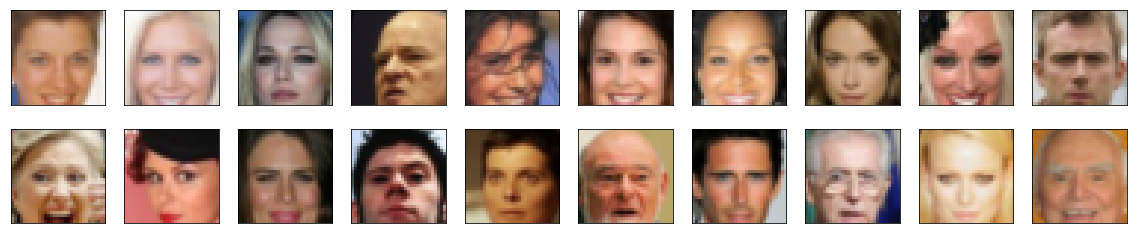

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x

    min, max = feature_range
    x = x * (max - min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7098)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # Most of this design is just right out of the lesson plan

        self.conv_dim = conv_dim
        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        # using conv layers similar to examples in lesson plan
        # No pooling layers... downsample handled by stride=2
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4)
        
        # Classification layer
        # DC GAN has FC layer as the final layer with a binary output
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # dropout to help with over fittings
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # relu applied to all conv layers but last
        out = F.leaky_relu(self.conv1(x))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = F.leaky_relu(self.conv4(out))
        
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer includes a sigmoid activation
        # add dropout 
        out = self.dropout(self.fc(out))

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        # go from deep and narrow to shallow and wide
        # Most of this design is just right out of the lesson plan
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        # Adding more layers with stride of 1 to deepen
        # the Generator. This should pull out more features
        # from the input noise source
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, kernel_size=4)
        self.deconv1b = deconv(conv_dim*4, conv_dim*4, kernel_size=3, stride=1, padding=1)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, kernel_size=4)
        self.deconv2b = deconv(conv_dim*2, conv_dim*2, kernel_size=3, stride=1, padding=1)
        self.deconv3 = deconv(conv_dim*2, conv_dim, kernel_size=4)
        self.deconv3b = deconv(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1)
        self.deconv4 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)
        
        #dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # deconv layers and relu activation for each
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv1b(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv2b(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv3b(out))
        
        # last layer and tanh activation
        out = self.dropout(self.deconv4(out))
        out = F.tanh(out)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 2048

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=2048, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    # Most of this design is just right out of the lesson plan
    # doesn't seem to be a need to deviate from that info.
    batch_size = D_out.size(0)
    
    #smoothing is assumed based on the lack
    # of an additional parameter to this func
    labels = torch.ones(batch_size) * 0.9
    
    #move labels to GPU
    if train_on_gpu:
        labels = labels.cuda()
    
    #binary cross entropy with logits loss
    # performs well for DCGANs
    criterion = nn.BCEWithLogitsLoss()
    
    #loss value to be returned.
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    #fake labels have a value of 0
    labels = torch.zeros(batch_size)
    
    #move labels to GPU if necessary
    if train_on_gpu:
        labels = labels.cuda()
        
    #binary cross entropy with logits loss
    # performs well for DCGANs
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss and return it
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim 

lr = 0.0002
beta1 = 0.2
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
from workspace_utils import active_session

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
 
    with active_session():
        # do long-running work here
        # move models to GPU
        if train_on_gpu:
            D.cuda()
            G.cuda()

        # keep track of loss and generated, "fake" samples
        samples = []
        losses = []

        # Get some fixed data for sampling. These are images that are held
        # constant throughout training, and allow us to inspect the model's performance
        sample_size=16
        fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
        fixed_z = torch.from_numpy(fixed_z).float()
        # move z to GPU if available
        if train_on_gpu:
            fixed_z = fixed_z.cuda()

        # epoch training loop
        for epoch in range(n_epochs):

            # batch training loop
            for batch_i, (real_images, _) in enumerate(celeba_train_loader):

                batch_size = real_images.size(0)
                real_images = scale(real_images)

                # ===============================================
                #         YOUR CODE HERE: TRAIN THE NETWORKS
                # ===============================================
                # Again, pretty much using algo from lesson material
                # doesn't seem to be a need to deviate from that info.
                # ============================================
                #            TRAIN THE DISCRIMINATOR
                # ============================================
                d_optimizer.zero_grad()

                # 1. Train with real images

                # Compute the discriminator losses on real images 
                if train_on_gpu:
                    real_images = real_images.cuda()

                D_real = D(real_images)
                d_real_loss = real_loss(D_real)

                # 2. Train with fake images

                # Generate fake images with uniform dist
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # convert to float values
                z = torch.from_numpy(z).float()

                # move x to GPU, if available
                if train_on_gpu:
                    z = z.cuda()

                # Why not train the G first and use that output???
                fake_images = G(z)

                # Compute the discriminator loss           
                D_fake = D(fake_images)
                d_fake_loss = fake_loss(D_fake)

                # add up loss and perform backprop
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                d_optimizer.step()


                # =========================================
                #            TRAIN THE GENERATOR
                # =========================================
                g_optimizer.zero_grad()

                # 1. Train with fake images and flipped labels

                # Generate fake images
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)

                # Compute the discriminator losses
                D_fake = D(fake_images)
                g_loss = real_loss(D_fake)

                # perform backprop
                g_loss.backward()
                g_optimizer.step()

                # ===============================================
                #              END OF YOUR CODE
                # ===============================================

                # Print some loss stats
                if batch_i % print_every == 0:
                    # append discriminator loss and generator loss
                    losses.append((d_loss.item(), g_loss.item()))
                    # print discriminator and generator loss
                    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                            epoch+1, n_epochs, d_loss.item(), g_loss.item()))


            ## AFTER EACH EPOCH##    
            # this code assumes your generator is named G, feel free to change the name
            # generate and save sample, fake images
            G.eval() # for generating samples
            samples_z = G(fixed_z)
            samples.append(samples_z)
            G.train() # back to training mode

        # Save training generator samples
        with open('train_samples.pkl', 'wb') as f:
            pkl.dump(samples, f)

        # finally return losses
        return losses

Set your number of training epochs and train your GAN!

In [24]:
# set number of epochs 
# I used 40, but Udacity system times out which
# causes me to babysit this notebook,. Bad design
# Udacity. So I had to re-run the entire training 
# at a lesser epoch value. I'm sure I had better results
n_epochs = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL 
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.3858 | g_loss: 1.1372
Epoch [    1/   20] | d_loss: 0.6677 | g_loss: 3.4370
Epoch [    1/   20] | d_loss: 0.6210 | g_loss: 3.4844
Epoch [    1/   20] | d_loss: 0.6889 | g_loss: 3.4779
Epoch [    1/   20] | d_loss: 0.5696 | g_loss: 3.9203
Epoch [    1/   20] | d_loss: 0.6003 | g_loss: 3.7796
Epoch [    1/   20] | d_loss: 0.4751 | g_loss: 4.3946
Epoch [    1/   20] | d_loss: 0.5092 | g_loss: 4.5569
Epoch [    1/   20] | d_loss: 0.5068 | g_loss: 4.6577
Epoch [    1/   20] | d_loss: 0.5055 | g_loss: 5.2628
Epoch [    1/   20] | d_loss: 0.5498 | g_loss: 3.9440
Epoch [    1/   20] | d_loss: 0.5092 | g_loss: 4.7965
Epoch [    1/   20] | d_loss: 0.4495 | g_loss: 5.1181
Epoch [    1/   20] | d_loss: 0.5149 | g_loss: 4.7228
Epoch [    1/   20] | d_loss: 0.5050 | g_loss: 4.9168
Epoch [    1/   20] | d_loss: 0.4925 | g_loss: 4.8919
Epoch [    1/   20] | d_loss: 0.5684 | g_loss: 5.7310
Epoch [    1/   20] | d_loss: 0.5690 | g_loss: 5.0681
Epoch [    1/   20] | d_loss

Epoch [    3/   20] | d_loss: 0.4896 | g_loss: 8.5542
Epoch [    3/   20] | d_loss: 0.5457 | g_loss: 11.0274
Epoch [    3/   20] | d_loss: 0.5891 | g_loss: 8.8032
Epoch [    3/   20] | d_loss: 0.5583 | g_loss: 9.6965
Epoch [    3/   20] | d_loss: 0.5444 | g_loss: 9.2401
Epoch [    3/   20] | d_loss: 0.6310 | g_loss: 10.3506
Epoch [    3/   20] | d_loss: 0.4591 | g_loss: 9.8629
Epoch [    3/   20] | d_loss: 0.5444 | g_loss: 9.1548
Epoch [    3/   20] | d_loss: 0.4796 | g_loss: 9.7033
Epoch [    3/   20] | d_loss: 0.4910 | g_loss: 9.9164
Epoch [    3/   20] | d_loss: 0.5227 | g_loss: 9.6881
Epoch [    3/   20] | d_loss: 0.5457 | g_loss: 8.8653
Epoch [    3/   20] | d_loss: 0.4693 | g_loss: 9.3479
Epoch [    3/   20] | d_loss: 0.5254 | g_loss: 10.2457
Epoch [    3/   20] | d_loss: 0.5126 | g_loss: 8.4081
Epoch [    3/   20] | d_loss: 0.6121 | g_loss: 9.0113
Epoch [    3/   20] | d_loss: 0.5674 | g_loss: 10.4784
Epoch [    3/   20] | d_loss: 0.5802 | g_loss: 8.7279
Epoch [    3/   20] | d_

Epoch [    6/   20] | d_loss: 0.5473 | g_loss: 9.5561
Epoch [    6/   20] | d_loss: 0.4808 | g_loss: 9.4982
Epoch [    6/   20] | d_loss: 0.5025 | g_loss: 8.9183
Epoch [    6/   20] | d_loss: 0.5241 | g_loss: 10.8297
Epoch [    6/   20] | d_loss: 0.6121 | g_loss: 9.0117
Epoch [    6/   20] | d_loss: 0.4144 | g_loss: 9.8430
Epoch [    6/   20] | d_loss: 0.4794 | g_loss: 9.2467
Epoch [    6/   20] | d_loss: 0.5113 | g_loss: 9.0360
Epoch [    6/   20] | d_loss: 0.4695 | g_loss: 9.6618
Epoch [    6/   20] | d_loss: 0.5039 | g_loss: 8.4288
Epoch [    6/   20] | d_loss: 0.4923 | g_loss: 8.8246
Epoch [    6/   20] | d_loss: 0.6019 | g_loss: 8.7847
Epoch [    6/   20] | d_loss: 0.5776 | g_loss: 9.2853
Epoch [    6/   20] | d_loss: 0.5114 | g_loss: 8.6534
Epoch [    6/   20] | d_loss: 0.5905 | g_loss: 8.9528
Epoch [    6/   20] | d_loss: 0.5444 | g_loss: 7.7624
Epoch [    6/   20] | d_loss: 0.5572 | g_loss: 9.0904
Epoch [    6/   20] | d_loss: 0.5904 | g_loss: 8.2214
Epoch [    6/   20] | d_los

Epoch [    8/   20] | d_loss: 0.5240 | g_loss: 5.8211
Epoch [    9/   20] | d_loss: 0.5666 | g_loss: 6.3831
Epoch [    9/   20] | d_loss: 0.5472 | g_loss: 5.7305
Epoch [    9/   20] | d_loss: 0.5783 | g_loss: 6.3437
Epoch [    9/   20] | d_loss: 0.5552 | g_loss: 5.6992
Epoch [    9/   20] | d_loss: 0.5045 | g_loss: 5.6936
Epoch [    9/   20] | d_loss: 0.6011 | g_loss: 5.9455
Epoch [    9/   20] | d_loss: 0.5349 | g_loss: 6.6446
Epoch [    9/   20] | d_loss: 0.6011 | g_loss: 6.0822
Epoch [    9/   20] | d_loss: 0.3918 | g_loss: 6.3758
Epoch [    9/   20] | d_loss: 0.5131 | g_loss: 6.2873
Epoch [    9/   20] | d_loss: 0.5779 | g_loss: 7.3971
Epoch [    9/   20] | d_loss: 0.5245 | g_loss: 7.7013
Epoch [    9/   20] | d_loss: 0.5128 | g_loss: 5.5563
Epoch [    9/   20] | d_loss: 0.5231 | g_loss: 7.7695
Epoch [    9/   20] | d_loss: 0.5881 | g_loss: 6.4095
Epoch [    9/   20] | d_loss: 0.5332 | g_loss: 7.1757
Epoch [    9/   20] | d_loss: 0.5473 | g_loss: 5.8908
Epoch [    9/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.5775 | g_loss: 10.8811
Epoch [   11/   20] | d_loss: 0.5369 | g_loss: 11.2330
Epoch [   11/   20] | d_loss: 0.6236 | g_loss: 11.5125
Epoch [   11/   20] | d_loss: 0.4909 | g_loss: 10.9629
Epoch [   11/   20] | d_loss: 0.5891 | g_loss: 12.2784
Epoch [   11/   20] | d_loss: 0.5024 | g_loss: 11.1780
Epoch [   11/   20] | d_loss: 0.4577 | g_loss: 11.1679
Epoch [   11/   20] | d_loss: 0.5461 | g_loss: 9.6123
Epoch [   11/   20] | d_loss: 0.5024 | g_loss: 12.3093
Epoch [   11/   20] | d_loss: 0.5139 | g_loss: 10.2156
Epoch [   11/   20] | d_loss: 0.5905 | g_loss: 11.5950
Epoch [   11/   20] | d_loss: 0.5359 | g_loss: 11.0831
Epoch [   11/   20] | d_loss: 0.4917 | g_loss: 10.9084
Epoch [   11/   20] | d_loss: 0.5572 | g_loss: 11.7231
Epoch [   11/   20] | d_loss: 0.5268 | g_loss: 11.1105
Epoch [   11/   20] | d_loss: 0.6425 | g_loss: 13.2742
Epoch [   11/   20] | d_loss: 0.5038 | g_loss: 12.6693
Epoch [   11/   20] | d_loss: 0.4679 | g_loss: 11.1576
Epoch [   1

Epoch [   14/   20] | d_loss: 0.5369 | g_loss: 9.8626
Epoch [   14/   20] | d_loss: 0.5891 | g_loss: 9.7838
Epoch [   14/   20] | d_loss: 0.4578 | g_loss: 9.2786
Epoch [   14/   20] | d_loss: 0.5255 | g_loss: 11.0293
Epoch [   14/   20] | d_loss: 0.5370 | g_loss: 9.1184
Epoch [   14/   20] | d_loss: 0.5241 | g_loss: 9.3689
Epoch [   14/   20] | d_loss: 0.5270 | g_loss: 8.5578
Epoch [   14/   20] | d_loss: 0.5471 | g_loss: 10.6554
Epoch [   14/   20] | d_loss: 0.5547 | g_loss: 10.7041
Epoch [   14/   20] | d_loss: 0.6541 | g_loss: 9.1171
Epoch [   14/   20] | d_loss: 0.6081 | g_loss: 8.5836
Epoch [   14/   20] | d_loss: 0.5444 | g_loss: 9.0767
Epoch [   14/   20] | d_loss: 0.5343 | g_loss: 8.4897
Epoch [   14/   20] | d_loss: 0.5471 | g_loss: 9.1625
Epoch [   14/   20] | d_loss: 0.4821 | g_loss: 10.0022
Epoch [   14/   20] | d_loss: 0.5242 | g_loss: 9.8340
Epoch [   14/   20] | d_loss: 0.5573 | g_loss: 8.5785
Epoch [   14/   20] | d_loss: 0.6581 | g_loss: 10.5100
Epoch [   14/   20] | d

Epoch [   16/   20] | d_loss: 0.4829 | g_loss: 6.5072
Epoch [   16/   20] | d_loss: 0.4782 | g_loss: 6.9383
Epoch [   16/   20] | d_loss: 0.5148 | g_loss: 6.4264
Epoch [   16/   20] | d_loss: 0.4927 | g_loss: 6.8581
Epoch [   16/   20] | d_loss: 0.5682 | g_loss: 6.6974
Epoch [   17/   20] | d_loss: 0.5452 | g_loss: 6.7971
Epoch [   17/   20] | d_loss: 0.5365 | g_loss: 6.2662
Epoch [   17/   20] | d_loss: 0.5132 | g_loss: 6.6412
Epoch [   17/   20] | d_loss: 0.5793 | g_loss: 7.6679
Epoch [   17/   20] | d_loss: 0.4928 | g_loss: 6.3821
Epoch [   17/   20] | d_loss: 0.5678 | g_loss: 7.5155
Epoch [   17/   20] | d_loss: 0.4479 | g_loss: 7.8896
Epoch [   17/   20] | d_loss: 0.6251 | g_loss: 8.4348
Epoch [   17/   20] | d_loss: 0.5350 | g_loss: 7.4203
Epoch [   17/   20] | d_loss: 0.5474 | g_loss: 8.4871
Epoch [   17/   20] | d_loss: 0.6340 | g_loss: 7.6719
Epoch [   17/   20] | d_loss: 0.5461 | g_loss: 7.8665
Epoch [   17/   20] | d_loss: 0.5242 | g_loss: 7.8974
Epoch [   17/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.5227 | g_loss: 11.9781
Epoch [   19/   20] | d_loss: 0.5458 | g_loss: 9.4535
Epoch [   19/   20] | d_loss: 0.4361 | g_loss: 10.6159
Epoch [   19/   20] | d_loss: 0.5342 | g_loss: 10.2732
Epoch [   19/   20] | d_loss: 0.5444 | g_loss: 9.6066
Epoch [   19/   20] | d_loss: 0.5051 | g_loss: 10.6613
Epoch [   19/   20] | d_loss: 0.5330 | g_loss: 10.4219
Epoch [   19/   20] | d_loss: 0.4364 | g_loss: 10.4050
Epoch [   19/   20] | d_loss: 0.4896 | g_loss: 9.9963
Epoch [   19/   20] | d_loss: 0.5701 | g_loss: 11.8816
Epoch [   19/   20] | d_loss: 0.5546 | g_loss: 10.2777
Epoch [   19/   20] | d_loss: 0.4794 | g_loss: 9.3774
Epoch [   19/   20] | d_loss: 0.6236 | g_loss: 10.4094
Epoch [   19/   20] | d_loss: 0.4707 | g_loss: 8.1473
Epoch [   19/   20] | d_loss: 0.5904 | g_loss: 10.2998
Epoch [   19/   20] | d_loss: 0.5139 | g_loss: 10.4369
Epoch [   19/   20] | d_loss: 0.4909 | g_loss: 10.4515
Epoch [   19/   20] | d_loss: 0.5370 | g_loss: 10.5725
Epoch [   19/  

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

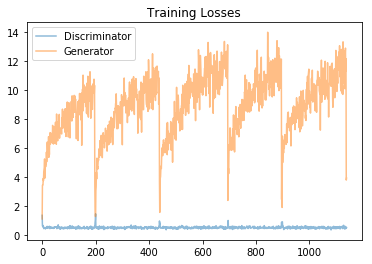

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses") 
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [27]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

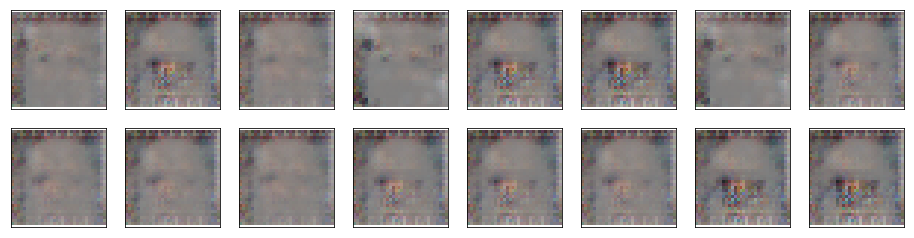

In [29]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

It was suggested in the first code review to make the G model deeper. I did so. Then the system timed out and lost the in memory losses value. So I had to rerun it. The generated images look terrible. I imagine that if the system hadn't time out that the images would look good. See my loss values below when I ran 40 epochs. This time I ran 20 epochs and have no idea why they look like blurry images.

I did not use a sigmoid activation on the Discriminator because there is only one cell available for output and presumably that is either 0 or 1 from which a classifiction can be made. This is in contrast to the lesson material which clearly indicated a sigmoid activation. 

We were instructed above to use 32x32 image size so the resolution is poor. Higher resolution could result in more interesting images.

The images are celebrities and mostly white. Celebrities are often smiling in photos like these so the data could be expanded to include more facial expressions which could lead to more interesting output. However, I see the first image in the first row appears to be a white male with sort of a mocha skin tone applied to his face.

I only ran 20 epochs. I will run more later to obtain better results, however, 20 illustrates the capabilities of a DCGAN.

I used a slow lr as noted in the lesson material. More epochs can help this learning rate produce good output. I also used the recommended (lesson material) optimizer. I assume that recommendation was based on experience, however, a long grid search could elicit better hyperparameters...

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

Here is the results of the 40 epochs that will not be displayed above due to the timeout and lack of preservation of variables (losses) which could have prevented a full day loss of time.

Epoch [    1/   40] | d_loss: 0.8216 | g_loss: 1.8973
Epoch [    1/   40] | d_loss: 0.8570 | g_loss: 1.6021
Epoch [    1/   40] | d_loss: 1.0567 | g_loss: 2.6506
Epoch [    1/   40] | d_loss: 0.9862 | g_loss: 2.5328
Epoch [    1/   40] | d_loss: 1.0159 | g_loss: 1.3859
Epoch [    1/   40] | d_loss: 1.0116 | g_loss: 1.6647
Epoch [    1/   40] | d_loss: 0.9844 | g_loss: 1.7330
Epoch [    1/   40] | d_loss: 0.8843 | g_loss: 1.1704
Epoch [    1/   40] | d_loss: 0.8385 | g_loss: 1.8456
Epoch [    1/   40] | d_loss: 1.0995 | g_loss: 2.3404
Epoch [    1/   40] | d_loss: 0.9328 | g_loss: 1.7974
Epoch [    1/   40] | d_loss: 1.0211 | g_loss: 2.8673
Epoch [    1/   40] | d_loss: 0.9277 | g_loss: 1.9534
Epoch [    1/   40] | d_loss: 1.0854 | g_loss: 1.7573
Epoch [    1/   40] | d_loss: 1.0036 | g_loss: 1.0084
Epoch [    1/   40] | d_loss: 0.9330 | g_loss: 2.0687
Epoch [    1/   40] | d_loss: 0.7614 | g_loss: 2.2574
Epoch [    1/   40] | d_loss: 1.2004 | g_loss: 1.2247
Epoch [    1/   40] | d_loss: 0.9150 | g_loss: 1.6011
Epoch [    1/   40] | d_loss: 1.0110 | g_loss: 2.3912
Epoch [    1/   40] | d_loss: 1.1204 | g_loss: 1.7036
Epoch [    1/   40] | d_loss: 1.0946 | g_loss: 1.4867
Epoch [    1/   40] | d_loss: 0.9865 | g_loss: 2.1409
Epoch [    1/   40] | d_loss: 0.8557 | g_loss: 1.6956
Epoch [    1/   40] | d_loss: 0.7654 | g_loss: 1.9586
Epoch [    1/   40] | d_loss: 0.9927 | g_loss: 2.0479
Epoch [    1/   40] | d_loss: 1.0256 | g_loss: 1.5945
Epoch [    1/   40] | d_loss: 0.9287 | g_loss: 3.3730
Epoch [    1/   40] | d_loss: 1.1522 | g_loss: 2.3472
Epoch [    1/   40] | d_loss: 1.2040 | g_loss: 1.1838
Epoch [    1/   40] | d_loss: 0.8919 | g_loss: 1.2575
Epoch [    1/   40] | d_loss: 0.9462 | g_loss: 2.2893
Epoch [    1/   40] | d_loss: 1.2359 | g_loss: 1.2871
Epoch [    1/   40] | d_loss: 0.9891 | g_loss: 1.6598
Epoch [    1/   40] | d_loss: 1.1444 | g_loss: 0.8714
Epoch [    1/   40] | d_loss: 1.1101 | g_loss: 1.0612
Epoch [    1/   40] | d_loss: 0.8068 | g_loss: 1.6957
Epoch [    1/   40] | d_loss: 0.9815 | g_loss: 1.5505
Epoch [    1/   40] | d_loss: 0.9588 | g_loss: 1.4830
Epoch [    1/   40] | d_loss: 1.0486 | g_loss: 1.8710
Epoch [    1/   40] | d_loss: 0.9277 | g_loss: 1.5504
Epoch [    1/   40] | d_loss: 1.1152 | g_loss: 1.2086
Epoch [    1/   40] | d_loss: 0.9555 | g_loss: 2.1838
Epoch [    1/   40] | d_loss: 0.8962 | g_loss: 2.8096
Epoch [    1/   40] | d_loss: 0.9628 | g_loss: 3.0141
Epoch [    1/   40] | d_loss: 1.8586 | g_loss: 2.5507
Epoch [    1/   40] | d_loss: 0.7543 | g_loss: 2.3360
Epoch [    1/   40] | d_loss: 1.0772 | g_loss: 3.2051
Epoch [    1/   40] | d_loss: 1.0038 | g_loss: 1.7592
Epoch [    1/   40] | d_loss: 1.0150 | g_loss: 1.3425
Epoch [    1/   40] | d_loss: 0.8910 | g_loss: 2.6512
Epoch [    1/   40] | d_loss: 0.7761 | g_loss: 2.4779
Epoch [    1/   40] | d_loss: 0.8093 | g_loss: 2.0001
Epoch [    1/   40] | d_loss: 1.0175 | g_loss: 0.9416
Epoch [    1/   40] | d_loss: 0.8248 | g_loss: 1.9393
Epoch [    1/   40] | d_loss: 0.8260 | g_loss: 1.8056
Epoch [    1/   40] | d_loss: 1.2777 | g_loss: 3.0249
Epoch [    2/   40] | d_loss: 0.7491 | g_loss: 1.6559
Epoch [    2/   40] | d_loss: 0.9531 | g_loss: 1.4209
Epoch [    2/   40] | d_loss: 1.0025 | g_loss: 2.6235
Epoch [    2/   40] | d_loss: 0.8133 | g_loss: 1.4826
Epoch [    2/   40] | d_loss: 0.9478 | g_loss: 2.3583
Epoch [    2/   40] | d_loss: 1.1910 | g_loss: 1.7312
Epoch [    2/   40] | d_loss: 1.6132 | g_loss: 1.4901
Epoch [    2/   40] | d_loss: 1.0332 | g_loss: 2.9044
Epoch [    2/   40] | d_loss: 0.9555 | g_loss: 2.2071
Epoch [    2/   40] | d_loss: 1.1581 | g_loss: 2.2837
Epoch [    2/   40] | d_loss: 1.0505 | g_loss: 1.5932
Epoch [    2/   40] | d_loss: 0.7708 | g_loss: 1.8969
Epoch [    2/   40] | d_loss: 0.8196 | g_loss: 2.2367
Epoch [    2/   40] | d_loss: 0.9612 | g_loss: 1.0629
Epoch [    2/   40] | d_loss: 0.7926 | g_loss: 2.2253
Epoch [    2/   40] | d_loss: 1.4490 | g_loss: 1.8145
Epoch [    2/   40] | d_loss: 1.0632 | g_loss: 2.2314
Epoch [    2/   40] | d_loss: 0.9909 | g_loss: 1.3614
Epoch [    2/   40] | d_loss: 1.0919 | g_loss: 4.0293
Epoch [    2/   40] | d_loss: 1.0401 | g_loss: 3.3300
Epoch [    2/   40] | d_loss: 0.8468 | g_loss: 2.0591
Epoch [    2/   40] | d_loss: 0.8778 | g_loss: 1.7802
Epoch [    2/   40] | d_loss: 1.0715 | g_loss: 2.7502
Epoch [    2/   40] | d_loss: 0.8377 | g_loss: 1.8524
Epoch [    2/   40] | d_loss: 1.0310 | g_loss: 1.3143
Epoch [    2/   40] | d_loss: 0.8841 | g_loss: 1.7312
Epoch [    2/   40] | d_loss: 1.0219 | g_loss: 1.7132
Epoch [    2/   40] | d_loss: 0.7863 | g_loss: 1.8599
Epoch [    2/   40] | d_loss: 0.7850 | g_loss: 2.0447
Epoch [    2/   40] | d_loss: 1.0657 | g_loss: 1.1629
Epoch [    2/   40] | d_loss: 0.7870 | g_loss: 2.3641
Epoch [    2/   40] | d_loss: 0.8400 | g_loss: 1.3677
Epoch [    2/   40] | d_loss: 0.8947 | g_loss: 2.0767
Epoch [    2/   40] | d_loss: 0.8530 | g_loss: 2.5818
Epoch [    2/   40] | d_loss: 0.6926 | g_loss: 2.0662
Epoch [    2/   40] | d_loss: 0.9972 | g_loss: 1.9262
Epoch [    2/   40] | d_loss: 0.9989 | g_loss: 2.6717
Epoch [    2/   40] | d_loss: 0.7901 | g_loss: 2.4657
Epoch [    2/   40] | d_loss: 1.2436 | g_loss: 3.0059
Epoch [    2/   40] | d_loss: 0.9458 | g_loss: 1.9879
Epoch [    2/   40] | d_loss: 0.6712 | g_loss: 2.1494
Epoch [    2/   40] | d_loss: 0.9478 | g_loss: 1.6733
Epoch [    2/   40] | d_loss: 0.9329 | g_loss: 1.1007
Epoch [    2/   40] | d_loss: 1.1272 | g_loss: 1.3445
Epoch [    2/   40] | d_loss: 0.9198 | g_loss: 1.7844
Epoch [    2/   40] | d_loss: 1.0805 | g_loss: 2.3745
Epoch [    2/   40] | d_loss: 1.1090 | g_loss: 3.7291
Epoch [    2/   40] | d_loss: 1.0452 | g_loss: 2.4172
Epoch [    2/   40] | d_loss: 0.9854 | g_loss: 1.6547
Epoch [    2/   40] | d_loss: 0.9384 | g_loss: 2.6229
Epoch [    2/   40] | d_loss: 0.7922 | g_loss: 1.3402
Epoch [    2/   40] | d_loss: 1.0140 | g_loss: 2.4516
Epoch [    2/   40] | d_loss: 0.7729 | g_loss: 2.1608
Epoch [    2/   40] | d_loss: 0.8747 | g_loss: 2.2593
Epoch [    2/   40] | d_loss: 1.2168 | g_loss: 1.2606
Epoch [    2/   40] | d_loss: 0.8240 | g_loss: 2.0906
Epoch [    2/   40] | d_loss: 0.8004 | g_loss: 2.2299
Epoch [    3/   40] | d_loss: 1.7804 | g_loss: 3.7683
Epoch [    3/   40] | d_loss: 1.0248 | g_loss: 1.3528
Epoch [    3/   40] | d_loss: 0.8608 | g_loss: 2.5329
Epoch [    3/   40] | d_loss: 0.8965 | g_loss: 1.6421
Epoch [    3/   40] | d_loss: 1.1989 | g_loss: 1.7613
Epoch [    3/   40] | d_loss: 0.9005 | g_loss: 1.8914
Epoch [    3/   40] | d_loss: 0.8206 | g_loss: 1.4876
Epoch [    3/   40] | d_loss: 0.8754 | g_loss: 2.5754
Epoch [    3/   40] | d_loss: 0.7640 | g_loss: 2.4385
Epoch [    3/   40] | d_loss: 1.1330 | g_loss: 1.3091
Epoch [    3/   40] | d_loss: 0.6948 | g_loss: 2.5546
Epoch [    3/   40] | d_loss: 1.0602 | g_loss: 3.2102
Epoch [    3/   40] | d_loss: 0.9032 | g_loss: 2.5243
Epoch [    3/   40] | d_loss: 0.8979 | g_loss: 2.3114
Epoch [    3/   40] | d_loss: 0.8563 | g_loss: 2.0412
Epoch [    3/   40] | d_loss: 0.8917 | g_loss: 1.9066
Epoch [    3/   40] | d_loss: 1.0026 | g_loss: 1.6345
Epoch [    3/   40] | d_loss: 0.9773 | g_loss: 2.2124
Epoch [    3/   40] | d_loss: 1.2307 | g_loss: 3.1565
Epoch [    3/   40] | d_loss: 0.7886 | g_loss: 2.3046
Epoch [    3/   40] | d_loss: 0.9240 | g_loss: 1.2039
Epoch [    3/   40] | d_loss: 1.0541 | g_loss: 2.8772
Epoch [    3/   40] | d_loss: 1.1006 | g_loss: 1.4481
Epoch [    3/   40] | d_loss: 0.9878 | g_loss: 3.6401
Epoch [    3/   40] | d_loss: 1.0061 | g_loss: 1.0437
Epoch [    3/   40] | d_loss: 1.2247 | g_loss: 1.1638
Epoch [    3/   40] | d_loss: 0.8746 | g_loss: 1.9965
Epoch [    3/   40] | d_loss: 0.8503 | g_loss: 2.1961
Epoch [    3/   40] | d_loss: 0.8971 | g_loss: 1.7468
Epoch [    3/   40] | d_loss: 0.7044 | g_loss: 1.9949
Epoch [    3/   40] | d_loss: 0.9513 | g_loss: 1.7934
Epoch [    3/   40] | d_loss: 1.4219 | g_loss: 1.2607
Epoch [    3/   40] | d_loss: 1.0165 | g_loss: 3.0327
Epoch [    3/   40] | d_loss: 0.8950 | g_loss: 1.2033
Epoch [    3/   40] | d_loss: 0.8765 | g_loss: 2.6529
Epoch [    3/   40] | d_loss: 1.0997 | g_loss: 1.0916
Epoch [    3/   40] | d_loss: 1.0114 | g_loss: 2.9767
Epoch [    3/   40] | d_loss: 0.7649 | g_loss: 1.9215

Epoch [    3/   40] | d_loss: 0.8279 | g_loss: 2.8694
Epoch [    3/   40] | d_loss: 1.0506 | g_loss: 1.3583
Epoch [    3/   40] | d_loss: 0.9612 | g_loss: 1.5048
Epoch [    3/   40] | d_loss: 0.9558 | g_loss: 3.1110
Epoch [    3/   40] | d_loss: 0.9370 | g_loss: 1.6084
Epoch [    3/   40] | d_loss: 1.1548 | g_loss: 0.8516
Epoch [    3/   40] | d_loss: 0.9364 | g_loss: 1.5924
Epoch [    3/   40] | d_loss: 0.7984 | g_loss: 2.3096
Epoch [    3/   40] | d_loss: 0.9329 | g_loss: 3.3033
Epoch [    3/   40] | d_loss: 0.9176 | g_loss: 2.4903
Epoch [    3/   40] | d_loss: 1.0758 | g_loss: 2.0083
Epoch [    3/   40] | d_loss: 1.1232 | g_loss: 3.7314
Epoch [    3/   40] | d_loss: 1.4079 | g_loss: 3.3921
Epoch [    3/   40] | d_loss: 1.0046 | g_loss: 2.2343
Epoch [    3/   40] | d_loss: 0.7940 | g_loss: 2.3061
Epoch [    3/   40] | d_loss: 0.8009 | g_loss: 1.2840
Epoch [    3/   40] | d_loss: 0.9873 | g_loss: 1.4994
Epoch [    3/   40] | d_loss: 0.9240 | g_loss: 1.9238
Epoch [    3/   40] | d_loss: 1.3014 | g_loss: 1.1668
Epoch [    4/   40] | d_loss: 0.9000 | g_loss: 3.0067
Epoch [    4/   40] | d_loss: 0.8539 | g_loss: 2.3175
Epoch [    4/   40] | d_loss: 1.1735 | g_loss: 1.4324
Epoch [    4/   40] | d_loss: 0.9358 | g_loss: 2.4891
Epoch [    4/   40] | d_loss: 0.9177 | g_loss: 2.1567
Epoch [    4/   40] | d_loss: 1.0606 | g_loss: 1.1780
Epoch [    4/   40] | d_loss: 0.7498 | g_loss: 1.5638
Epoch [    4/   40] | d_loss: 0.9739 | g_loss: 2.0612
Epoch [    4/   40] | d_loss: 1.1235 | g_loss: 3.0215
Epoch [    4/   40] | d_loss: 0.9035 | g_loss: 1.2326
Epoch [    4/   40] | d_loss: 0.7484 | g_loss: 1.1238
Epoch [    4/   40] | d_loss: 0.9003 | g_loss: 1.6179
Epoch [    4/   40] | d_loss: 0.8087 | g_loss: 1.9423
Epoch [    4/   40] | d_loss: 1.0041 | g_loss: 1.7673
Epoch [    4/   40] | d_loss: 0.9564 | g_loss: 1.9361
Epoch [    4/   40] | d_loss: 0.8984 | g_loss: 1.4164
Epoch [    4/   40] | d_loss: 0.8523 | g_loss: 2.4027
Epoch [    4/   40] | d_loss: 1.2315 | g_loss: 1.2233
Epoch [    4/   40] | d_loss: 0.9326 | g_loss: 1.2305
Epoch [    4/   40] | d_loss: 1.0469 | g_loss: 1.7596
Epoch [    4/   40] | d_loss: 0.9972 | g_loss: 1.0803
Epoch [    4/   40] | d_loss: 1.2533 | g_loss: 1.4850
Epoch [    4/   40] | d_loss: 1.1138 | g_loss: 4.5029
Epoch [    4/   40] | d_loss: 0.9167 | g_loss: 1.8412
Epoch [    4/   40] | d_loss: 0.9660 | g_loss: 2.0284
Epoch [    4/   40] | d_loss: 1.0820 | g_loss: 1.0661
Epoch [    4/   40] | d_loss: 0.9538 | g_loss: 2.6007
Epoch [    4/   40] | d_loss: 0.7317 | g_loss: 2.4127
Epoch [    4/   40] | d_loss: 0.8951 | g_loss: 1.4994
Epoch [    4/   40] | d_loss: 0.7453 | g_loss: 1.0286
Epoch [    4/   40] | d_loss: 0.8993 | g_loss: 3.1906
Epoch [    4/   40] | d_loss: 0.7765 | g_loss: 1.5685
Epoch [    4/   40] | d_loss: 1.1327 | g_loss: 2.3361
Epoch [    4/   40] | d_loss: 0.8399 | g_loss: 2.4388
Epoch [    4/   40] | d_loss: 0.8306 | g_loss: 2.3271
Epoch [    4/   40] | d_loss: 0.8823 | g_loss: 2.7825
Epoch [    4/   40] | d_loss: 0.9693 | g_loss: 2.3805
Epoch [    4/   40] | d_loss: 1.0609 | g_loss: 2.4537
Epoch [    4/   40] | d_loss: 0.8673 | g_loss: 1.7633
Epoch [    4/   40] | d_loss: 0.8285 | g_loss: 1.9497
Epoch [    4/   40] | d_loss: 0.9431 | g_loss: 2.5040
Epoch [    4/   40] | d_loss: 0.7496 | g_loss: 2.2456
Epoch [    4/   40] | d_loss: 0.8897 | g_loss: 2.2954
Epoch [    4/   40] | d_loss: 0.9730 | g_loss: 3.0751
Epoch [    4/   40] | d_loss: 0.7289 | g_loss: 1.8313
Epoch [    4/   40] | d_loss: 0.9205 | g_loss: 1.4137
Epoch [    4/   40] | d_loss: 0.9032 | g_loss: 1.5377
Epoch [    4/   40] | d_loss: 1.1147 | g_loss: 1.7217
Epoch [    4/   40] | d_loss: 0.8890 | g_loss: 2.0139
Epoch [    4/   40] | d_loss: 0.9596 | g_loss: 1.2077
Epoch [    4/   40] | d_loss: 0.7850 | g_loss: 1.8576
Epoch [    4/   40] | d_loss: 0.9516 | g_loss: 2.1933
Epoch [    4/   40] | d_loss: 0.8891 | g_loss: 1.7127
Epoch [    4/   40] | d_loss: 1.3675 | g_loss: 0.8318
Epoch [    4/   40] | d_loss: 0.7485 | g_loss: 2.2301
Epoch [    4/   40] | d_loss: 0.9108 | g_loss: 3.1936
Epoch [    4/   40] | d_loss: 1.1040 | g_loss: 2.1239
Epoch [    5/   40] | d_loss: 0.6925 | g_loss: 2.7747
Epoch [    5/   40] | d_loss: 0.7683 | g_loss: 3.0341
Epoch [    5/   40] | d_loss: 1.0375 | g_loss: 3.8767
Epoch [    5/   40] | d_loss: 0.8388 | g_loss: 3.2303
Epoch [    5/   40] | d_loss: 0.7016 | g_loss: 2.4919
Epoch [    5/   40] | d_loss: 1.1021 | g_loss: 2.2287
Epoch [    5/   40] | d_loss: 0.8261 | g_loss: 2.1294
Epoch [    5/   40] | d_loss: 0.7924 | g_loss: 2.3226
Epoch [    5/   40] | d_loss: 0.8825 | g_loss: 2.9881
Epoch [    5/   40] | d_loss: 0.6202 | g_loss: 2.1188
Epoch [    5/   40] | d_loss: 1.3640 | g_loss: 1.2023
Epoch [    5/   40] | d_loss: 0.6830 | g_loss: 3.1732
Epoch [    5/   40] | d_loss: 0.8718 | g_loss: 2.2400
Epoch [    5/   40] | d_loss: 0.8785 | g_loss: 1.7751
Epoch [    5/   40] | d_loss: 1.4261 | g_loss: 4.2223
Epoch [    5/   40] | d_loss: 0.7767 | g_loss: 2.4051
Epoch [    5/   40] | d_loss: 0.9138 | g_loss: 2.5402
Epoch [    5/   40] | d_loss: 0.7013 | g_loss: 1.9771
Epoch [    5/   40] | d_loss: 0.7906 | g_loss: 2.4632
Epoch [    5/   40] | d_loss: 0.7525 | g_loss: 2.0237
Epoch [    5/   40] | d_loss: 0.7719 | g_loss: 2.6782
Epoch [    5/   40] | d_loss: 0.8153 | g_loss: 3.0462
Epoch [    5/   40] | d_loss: 0.7604 | g_loss: 2.1113
Epoch [    5/   40] | d_loss: 0.7223 | g_loss: 2.3365
Epoch [    5/   40] | d_loss: 0.8687 | g_loss: 2.5499
Epoch [    5/   40] | d_loss: 0.8495 | g_loss: 4.1107
Epoch [    5/   40] | d_loss: 0.8276 | g_loss: 3.1646
Epoch [    5/   40] | d_loss: 2.1065 | g_loss: 1.5527
Epoch [    5/   40] | d_loss: 1.0202 | g_loss: 2.3928
Epoch [    5/   40] | d_loss: 0.6150 | g_loss: 3.0629
Epoch [    5/   40] | d_loss: 0.9982 | g_loss: 2.3359
Epoch [    5/   40] | d_loss: 0.9018 | g_loss: 2.1789
Epoch [    5/   40] | d_loss: 1.0845 | g_loss: 3.7477
Epoch [    5/   40] | d_loss: 0.9016 | g_loss: 1.5537
Epoch [    5/   40] | d_loss: 0.8593 | g_loss: 2.9881
Epoch [    5/   40] | d_loss: 0.7972 | g_loss: 2.7169
Epoch [    5/   40] | d_loss: 0.9139 | g_loss: 3.6470
Epoch [    5/   40] | d_loss: 0.8493 | g_loss: 1.4346
Epoch [    5/   40] | d_loss: 0.7517 | g_loss: 1.6975
Epoch [    5/   40] | d_loss: 0.7889 | g_loss: 2.7023
Epoch [    5/   40] | d_loss: 0.9880 | g_loss: 2.9333
Epoch [    5/   40] | d_loss: 0.7512 | g_loss: 1.9279
Epoch [    5/   40] | d_loss: 0.6682 | g_loss: 2.7987
Epoch [    5/   40] | d_loss: 0.9851 | g_loss: 1.6349
Epoch [    5/   40] | d_loss: 0.8586 | g_loss: 1.7512
Epoch [    5/   40] | d_loss: 0.8829 | g_loss: 1.9283
Epoch [    5/   40] | d_loss: 0.7068 | g_loss: 2.7892
Epoch [    5/   40] | d_loss: 0.7718 | g_loss: 1.9925
Epoch [    5/   40] | d_loss: 0.8677 | g_loss: 2.5269
Epoch [    5/   40] | d_loss: 0.7607 | g_loss: 2.1569
Epoch [    5/   40] | d_loss: 0.7991 | g_loss: 4.3493
Epoch [    5/   40] | d_loss: 1.3223 | g_loss: 5.3356
Epoch [    5/   40] | d_loss: 1.0249 | g_loss: 3.0774
Epoch [    5/   40] | d_loss: 0.7852 | g_loss: 2.1464
Epoch [    5/   40] | d_loss: 2.2045 | g_loss: 1.1669
Epoch [    5/   40] | d_loss: 0.7235 | g_loss: 1.9938
Epoch [    5/   40] | d_loss: 0.7256 | g_loss: 2.5885
Epoch [    6/   40] | d_loss: 1.3644 | g_loss: 4.3967
Epoch [    6/   40] | d_loss: 0.8252 | g_loss: 3.4054
Epoch [    6/   40] | d_loss: 0.7758 | g_loss: 1.9077
Epoch [    6/   40] | d_loss: 0.7190 | g_loss: 2.5179
Epoch [    6/   40] | d_loss: 1.3033 | g_loss: 2.1044
Epoch [    6/   40] | d_loss: 0.8166 | g_loss: 1.9407
Epoch [    6/   40] | d_loss: 0.7642 | g_loss: 3.4667
Epoch [    6/   40] | d_loss: 0.9821 | g_loss: 1.1925
Epoch [    6/   40] | d_loss: 0.7163 | g_loss: 1.7410
Epoch [    6/   40] | d_loss: 0.7402 | g_loss: 2.3453
Epoch [    6/   40] | d_loss: 0.9216 | g_loss: 2.1454
Epoch [    6/   40] | d_loss: 1.2900 | g_loss: 1.7721
Epoch [    6/   40] | d_loss: 0.8737 | g_loss: 2.3431
Epoch [    6/   40] | d_loss: 0.6523 | g_loss: 3.3456
Epoch [    6/   40] | d_loss: 0.9099 | g_loss: 1.6486
Epoch [    6/   40] | d_loss: 0.9225 | g_loss: 3.5948
Epoch [    6/   40] | d_loss: 0.8332 | g_loss: 3.0188
Epoch [    6/   40] | d_loss: 0.7628 | g_loss: 2.0094
Epoch [    6/   40] | d_loss: 0.8195 | g_loss: 2.2890

Epoch [    6/   40] | d_loss: 0.7502 | g_loss: 2.0379
Epoch [    6/   40] | d_loss: 0.9326 | g_loss: 1.0679
Epoch [    6/   40] | d_loss: 0.7798 | g_loss: 3.2455
Epoch [    6/   40] | d_loss: 0.8067 | g_loss: 1.7091
Epoch [    6/   40] | d_loss: 1.0742 | g_loss: 0.9804
Epoch [    6/   40] | d_loss: 0.8253 | g_loss: 3.9101
Epoch [    6/   40] | d_loss: 0.8748 | g_loss: 3.0682
Epoch [    6/   40] | d_loss: 0.7272 | g_loss: 2.5988
Epoch [    6/   40] | d_loss: 1.0471 | g_loss: 1.5708
Epoch [    6/   40] | d_loss: 0.9153 | g_loss: 2.4878
Epoch [    6/   40] | d_loss: 0.7260 | g_loss: 2.6210
Epoch [    6/   40] | d_loss: 0.7962 | g_loss: 2.4964
Epoch [    6/   40] | d_loss: 0.6343 | g_loss: 3.2761
Epoch [    6/   40] | d_loss: 0.9840 | g_loss: 1.4408
Epoch [    6/   40] | d_loss: 0.9130 | g_loss: 2.4532
Epoch [    6/   40] | d_loss: 0.6500 | g_loss: 2.6723
Epoch [    6/   40] | d_loss: 0.7822 | g_loss: 1.9462
Epoch [    6/   40] | d_loss: 0.8565 | g_loss: 2.3650
Epoch [    6/   40] | d_loss: 0.7001 | g_loss: 2.2937
Epoch [    6/   40] | d_loss: 0.9871 | g_loss: 2.5956
Epoch [    6/   40] | d_loss: 0.8302 | g_loss: 1.9571
Epoch [    6/   40] | d_loss: 0.6092 | g_loss: 3.9562
Epoch [    6/   40] | d_loss: 0.9381 | g_loss: 1.4020
Epoch [    6/   40] | d_loss: 0.9734 | g_loss: 1.2778
Epoch [    6/   40] | d_loss: 0.8510 | g_loss: 3.9297
Epoch [    6/   40] | d_loss: 0.9985 | g_loss: 3.4932
Epoch [    6/   40] | d_loss: 0.8701 | g_loss: 2.4559
Epoch [    6/   40] | d_loss: 1.0208 | g_loss: 1.8725
Epoch [    6/   40] | d_loss: 0.6104 | g_loss: 1.4851
Epoch [    6/   40] | d_loss: 0.7037 | g_loss: 3.1756
Epoch [    6/   40] | d_loss: 0.9092 | g_loss: 2.1184
Epoch [    6/   40] | d_loss: 0.9564 | g_loss: 4.9659
Epoch [    6/   40] | d_loss: 0.8604 | g_loss: 2.3901
Epoch [    6/   40] | d_loss: 0.6489 | g_loss: 3.2031
Epoch [    6/   40] | d_loss: 0.7284 | g_loss: 1.4569
Epoch [    6/   40] | d_loss: 1.4371 | g_loss: 4.7536
Epoch [    6/   40] | d_loss: 0.7559 | g_loss: 2.8942
Epoch [    6/   40] | d_loss: 0.9594 | g_loss: 2.5450
Epoch [    7/   40] | d_loss: 1.3352 | g_loss: 3.8292
Epoch [    7/   40] | d_loss: 0.7241 | g_loss: 3.1715
Epoch [    7/   40] | d_loss: 0.7126 | g_loss: 2.7842
Epoch [    7/   40] | d_loss: 0.7887 | g_loss: 3.0608
Epoch [    7/   40] | d_loss: 1.0072 | g_loss: 2.5908
Epoch [    7/   40] | d_loss: 1.0819 | g_loss: 1.7389
Epoch [    7/   40] | d_loss: 0.7599 | g_loss: 3.7840
Epoch [    7/   40] | d_loss: 1.0910 | g_loss: 1.0882
Epoch [    7/   40] | d_loss: 0.7239 | g_loss: 2.2985
Epoch [    7/   40] | d_loss: 0.9683 | g_loss: 2.1465
Epoch [    7/   40] | d_loss: 0.7943 | g_loss: 2.1552
Epoch [    7/   40] | d_loss: 0.8485 | g_loss: 2.2396
Epoch [    7/   40] | d_loss: 0.7743 | g_loss: 4.3107
Epoch [    7/   40] | d_loss: 0.7363 | g_loss: 1.7731
Epoch [    7/   40] | d_loss: 0.8495 | g_loss: 2.3909
Epoch [    7/   40] | d_loss: 0.7259 | g_loss: 2.1259
Epoch [    7/   40] | d_loss: 0.7738 | g_loss: 2.5247
Epoch [    7/   40] | d_loss: 0.9362 | g_loss: 4.1658
Epoch [    7/   40] | d_loss: 1.1166 | g_loss: 5.4208
Epoch [    7/   40] | d_loss: 0.6736 | g_loss: 2.4101
Epoch [    7/   40] | d_loss: 0.6563 | g_loss: 2.6751
Epoch [    7/   40] | d_loss: 0.7801 | g_loss: 2.8731
Epoch [    7/   40] | d_loss: 0.6888 | g_loss: 2.0566
Epoch [    7/   40] | d_loss: 0.6940 | g_loss: 2.5034
Epoch [    7/   40] | d_loss: 0.8217 | g_loss: 1.7647
Epoch [    7/   40] | d_loss: 0.7544 | g_loss: 2.3357
Epoch [    7/   40] | d_loss: 1.7599 | g_loss: 4.7939
Epoch [    7/   40] | d_loss: 0.9283 | g_loss: 0.9321
Epoch [    7/   40] | d_loss: 0.8940 | g_loss: 3.1044
Epoch [    7/   40] | d_loss: 0.9323 | g_loss: 1.9057
Epoch [    7/   40] | d_loss: 0.7252 | g_loss: 2.1642
Epoch [    7/   40] | d_loss: 0.7784 | g_loss: 3.9232
Epoch [    7/   40] | d_loss: 0.6734 | g_loss: 2.4124
Epoch [    7/   40] | d_loss: 1.1260 | g_loss: 1.5998
Epoch [    7/   40] | d_loss: 1.1695 | g_loss: 1.9152
Epoch [    7/   40] | d_loss: 0.6353 | g_loss: 2.8186
Epoch [    7/   40] | d_loss: 0.6639 | g_loss: 3.6018
Epoch [    7/   40] | d_loss: 0.7067 | g_loss: 2.0699
Epoch [    7/   40] | d_loss: 1.1618 | g_loss: 1.7523
Epoch [    7/   40] | d_loss: 0.8861 | g_loss: 1.7050
Epoch [    7/   40] | d_loss: 0.9894 | g_loss: 3.8248
Epoch [    7/   40] | d_loss: 0.7051 | g_loss: 1.4062
Epoch [    7/   40] | d_loss: 1.1385 | g_loss: 4.1545
Epoch [    7/   40] | d_loss: 0.8669 | g_loss: 2.9890
Epoch [    7/   40] | d_loss: 0.7431 | g_loss: 2.0458
Epoch [    7/   40] | d_loss: 0.7868 | g_loss: 1.8509
Epoch [    7/   40] | d_loss: 0.6886 | g_loss: 2.4222
Epoch [    7/   40] | d_loss: 1.5346 | g_loss: 3.3827
Epoch [    7/   40] | d_loss: 0.7912 | g_loss: 2.0250
Epoch [    7/   40] | d_loss: 0.8376 | g_loss: 2.2031
Epoch [    7/   40] | d_loss: 0.6852 | g_loss: 1.9453
Epoch [    7/   40] | d_loss: 0.6370 | g_loss: 2.1785
Epoch [    7/   40] | d_loss: 0.7645 | g_loss: 2.2246
Epoch [    7/   40] | d_loss: 1.2186 | g_loss: 2.3940
Epoch [    7/   40] | d_loss: 0.7695 | g_loss: 2.2275
Epoch [    7/   40] | d_loss: 0.9949 | g_loss: 1.7711
Epoch [    7/   40] | d_loss: 0.8237 | g_loss: 1.4518
Epoch [    8/   40] | d_loss: 0.9029 | g_loss: 3.8502
Epoch [    8/   40] | d_loss: 0.9183 | g_loss: 1.5354
Epoch [    8/   40] | d_loss: 0.7952 | g_loss: 1.8262
Epoch [    8/   40] | d_loss: 1.0844 | g_loss: 4.1818
Epoch [    8/   40] | d_loss: 0.7477 | g_loss: 1.8226
Epoch [    8/   40] | d_loss: 1.8769 | g_loss: 2.2167
Epoch [    8/   40] | d_loss: 0.6488 | g_loss: 3.9365
Epoch [    8/   40] | d_loss: 1.3091 | g_loss: 1.1548
Epoch [    8/   40] | d_loss: 0.7857 | g_loss: 3.4521
Epoch [    8/   40] | d_loss: 0.6297 | g_loss: 2.3076
Epoch [    8/   40] | d_loss: 0.7482 | g_loss: 3.7079
Epoch [    8/   40] | d_loss: 0.5811 | g_loss: 2.6548
Epoch [    8/   40] | d_loss: 0.6884 | g_loss: 2.8241
Epoch [    8/   40] | d_loss: 0.6338 | g_loss: 2.7666
Epoch [    8/   40] | d_loss: 1.4256 | g_loss: 5.1882
Epoch [    8/   40] | d_loss: 0.7751 | g_loss: 3.6148
Epoch [    8/   40] | d_loss: 0.7666 | g_loss: 2.6705
Epoch [    8/   40] | d_loss: 0.6554 | g_loss: 2.3044
Epoch [    8/   40] | d_loss: 0.7458 | g_loss: 1.7613
Epoch [    8/   40] | d_loss: 0.6555 | g_loss: 2.4053
Epoch [    8/   40] | d_loss: 0.6228 | g_loss: 2.6943
Epoch [    8/   40] | d_loss: 0.7498 | g_loss: 2.2591
Epoch [    8/   40] | d_loss: 0.6886 | g_loss: 3.1408
Epoch [    8/   40] | d_loss: 0.8741 | g_loss: 3.0815
Epoch [    8/   40] | d_loss: 0.7609 | g_loss: 2.7305
Epoch [    8/   40] | d_loss: 0.9263 | g_loss: 3.5344
Epoch [    8/   40] | d_loss: 1.0791 | g_loss: 3.2766
Epoch [    8/   40] | d_loss: 0.9834 | g_loss: 1.9499
Epoch [    8/   40] | d_loss: 0.6166 | g_loss: 3.1422
Epoch [    8/   40] | d_loss: 0.5813 | g_loss: 3.7956
Epoch [    8/   40] | d_loss: 0.7561 | g_loss: 3.6660
Epoch [    8/   40] | d_loss: 1.1079 | g_loss: 2.5033
Epoch [    8/   40] | d_loss: 0.9401 | g_loss: 2.1318
Epoch [    8/   40] | d_loss: 0.9395 | g_loss: 4.2589
Epoch [    8/   40] | d_loss: 0.7590 | g_loss: 2.2409
Epoch [    8/   40] | d_loss: 0.9130 | g_loss: 3.4398
Epoch [    8/   40] | d_loss: 0.8021 | g_loss: 1.7086
Epoch [    8/   40] | d_loss: 0.7393 | g_loss: 4.3623
Epoch [    8/   40] | d_loss: 0.7259 | g_loss: 2.8266
Epoch [    8/   40] | d_loss: 0.6220 | g_loss: 3.4549
Epoch [    8/   40] | d_loss: 0.7849 | g_loss: 1.8856
Epoch [    8/   40] | d_loss: 0.6571 | g_loss: 1.8239
Epoch [    8/   40] | d_loss: 0.7406 | g_loss: 2.0089
Epoch [    8/   40] | d_loss: 0.9217 | g_loss: 5.3986
Epoch [    8/   40] | d_loss: 0.6790 | g_loss: 3.0559
Epoch [    8/   40] | d_loss: 0.9535 | g_loss: 3.1401
Epoch [    8/   40] | d_loss: 1.0586 | g_loss: 2.5024
Epoch [    8/   40] | d_loss: 0.8872 | g_loss: 4.4870
Epoch [    8/   40] | d_loss: 0.9982 | g_loss: 1.3955
Epoch [    8/   40] | d_loss: 0.7507 | g_loss: 2.1552
Epoch [    8/   40] | d_loss: 0.5729 | g_loss: 1.8194
Epoch [    8/   40] | d_loss: 1.3009 | g_loss: 4.2442
Epoch [    8/   40] | d_loss: 0.9828 | g_loss: 4.1085
Epoch [    8/   40] | d_loss: 0.8154 | g_loss: 3.5115
Epoch [    8/   40] | d_loss: 0.6377 | g_loss: 3.5308
Epoch [    8/   40] | d_loss: 0.8785 | g_loss: 1.6196
Epoch [    8/   40] | d_loss: 0.7365 | g_loss: 3.5326

Epoch [    9/   40] | d_loss: 1.4307 | g_loss: 7.4035
Epoch [    9/   40] | d_loss: 0.8923 | g_loss: 1.9885
Epoch [    9/   40] | d_loss: 0.6548 | g_loss: 3.8731
Epoch [    9/   40] | d_loss: 0.7504 | g_loss: 3.5903
Epoch [    9/   40] | d_loss: 0.8070 | g_loss: 2.0018
Epoch [    9/   40] | d_loss: 0.5807 | g_loss: 3.0280
Epoch [    9/   40] | d_loss: 1.3428 | g_loss: 0.7079
Epoch [    9/   40] | d_loss: 0.8744 | g_loss: 2.1367
Epoch [    9/   40] | d_loss: 0.6476 | g_loss: 2.4119
Epoch [    9/   40] | d_loss: 1.3233 | g_loss: 5.3922
Epoch [    9/   40] | d_loss: 0.8534 | g_loss: 2.4214
Epoch [    9/   40] | d_loss: 0.6753 | g_loss: 3.0251
Epoch [    9/   40] | d_loss: 0.6408 | g_loss: 2.2027
Epoch [    9/   40] | d_loss: 1.0921 | g_loss: 4.7821
Epoch [    9/   40] | d_loss: 1.1442 | g_loss: 1.9562
Epoch [    9/   40] | d_loss: 0.6424 | g_loss: 3.7079
Epoch [    9/   40] | d_loss: 1.1619 | g_loss: 5.0010
Epoch [    9/   40] | d_loss: 0.8636 | g_loss: 3.1680
Epoch [    9/   40] | d_loss: 0.7991 | g_loss: 2.6212
Epoch [    9/   40] | d_loss: 1.4029 | g_loss: 2.7103
Epoch [    9/   40] | d_loss: 1.0096 | g_loss: 3.0357
Epoch [    9/   40] | d_loss: 0.6951 | g_loss: 2.8307
Epoch [    9/   40] | d_loss: 0.6899 | g_loss: 4.0270
Epoch [    9/   40] | d_loss: 0.8365 | g_loss: 1.7532
Epoch [    9/   40] | d_loss: 0.8770 | g_loss: 2.1844
Epoch [    9/   40] | d_loss: 0.7713 | g_loss: 1.6218
Epoch [    9/   40] | d_loss: 0.8570 | g_loss: 4.1451
Epoch [    9/   40] | d_loss: 0.6664 | g_loss: 2.9162
Epoch [    9/   40] | d_loss: 0.7342 | g_loss: 2.5058
Epoch [    9/   40] | d_loss: 0.9831 | g_loss: 1.4675
Epoch [    9/   40] | d_loss: 0.8351 | g_loss: 1.1547
Epoch [    9/   40] | d_loss: 0.7108 | g_loss: 2.5114
Epoch [    9/   40] | d_loss: 0.8166 | g_loss: 3.5381
Epoch [    9/   40] | d_loss: 0.7210 | g_loss: 1.9798
Epoch [    9/   40] | d_loss: 0.5895 | g_loss: 4.0815
Epoch [    9/   40] | d_loss: 0.7906 | g_loss: 2.6896
Epoch [    9/   40] | d_loss: 0.7831 | g_loss: 3.8154
Epoch [    9/   40] | d_loss: 0.5453 | g_loss: 3.5040
Epoch [    9/   40] | d_loss: 0.6658 | g_loss: 2.8314
Epoch [    9/   40] | d_loss: 1.0761 | g_loss: 1.9171
Epoch [    9/   40] | d_loss: 0.7051 | g_loss: 4.1366
Epoch [    9/   40] | d_loss: 1.0992 | g_loss: 4.9530
Epoch [    9/   40] | d_loss: 0.6770 | g_loss: 2.0906
Epoch [    9/   40] | d_loss: 0.6620 | g_loss: 3.6992
Epoch [    9/   40] | d_loss: 0.6634 | g_loss: 1.5341
Epoch [    9/   40] | d_loss: 0.9578 | g_loss: 1.4483
Epoch [    9/   40] | d_loss: 1.2256 | g_loss: 5.5389
Epoch [    9/   40] | d_loss: 0.8100 | g_loss: 2.0150
Epoch [    9/   40] | d_loss: 0.6108 | g_loss: 2.9046
Epoch [    9/   40] | d_loss: 0.6369 | g_loss: 3.5863
Epoch [    9/   40] | d_loss: 0.6878 | g_loss: 2.8404
Epoch [    9/   40] | d_loss: 0.9650 | g_loss: 3.3535
Epoch [    9/   40] | d_loss: 0.8690 | g_loss: 4.8234
Epoch [    9/   40] | d_loss: 1.1888 | g_loss: 1.7644
Epoch [    9/   40] | d_loss: 0.8013 | g_loss: 3.2168
Epoch [    9/   40] | d_loss: 0.8941 | g_loss: 2.4377
Epoch [    9/   40] | d_loss: 0.8138 | g_loss: 3.2303
Epoch [   10/   40] | d_loss: 2.2315 | g_loss: 6.3649
Epoch [   10/   40] | d_loss: 0.7932 | g_loss: 1.6843
Epoch [   10/   40] | d_loss: 0.7140 | g_loss: 2.1648
Epoch [   10/   40] | d_loss: 1.2603 | g_loss: 2.2563
Epoch [   10/   40] | d_loss: 0.7239 | g_loss: 2.6315
Epoch [   10/   40] | d_loss: 0.6190 | g_loss: 3.8592
Epoch [   10/   40] | d_loss: 1.2262 | g_loss: 2.3949
Epoch [   10/   40] | d_loss: 0.8367 | g_loss: 2.4057
Epoch [   10/   40] | d_loss: 0.7550 | g_loss: 3.0388
Epoch [   10/   40] | d_loss: 0.5991 | g_loss: 2.5061
Epoch [   10/   40] | d_loss: 0.8759 | g_loss: 3.0375
Epoch [   10/   40] | d_loss: 1.0355 | g_loss: 4.7171
Epoch [   10/   40] | d_loss: 0.9556 | g_loss: 2.0499
Epoch [   10/   40] | d_loss: 0.6845 | g_loss: 2.4876
Epoch [   10/   40] | d_loss: 0.7166 | g_loss: 2.0335
Epoch [   10/   40] | d_loss: 0.7320 | g_loss: 2.4074
Epoch [   10/   40] | d_loss: 0.9932 | g_loss: 3.0475
Epoch [   10/   40] | d_loss: 0.6323 | g_loss: 3.5370
Epoch [   10/   40] | d_loss: 0.8047 | g_loss: 5.5117
Epoch [   10/   40] | d_loss: 0.6553 | g_loss: 2.7045
Epoch [   10/   40] | d_loss: 0.7458 | g_loss: 2.6925
Epoch [   10/   40] | d_loss: 1.0282 | g_loss: 1.4257
Epoch [   10/   40] | d_loss: 0.9672 | g_loss: 5.0670
Epoch [   10/   40] | d_loss: 0.8114 | g_loss: 5.3139
Epoch [   10/   40] | d_loss: 0.6740 | g_loss: 2.8241
Epoch [   10/   40] | d_loss: 0.9459 | g_loss: 4.2552
Epoch [   10/   40] | d_loss: 0.8660 | g_loss: 2.2133
Epoch [   10/   40] | d_loss: 0.8821 | g_loss: 3.5125
Epoch [   10/   40] | d_loss: 0.7224 | g_loss: 3.9729
Epoch [   10/   40] | d_loss: 1.0719 | g_loss: 4.6067
Epoch [   10/   40] | d_loss: 0.6617 | g_loss: 3.0482
Epoch [   10/   40] | d_loss: 0.8130 | g_loss: 3.7222
Epoch [   10/   40] | d_loss: 1.0396 | g_loss: 2.1150
Epoch [   10/   40] | d_loss: 0.9232 | g_loss: 3.5237
Epoch [   10/   40] | d_loss: 0.8548 | g_loss: 2.1039
Epoch [   10/   40] | d_loss: 0.6064 | g_loss: 2.6897
Epoch [   10/   40] | d_loss: 1.1781 | g_loss: 1.2811
Epoch [   10/   40] | d_loss: 0.7000 | g_loss: 3.8229
Epoch [   10/   40] | d_loss: 0.8280 | g_loss: 4.4626
Epoch [   10/   40] | d_loss: 0.9085 | g_loss: 1.3073
Epoch [   10/   40] | d_loss: 0.9970 | g_loss: 3.8590
Epoch [   10/   40] | d_loss: 0.6889 | g_loss: 3.0935
Epoch [   10/   40] | d_loss: 0.6849 | g_loss: 2.7199
Epoch [   10/   40] | d_loss: 0.7087 | g_loss: 2.3582
Epoch [   10/   40] | d_loss: 0.8141 | g_loss: 2.8171
Epoch [   10/   40] | d_loss: 0.6725 | g_loss: 3.9525
Epoch [   10/   40] | d_loss: 0.5964 | g_loss: 3.6260
Epoch [   10/   40] | d_loss: 0.9437 | g_loss: 0.8452
Epoch [   10/   40] | d_loss: 0.5521 | g_loss: 2.7714
Epoch [   10/   40] | d_loss: 0.6019 | g_loss: 2.5181
Epoch [   10/   40] | d_loss: 0.8779 | g_loss: 3.0202
Epoch [   10/   40] | d_loss: 0.7912 | g_loss: 4.2517
Epoch [   10/   40] | d_loss: 0.9356 | g_loss: 1.8411
Epoch [   10/   40] | d_loss: 0.7535 | g_loss: 2.5817
Epoch [   10/   40] | d_loss: 0.9638 | g_loss: 2.1603
Epoch [   10/   40] | d_loss: 0.6773 | g_loss: 2.6006
Epoch [   10/   40] | d_loss: 0.9406 | g_loss: 1.7831
Epoch [   11/   40] | d_loss: 2.9072 | g_loss: 6.6550
Epoch [   11/   40] | d_loss: 0.6255 | g_loss: 2.9887
Epoch [   11/   40] | d_loss: 0.8560 | g_loss: 2.6544
Epoch [   11/   40] | d_loss: 0.8219 | g_loss: 2.8051
Epoch [   11/   40] | d_loss: 0.8587 | g_loss: 3.7580
Epoch [   11/   40] | d_loss: 0.6936 | g_loss: 2.9272
Epoch [   11/   40] | d_loss: 0.6390 | g_loss: 1.8545
Epoch [   11/   40] | d_loss: 0.7824 | g_loss: 2.8354
Epoch [   11/   40] | d_loss: 0.6684 | g_loss: 3.1729
Epoch [   11/   40] | d_loss: 0.6646 | g_loss: 3.2995
Epoch [   11/   40] | d_loss: 0.9001 | g_loss: 3.4005
Epoch [   11/   40] | d_loss: 0.6758 | g_loss: 3.4871
Epoch [   11/   40] | d_loss: 0.6014 | g_loss: 3.1150
Epoch [   11/   40] | d_loss: 0.5930 | g_loss: 1.6029
Epoch [   11/   40] | d_loss: 0.6542 | g_loss: 4.1633
Epoch [   11/   40] | d_loss: 1.5243 | g_loss: 4.9284
Epoch [   11/   40] | d_loss: 0.6638 | g_loss: 2.7609
Epoch [   11/   40] | d_loss: 0.6789 | g_loss: 1.8631
Epoch [   11/   40] | d_loss: 0.6547 | g_loss: 2.7727
Epoch [   11/   40] | d_loss: 0.6248 | g_loss: 2.3605
Epoch [   11/   40] | d_loss: 0.8471 | g_loss: 1.9919
Epoch [   11/   40] | d_loss: 0.7398 | g_loss: 3.4986
Epoch [   11/   40] | d_loss: 0.5823 | g_loss: 2.2315
Epoch [   11/   40] | d_loss: 0.8422 | g_loss: 3.7094
Epoch [   11/   40] | d_loss: 0.8347 | g_loss: 3.7675
Epoch [   11/   40] | d_loss: 0.6788 | g_loss: 2.5200
Epoch [   11/   40] | d_loss: 0.8644 | g_loss: 1.1662
Epoch [   11/   40] | d_loss: 0.8867 | g_loss: 2.2082
Epoch [   11/   40] | d_loss: 0.7329 | g_loss: 2.5297
Epoch [   11/   40] | d_loss: 0.6948 | g_loss: 2.6102
Epoch [   11/   40] | d_loss: 0.8074 | g_loss: 2.5875
Epoch [   11/   40] | d_loss: 0.6620 | g_loss: 3.1180
Epoch [   11/   40] | d_loss: 0.7040 | g_loss: 3.1029
Epoch [   11/   40] | d_loss: 0.6747 | g_loss: 3.1807
Epoch [   11/   40] | d_loss: 0.6744 | g_loss: 2.9405
Epoch [   11/   40] | d_loss: 0.9236 | g_loss: 4.9387
Epoch [   11/   40] | d_loss: 0.8931 | g_loss: 3.1052
Epoch [   11/   40] | d_loss: 0.6259 | g_loss: 4.1997

Epoch [   11/   40] | d_loss: 0.7777 | g_loss: 2.7541
Epoch [   11/   40] | d_loss: 0.6264 | g_loss: 2.1573
Epoch [   11/   40] | d_loss: 0.6612 | g_loss: 3.5004
Epoch [   11/   40] | d_loss: 0.5916 | g_loss: 2.9535
Epoch [   11/   40] | d_loss: 0.7098 | g_loss: 2.3928
Epoch [   11/   40] | d_loss: 1.6420 | g_loss: 6.2865
Epoch [   11/   40] | d_loss: 0.7453 | g_loss: 1.3365
Epoch [   11/   40] | d_loss: 0.7759 | g_loss: 2.6797
Epoch [   11/   40] | d_loss: 0.8743 | g_loss: 1.2554
Epoch [   11/   40] | d_loss: 0.7426 | g_loss: 2.4127
Epoch [   11/   40] | d_loss: 1.5140 | g_loss: 4.8566
Epoch [   11/   40] | d_loss: 0.6368 | g_loss: 2.8104
Epoch [   11/   40] | d_loss: 0.6987 | g_loss: 3.0090
Epoch [   11/   40] | d_loss: 0.6757 | g_loss: 3.1654
Epoch [   11/   40] | d_loss: 0.6532 | g_loss: 3.9099
Epoch [   11/   40] | d_loss: 0.7317 | g_loss: 4.0255
Epoch [   11/   40] | d_loss: 0.7504 | g_loss: 2.3023
Epoch [   11/   40] | d_loss: 0.7762 | g_loss: 3.1188
Epoch [   11/   40] | d_loss: 0.7291 | g_loss: 2.6518
Epoch [   12/   40] | d_loss: 1.5350 | g_loss: 4.7440
Epoch [   12/   40] | d_loss: 0.7393 | g_loss: 2.3646
Epoch [   12/   40] | d_loss: 0.6854 | g_loss: 3.8809
Epoch [   12/   40] | d_loss: 0.8183 | g_loss: 1.4502
Epoch [   12/   40] | d_loss: 1.0565 | g_loss: 4.9565
Epoch [   12/   40] | d_loss: 0.6546 | g_loss: 3.0533
Epoch [   12/   40] | d_loss: 0.8083 | g_loss: 2.1236
Epoch [   12/   40] | d_loss: 0.9868 | g_loss: 2.1056
Epoch [   12/   40] | d_loss: 0.6855 | g_loss: 3.5489
Epoch [   12/   40] | d_loss: 0.7376 | g_loss: 3.0230
Epoch [   12/   40] | d_loss: 0.5902 | g_loss: 2.4733
Epoch [   12/   40] | d_loss: 0.9165 | g_loss: 2.8067
Epoch [   12/   40] | d_loss: 0.6589 | g_loss: 2.6838
Epoch [   12/   40] | d_loss: 0.5675 | g_loss: 2.3471
Epoch [   12/   40] | d_loss: 0.7105 | g_loss: 2.2250
Epoch [   12/   40] | d_loss: 0.7562 | g_loss: 2.0896
Epoch [   12/   40] | d_loss: 0.9551 | g_loss: 1.6760
Epoch [   12/   40] | d_loss: 0.7006 | g_loss: 3.1371
Epoch [   12/   40] | d_loss: 0.6609 | g_loss: 3.2669
Epoch [   12/   40] | d_loss: 0.8450 | g_loss: 2.2051
Epoch [   12/   40] | d_loss: 0.6932 | g_loss: 1.6510
Epoch [   12/   40] | d_loss: 0.7291 | g_loss: 3.5983
Epoch [   12/   40] | d_loss: 0.6858 | g_loss: 1.2722
Epoch [   12/   40] | d_loss: 0.6919 | g_loss: 2.1580
Epoch [   12/   40] | d_loss: 0.6884 | g_loss: 1.8005
Epoch [   12/   40] | d_loss: 0.5579 | g_loss: 3.2675
Epoch [   12/   40] | d_loss: 0.9506 | g_loss: 2.7829
Epoch [   12/   40] | d_loss: 0.6609 | g_loss: 3.0280
Epoch [   12/   40] | d_loss: 1.3021 | g_loss: 6.2952
Epoch [   12/   40] | d_loss: 0.9108 | g_loss: 6.5418
Epoch [   12/   40] | d_loss: 1.1614 | g_loss: 5.0174
Epoch [   12/   40] | d_loss: 0.7462 | g_loss: 2.7501
Epoch [   12/   40] | d_loss: 0.6825 | g_loss: 2.4514
Epoch [   12/   40] | d_loss: 0.7499 | g_loss: 3.2460
Epoch [   12/   40] | d_loss: 0.6914 | g_loss: 1.7457
Epoch [   12/   40] | d_loss: 0.7492 | g_loss: 3.3435
Epoch [   12/   40] | d_loss: 0.6366 | g_loss: 2.7739
Epoch [   12/   40] | d_loss: 0.6672 | g_loss: 2.3875
Epoch [   12/   40] | d_loss: 0.7839 | g_loss: 2.4473
Epoch [   12/   40] | d_loss: 0.7271 | g_loss: 1.9818
Epoch [   12/   40] | d_loss: 0.8029 | g_loss: 3.5267
Epoch [   12/   40] | d_loss: 0.6630 | g_loss: 3.5328
Epoch [   12/   40] | d_loss: 0.6532 | g_loss: 2.4854
Epoch [   12/   40] | d_loss: 0.8268 | g_loss: 2.4802
Epoch [   12/   40] | d_loss: 0.7475 | g_loss: 2.9542
Epoch [   12/   40] | d_loss: 0.7822 | g_loss: 3.3723
Epoch [   12/   40] | d_loss: 1.1710 | g_loss: 3.5436
Epoch [   12/   40] | d_loss: 0.9840 | g_loss: 4.7471
Epoch [   12/   40] | d_loss: 0.6003 | g_loss: 3.0470
Epoch [   12/   40] | d_loss: 0.7245 | g_loss: 2.9400
Epoch [   12/   40] | d_loss: 0.5567 | g_loss: 2.1617
Epoch [   12/   40] | d_loss: 0.7429 | g_loss: 3.5654
Epoch [   12/   40] | d_loss: 0.6146 | g_loss: 2.0508
Epoch [   12/   40] | d_loss: 1.0505 | g_loss: 1.7350
Epoch [   12/   40] | d_loss: 0.6927 | g_loss: 2.9686
Epoch [   12/   40] | d_loss: 0.6830 | g_loss: 3.4780
Epoch [   12/   40] | d_loss: 0.7741 | g_loss: 3.6151
Epoch [   13/   40] | d_loss: 1.0568 | g_loss: 4.7245
Epoch [   13/   40] | d_loss: 0.5659 | g_loss: 2.9742
Epoch [   13/   40] | d_loss: 0.8678 | g_loss: 2.7357
Epoch [   13/   40] | d_loss: 0.6836 | g_loss: 3.0999
Epoch [   13/   40] | d_loss: 0.7277 | g_loss: 2.5141
Epoch [   13/   40] | d_loss: 0.5898 | g_loss: 3.7217
Epoch [   13/   40] | d_loss: 0.7985 | g_loss: 2.6794
Epoch [   13/   40] | d_loss: 0.7941 | g_loss: 2.0817
Epoch [   13/   40] | d_loss: 0.6565 | g_loss: 3.0836
Epoch [   13/   40] | d_loss: 0.8640 | g_loss: 2.1631
Epoch [   13/   40] | d_loss: 0.7767 | g_loss: 3.2354
Epoch [   13/   40] | d_loss: 0.8339 | g_loss: 1.4084
Epoch [   13/   40] | d_loss: 0.7311 | g_loss: 3.0410
Epoch [   13/   40] | d_loss: 0.7891 | g_loss: 2.0545
Epoch [   13/   40] | d_loss: 0.6971 | g_loss: 2.2229
Epoch [   13/   40] | d_loss: 0.6151 | g_loss: 2.8845
Epoch [   13/   40] | d_loss: 0.9134 | g_loss: 2.4720
Epoch [   13/   40] | d_loss: 0.6609 | g_loss: 1.9688
Epoch [   13/   40] | d_loss: 0.5417 | g_loss: 5.3644
Epoch [   13/   40] | d_loss: 0.6162 | g_loss: 3.8357
Epoch [   13/   40] | d_loss: 0.5683 | g_loss: 1.8711
Epoch [   13/   40] | d_loss: 0.7247 | g_loss: 2.0956
Epoch [   13/   40] | d_loss: 0.8460 | g_loss: 4.7548
Epoch [   13/   40] | d_loss: 0.5657 | g_loss: 2.1597
Epoch [   13/   40] | d_loss: 0.5371 | g_loss: 2.3374
Epoch [   13/   40] | d_loss: 0.6370 | g_loss: 2.9521
Epoch [   13/   40] | d_loss: 0.6516 | g_loss: 2.9852
Epoch [   13/   40] | d_loss: 0.8166 | g_loss: 2.4122
Epoch [   13/   40] | d_loss: 0.5729 | g_loss: 3.0865
Epoch [   13/   40] | d_loss: 0.7164 | g_loss: 2.7445
Epoch [   13/   40] | d_loss: 0.6891 | g_loss: 3.1458
Epoch [   13/   40] | d_loss: 0.6880 | g_loss: 3.8786
Epoch [   13/   40] | d_loss: 0.6187 | g_loss: 1.8909
Epoch [   13/   40] | d_loss: 0.7611 | g_loss: 2.1608
Epoch [   13/   40] | d_loss: 0.6799 | g_loss: 3.4113
Epoch [   13/   40] | d_loss: 0.6811 | g_loss: 2.8803
Epoch [   13/   40] | d_loss: 0.7128 | g_loss: 1.5003
Epoch [   13/   40] | d_loss: 0.7285 | g_loss: 3.7360
Epoch [   13/   40] | d_loss: 0.7418 | g_loss: 2.4075
Epoch [   13/   40] | d_loss: 0.8799 | g_loss: 2.9529
Epoch [   13/   40] | d_loss: 0.6187 | g_loss: 2.7440
Epoch [   13/   40] | d_loss: 0.7575 | g_loss: 4.0631
Epoch [   13/   40] | d_loss: 0.8891 | g_loss: 1.7601
Epoch [   13/   40] | d_loss: 0.7181 | g_loss: 3.8222
Epoch [   13/   40] | d_loss: 0.5198 | g_loss: 3.2997
Epoch [   13/   40] | d_loss: 0.6516 | g_loss: 4.5223
Epoch [   13/   40] | d_loss: 0.9422 | g_loss: 3.5160
Epoch [   13/   40] | d_loss: 0.6352 | g_loss: 3.1442
Epoch [   13/   40] | d_loss: 0.6405 | g_loss: 3.5039
Epoch [   13/   40] | d_loss: 0.7763 | g_loss: 2.2344
Epoch [   13/   40] | d_loss: 0.6378 | g_loss: 2.9959
Epoch [   13/   40] | d_loss: 0.6856 | g_loss: 2.8983
Epoch [   13/   40] | d_loss: 0.6696 | g_loss: 3.1516
Epoch [   13/   40] | d_loss: 0.6032 | g_loss: 3.2729
Epoch [   13/   40] | d_loss: 0.7440 | g_loss: 2.8706
Epoch [   13/   40] | d_loss: 0.6573 | g_loss: 2.8196
Epoch [   13/   40] | d_loss: 0.8380 | g_loss: 4.3604
Epoch [   14/   40] | d_loss: 1.9996 | g_loss: 8.3174
Epoch [   14/   40] | d_loss: 0.9375 | g_loss: 2.1342
Epoch [   14/   40] | d_loss: 0.8239 | g_loss: 4.2599
Epoch [   14/   40] | d_loss: 0.5925 | g_loss: 2.3719
Epoch [   14/   40] | d_loss: 0.7449 | g_loss: 2.8616
Epoch [   14/   40] | d_loss: 0.8442 | g_loss: 5.9777
Epoch [   14/   40] | d_loss: 0.6660 | g_loss: 2.6502
Epoch [   14/   40] | d_loss: 0.7610 | g_loss: 1.4348
Epoch [   14/   40] | d_loss: 0.9787 | g_loss: 5.2044
Epoch [   14/   40] | d_loss: 0.8200 | g_loss: 4.6684
Epoch [   14/   40] | d_loss: 0.7202 | g_loss: 2.5517
Epoch [   14/   40] | d_loss: 0.7217 | g_loss: 3.3230
Epoch [   14/   40] | d_loss: 0.5547 | g_loss: 3.6063
Epoch [   14/   40] | d_loss: 0.5942 | g_loss: 2.7019
Epoch [   14/   40] | d_loss: 0.8448 | g_loss: 4.2679
Epoch [   14/   40] | d_loss: 0.9701 | g_loss: 0.7631
Epoch [   14/   40] | d_loss: 1.2255 | g_loss: 5.2388
Epoch [   14/   40] | d_loss: 0.6197 | g_loss: 3.2268
Epoch [   14/   40] | d_loss: 0.9552 | g_loss: 1.6862

Epoch [   14/   40] | d_loss: 0.6519 | g_loss: 2.7735
Epoch [   14/   40] | d_loss: 0.5634 | g_loss: 2.6096
Epoch [   14/   40] | d_loss: 0.7522 | g_loss: 3.9052
Epoch [   14/   40] | d_loss: 0.6060 | g_loss: 3.1647
Epoch [   14/   40] | d_loss: 0.6991 | g_loss: 2.4901
Epoch [   14/   40] | d_loss: 0.8929 | g_loss: 2.8000
Epoch [   14/   40] | d_loss: 0.5778 | g_loss: 2.3844
Epoch [   14/   40] | d_loss: 0.6484 | g_loss: 3.6983
Epoch [   14/   40] | d_loss: 0.5977 | g_loss: 4.1803
Epoch [   14/   40] | d_loss: 0.7344 | g_loss: 3.4992
Epoch [   14/   40] | d_loss: 0.6458 | g_loss: 4.1458
Epoch [   14/   40] | d_loss: 0.7278 | g_loss: 4.2789
Epoch [   14/   40] | d_loss: 0.6847 | g_loss: 2.2296
Epoch [   14/   40] | d_loss: 0.6184 | g_loss: 3.3772
Epoch [   14/   40] | d_loss: 0.6769 | g_loss: 4.1494
Epoch [   14/   40] | d_loss: 0.6830 | g_loss: 2.5977
Epoch [   14/   40] | d_loss: 1.0814 | g_loss: 1.9699
Epoch [   14/   40] | d_loss: 1.3764 | g_loss: 7.1158
Epoch [   14/   40] | d_loss: 0.6523 | g_loss: 3.2149
Epoch [   14/   40] | d_loss: 1.0010 | g_loss: 5.3239
Epoch [   14/   40] | d_loss: 0.6735 | g_loss: 4.0390
Epoch [   14/   40] | d_loss: 0.7427 | g_loss: 3.5977
Epoch [   14/   40] | d_loss: 0.6672 | g_loss: 2.7774
Epoch [   14/   40] | d_loss: 0.8015 | g_loss: 3.0248
Epoch [   14/   40] | d_loss: 0.5184 | g_loss: 4.3400
Epoch [   14/   40] | d_loss: 0.7701 | g_loss: 4.2178
Epoch [   14/   40] | d_loss: 0.8308 | g_loss: 2.7163
Epoch [   14/   40] | d_loss: 0.7269 | g_loss: 2.6778
Epoch [   14/   40] | d_loss: 1.0211 | g_loss: 3.6825
Epoch [   14/   40] | d_loss: 0.7368 | g_loss: 3.6497
Epoch [   14/   40] | d_loss: 0.7115 | g_loss: 3.2700
Epoch [   14/   40] | d_loss: 0.9524 | g_loss: 3.1186
Epoch [   14/   40] | d_loss: 0.6493 | g_loss: 2.3660
Epoch [   14/   40] | d_loss: 0.6073 | g_loss: 4.2404
Epoch [   14/   40] | d_loss: 0.7272 | g_loss: 2.5024
Epoch [   14/   40] | d_loss: 0.9029 | g_loss: 1.9675
Epoch [   14/   40] | d_loss: 0.6002 | g_loss: 3.7492
Epoch [   14/   40] | d_loss: 0.7941 | g_loss: 2.7203
Epoch [   15/   40] | d_loss: 0.5908 | g_loss: 3.0358
Epoch [   15/   40] | d_loss: 0.7384 | g_loss: 1.5184
Epoch [   15/   40] | d_loss: 0.6756 | g_loss: 2.5056
Epoch [   15/   40] | d_loss: 0.6091 | g_loss: 3.4515
Epoch [   15/   40] | d_loss: 0.6879 | g_loss: 3.7928
Epoch [   15/   40] | d_loss: 0.7575 | g_loss: 1.7652
Epoch [   15/   40] | d_loss: 0.6679 | g_loss: 2.8147
Epoch [   15/   40] | d_loss: 0.6023 | g_loss: 2.1191
Epoch [   15/   40] | d_loss: 0.5988 | g_loss: 1.9572
Epoch [   15/   40] | d_loss: 0.7862 | g_loss: 3.3657
Epoch [   15/   40] | d_loss: 0.7489 | g_loss: 1.6317
Epoch [   15/   40] | d_loss: 0.7359 | g_loss: 3.6629
Epoch [   15/   40] | d_loss: 0.5247 | g_loss: 2.8450
Epoch [   15/   40] | d_loss: 0.9195 | g_loss: 2.0522
Epoch [   15/   40] | d_loss: 0.6727 | g_loss: 2.7252
Epoch [   15/   40] | d_loss: 0.9009 | g_loss: 3.1923
Epoch [   15/   40] | d_loss: 0.6271 | g_loss: 4.5671
Epoch [   15/   40] | d_loss: 0.8714 | g_loss: 5.7903
Epoch [   15/   40] | d_loss: 0.7139 | g_loss: 2.6392
Epoch [   15/   40] | d_loss: 0.5564 | g_loss: 3.0198
Epoch [   15/   40] | d_loss: 0.9139 | g_loss: 2.1831
Epoch [   15/   40] | d_loss: 0.8579 | g_loss: 2.1736
Epoch [   15/   40] | d_loss: 0.7711 | g_loss: 2.9638
Epoch [   15/   40] | d_loss: 0.6764 | g_loss: 2.7157
Epoch [   15/   40] | d_loss: 0.7516 | g_loss: 2.8274
Epoch [   15/   40] | d_loss: 0.6585 | g_loss: 3.3869
Epoch [   15/   40] | d_loss: 0.6267 | g_loss: 3.3949
Epoch [   15/   40] | d_loss: 0.6816 | g_loss: 2.1033
Epoch [   15/   40] | d_loss: 0.7749 | g_loss: 3.1806
Epoch [   15/   40] | d_loss: 0.9503 | g_loss: 1.5180
Epoch [   15/   40] | d_loss: 0.6149 | g_loss: 1.8563
Epoch [   15/   40] | d_loss: 1.3950 | g_loss: 1.3061
Epoch [   15/   40] | d_loss: 0.6179 | g_loss: 1.7080
Epoch [   15/   40] | d_loss: 0.7326 | g_loss: 3.3343
Epoch [   15/   40] | d_loss: 0.6245 | g_loss: 2.3667
Epoch [   15/   40] | d_loss: 0.6313 | g_loss: 2.9301
Epoch [   15/   40] | d_loss: 0.7930 | g_loss: 3.3620
Epoch [   15/   40] | d_loss: 0.6723 | g_loss: 3.8124
Epoch [   15/   40] | d_loss: 0.8298 | g_loss: 1.3530
Epoch [   15/   40] | d_loss: 0.7306 | g_loss: 3.0652
Epoch [   15/   40] | d_loss: 0.6089 | g_loss: 2.8929
Epoch [   15/   40] | d_loss: 0.6332 | g_loss: 2.6994
Epoch [   15/   40] | d_loss: 0.6996 | g_loss: 3.3428
Epoch [   15/   40] | d_loss: 0.8836 | g_loss: 3.9622
Epoch [   15/   40] | d_loss: 0.5559 | g_loss: 4.0514
Epoch [   15/   40] | d_loss: 0.6049 | g_loss: 3.3050
Epoch [   15/   40] | d_loss: 0.6074 | g_loss: 4.3589
Epoch [   15/   40] | d_loss: 1.0174 | g_loss: 5.0497
Epoch [   15/   40] | d_loss: 0.9692 | g_loss: 4.1183
Epoch [   15/   40] | d_loss: 0.7376 | g_loss: 2.3141
Epoch [   15/   40] | d_loss: 0.9906 | g_loss: 4.1801
Epoch [   15/   40] | d_loss: 1.1541 | g_loss: 4.7334
Epoch [   15/   40] | d_loss: 0.6655 | g_loss: 3.2643
Epoch [   15/   40] | d_loss: 0.7646 | g_loss: 2.5261
Epoch [   15/   40] | d_loss: 0.7756 | g_loss: 2.0874
Epoch [   15/   40] | d_loss: 1.1025 | g_loss: 4.0287
Epoch [   15/   40] | d_loss: 0.7794 | g_loss: 2.5513
Epoch [   16/   40] | d_loss: 2.4389 | g_loss: 6.7354
Epoch [   16/   40] | d_loss: 0.6072 | g_loss: 3.4297
Epoch [   16/   40] | d_loss: 0.6328 | g_loss: 3.0793
Epoch [   16/   40] | d_loss: 0.6848 | g_loss: 2.5349
Epoch [   16/   40] | d_loss: 0.6164 | g_loss: 2.7400
Epoch [   16/   40] | d_loss: 0.7014 | g_loss: 4.2072
Epoch [   16/   40] | d_loss: 0.6178 | g_loss: 3.5614
Epoch [   16/   40] | d_loss: 0.5626 | g_loss: 2.8272
Epoch [   16/   40] | d_loss: 0.6099 | g_loss: 3.2826
Epoch [   16/   40] | d_loss: 0.6974 | g_loss: 3.4091
Epoch [   16/   40] | d_loss: 0.6404 | g_loss: 3.4495
Epoch [   16/   40] | d_loss: 0.8784 | g_loss: 3.0160
Epoch [   16/   40] | d_loss: 0.7750 | g_loss: 3.5160
Epoch [   16/   40] | d_loss: 0.8163 | g_loss: 4.7891
Epoch [   16/   40] | d_loss: 0.7059 | g_loss: 3.5505
Epoch [   16/   40] | d_loss: 0.6958 | g_loss: 3.4467
Epoch [   16/   40] | d_loss: 0.8619 | g_loss: 2.0861
Epoch [   16/   40] | d_loss: 1.0981 | g_loss: 5.1045
Epoch [   16/   40] | d_loss: 0.7761 | g_loss: 2.6994
Epoch [   16/   40] | d_loss: 0.6571 | g_loss: 2.7263
Epoch [   16/   40] | d_loss: 0.7257 | g_loss: 2.4404
Epoch [   16/   40] | d_loss: 0.7931 | g_loss: 3.5458
Epoch [   16/   40] | d_loss: 0.7083 | g_loss: 2.3029
Epoch [   16/   40] | d_loss: 0.6621 | g_loss: 4.0724
Epoch [   16/   40] | d_loss: 0.5704 | g_loss: 2.2486
Epoch [   16/   40] | d_loss: 0.6363 | g_loss: 3.1797
Epoch [   16/   40] | d_loss: 0.7833 | g_loss: 4.2290
Epoch [   16/   40] | d_loss: 0.6461 | g_loss: 2.7840
Epoch [   16/   40] | d_loss: 0.7378 | g_loss: 3.0456
Epoch [   16/   40] | d_loss: 0.9194 | g_loss: 1.7556
Epoch [   16/   40] | d_loss: 0.7224 | g_loss: 2.6776
Epoch [   16/   40] | d_loss: 0.6386 | g_loss: 2.6019
Epoch [   16/   40] | d_loss: 0.6586 | g_loss: 3.1954
Epoch [   16/   40] | d_loss: 0.7209 | g_loss: 1.8081
Epoch [   16/   40] | d_loss: 0.6100 | g_loss: 1.7842
Epoch [   16/   40] | d_loss: 0.6024 | g_loss: 2.8230
Epoch [   16/   40] | d_loss: 0.8353 | g_loss: 2.3525
Epoch [   16/   40] | d_loss: 0.9705 | g_loss: 1.2733
Epoch [   16/   40] | d_loss: 0.7478 | g_loss: 3.6781
Epoch [   16/   40] | d_loss: 1.1609 | g_loss: 5.7847
Epoch [   16/   40] | d_loss: 0.9645 | g_loss: 5.6159
Epoch [   16/   40] | d_loss: 0.9160 | g_loss: 0.8924
Epoch [   16/   40] | d_loss: 0.8807 | g_loss: 2.7888
Epoch [   16/   40] | d_loss: 0.7321 | g_loss: 1.5305
Epoch [   16/   40] | d_loss: 0.6420 | g_loss: 2.5794
Epoch [   16/   40] | d_loss: 0.7080 | g_loss: 3.7456
Epoch [   16/   40] | d_loss: 0.6427 | g_loss: 4.1024
Epoch [   16/   40] | d_loss: 0.7314 | g_loss: 2.7578
Epoch [   16/   40] | d_loss: 0.6464 | g_loss: 2.7181
Epoch [   16/   40] | d_loss: 0.5635 | g_loss: 3.9729
Epoch [   16/   40] | d_loss: 0.7912 | g_loss: 4.3736
Epoch [   16/   40] | d_loss: 0.6864 | g_loss: 2.5171
Epoch [   16/   40] | d_loss: 0.7723 | g_loss: 3.7160
Epoch [   16/   40] | d_loss: 0.9368 | g_loss: 6.2196
Epoch [   16/   40] | d_loss: 0.7963 | g_loss: 2.5141
Epoch [   16/   40] | d_loss: 0.9188 | g_loss: 1.9431
Epoch [   16/   40] | d_loss: 0.6196 | g_loss: 3.4541

Epoch [   17/   40] | d_loss: 0.8442 | g_loss: 2.7496
Epoch [   17/   40] | d_loss: 0.6332 | g_loss: 2.5689
Epoch [   17/   40] | d_loss: 0.5627 | g_loss: 2.0410
Epoch [   17/   40] | d_loss: 0.5719 | g_loss: 2.5683
Epoch [   17/   40] | d_loss: 0.8082 | g_loss: 2.6554
Epoch [   17/   40] | d_loss: 0.8654 | g_loss: 3.0605
Epoch [   17/   40] | d_loss: 0.7111 | g_loss: 1.6940
Epoch [   17/   40] | d_loss: 0.5937 | g_loss: 1.6698
Epoch [   17/   40] | d_loss: 0.7106 | g_loss: 2.7252
Epoch [   17/   40] | d_loss: 0.6887 | g_loss: 2.2985
Epoch [   17/   40] | d_loss: 0.7089 | g_loss: 5.4915
Epoch [   17/   40] | d_loss: 0.5351 | g_loss: 3.8324
Epoch [   17/   40] | d_loss: 0.7365 | g_loss: 2.0641
Epoch [   17/   40] | d_loss: 0.7721 | g_loss: 4.8793
Epoch [   17/   40] | d_loss: 0.5609 | g_loss: 3.1066
Epoch [   17/   40] | d_loss: 1.0212 | g_loss: 4.9896
Epoch [   17/   40] | d_loss: 0.8065 | g_loss: 4.4052
Epoch [   17/   40] | d_loss: 0.7378 | g_loss: 2.8624
Epoch [   17/   40] | d_loss: 0.8481 | g_loss: 2.3491
Epoch [   17/   40] | d_loss: 1.0370 | g_loss: 6.1626
Epoch [   17/   40] | d_loss: 0.6567 | g_loss: 2.6920
Epoch [   17/   40] | d_loss: 0.5406 | g_loss: 1.9626
Epoch [   17/   40] | d_loss: 0.6603 | g_loss: 1.4378
Epoch [   17/   40] | d_loss: 0.6226 | g_loss: 2.1234
Epoch [   17/   40] | d_loss: 0.7517 | g_loss: 3.5109
Epoch [   17/   40] | d_loss: 0.8048 | g_loss: 3.7404
Epoch [   17/   40] | d_loss: 0.5908 | g_loss: 2.0668
Epoch [   17/   40] | d_loss: 0.5546 | g_loss: 4.6147
Epoch [   17/   40] | d_loss: 0.5755 | g_loss: 4.0820
Epoch [   17/   40] | d_loss: 0.8120 | g_loss: 2.4954
Epoch [   17/   40] | d_loss: 0.7988 | g_loss: 2.6250
Epoch [   17/   40] | d_loss: 1.7670 | g_loss: 3.1621
Epoch [   17/   40] | d_loss: 0.7153 | g_loss: 3.7848
Epoch [   17/   40] | d_loss: 0.7435 | g_loss: 4.0211
Epoch [   17/   40] | d_loss: 0.7091 | g_loss: 3.3759
Epoch [   17/   40] | d_loss: 0.6681 | g_loss: 2.3667
Epoch [   17/   40] | d_loss: 0.7956 | g_loss: 4.1971
Epoch [   17/   40] | d_loss: 0.5262 | g_loss: 3.3877
Epoch [   17/   40] | d_loss: 0.7171 | g_loss: 3.6499
Epoch [   17/   40] | d_loss: 0.5282 | g_loss: 5.0477
Epoch [   17/   40] | d_loss: 0.6706 | g_loss: 2.9640
Epoch [   17/   40] | d_loss: 0.7671 | g_loss: 4.1991
Epoch [   17/   40] | d_loss: 0.6978 | g_loss: 2.0785
Epoch [   17/   40] | d_loss: 0.6484 | g_loss: 3.1109
Epoch [   17/   40] | d_loss: 0.7475 | g_loss: 3.3433
Epoch [   18/   40] | d_loss: 0.7051 | g_loss: 4.3102
Epoch [   18/   40] | d_loss: 0.7450 | g_loss: 3.0883
Epoch [   18/   40] | d_loss: 0.6580 | g_loss: 4.1146
Epoch [   18/   40] | d_loss: 0.8662 | g_loss: 4.8516
Epoch [   18/   40] | d_loss: 0.6633 | g_loss: 3.7761
Epoch [   18/   40] | d_loss: 0.6493 | g_loss: 2.5823
Epoch [   18/   40] | d_loss: 0.7718 | g_loss: 4.1603
Epoch [   18/   40] | d_loss: 0.6315 | g_loss: 2.9476
Epoch [   18/   40] | d_loss: 0.8743 | g_loss: 6.2567
Epoch [   18/   40] | d_loss: 0.5723 | g_loss: 3.3727
Epoch [   18/   40] | d_loss: 0.7210 | g_loss: 3.2890
Epoch [   18/   40] | d_loss: 0.9359 | g_loss: 3.8704
Epoch [   18/   40] | d_loss: 0.9145 | g_loss: 2.9420
Epoch [   18/   40] | d_loss: 0.9043 | g_loss: 3.7620
Epoch [   18/   40] | d_loss: 0.9810 | g_loss: 3.1246
Epoch [   18/   40] | d_loss: 0.7148 | g_loss: 2.8632
Epoch [   18/   40] | d_loss: 0.7393 | g_loss: 2.5271
Epoch [   18/   40] | d_loss: 0.6484 | g_loss: 3.5000
Epoch [   18/   40] | d_loss: 0.7696 | g_loss: 2.8924
Epoch [   18/   40] | d_loss: 0.7481 | g_loss: 5.0243
Epoch [   18/   40] | d_loss: 0.8625 | g_loss: 4.6723
Epoch [   18/   40] | d_loss: 0.7366 | g_loss: 4.5810
Epoch [   18/   40] | d_loss: 0.9150 | g_loss: 2.1637
Epoch [   18/   40] | d_loss: 1.1294 | g_loss: 0.8043
Epoch [   18/   40] | d_loss: 0.8300 | g_loss: 2.8623
Epoch [   18/   40] | d_loss: 0.7082 | g_loss: 2.6032
Epoch [   18/   40] | d_loss: 0.7760 | g_loss: 3.5934
Epoch [   18/   40] | d_loss: 0.6528 | g_loss: 2.5907
Epoch [   18/   40] | d_loss: 0.5826 | g_loss: 3.3436
Epoch [   18/   40] | d_loss: 0.7372 | g_loss: 3.4608
Epoch [   18/   40] | d_loss: 0.6187 | g_loss: 2.4470
Epoch [   18/   40] | d_loss: 0.6100 | g_loss: 2.1016
Epoch [   18/   40] | d_loss: 0.6496 | g_loss: 3.7530
Epoch [   18/   40] | d_loss: 0.6771 | g_loss: 2.6813
Epoch [   18/   40] | d_loss: 0.7149 | g_loss: 2.3464
Epoch [   18/   40] | d_loss: 1.5296 | g_loss: 6.4004
Epoch [   18/   40] | d_loss: 0.7768 | g_loss: 2.0055
Epoch [   18/   40] | d_loss: 0.5887 | g_loss: 2.6259
Epoch [   18/   40] | d_loss: 0.8031 | g_loss: 3.2493
Epoch [   18/   40] | d_loss: 0.8645 | g_loss: 2.9257
Epoch [   18/   40] | d_loss: 0.6394 | g_loss: 1.9242
Epoch [   18/   40] | d_loss: 0.5885 | g_loss: 2.7752
Epoch [   18/   40] | d_loss: 0.7313 | g_loss: 3.6993
Epoch [   18/   40] | d_loss: 0.6180 | g_loss: 2.6576
Epoch [   18/   40] | d_loss: 0.6922 | g_loss: 3.7834
Epoch [   18/   40] | d_loss: 0.5859 | g_loss: 4.2120
Epoch [   18/   40] | d_loss: 0.6273 | g_loss: 3.7157
Epoch [   18/   40] | d_loss: 0.5810 | g_loss: 2.0200
Epoch [   18/   40] | d_loss: 0.5334 | g_loss: 3.2052
Epoch [   18/   40] | d_loss: 0.6890 | g_loss: 1.5339
Epoch [   18/   40] | d_loss: 0.7850 | g_loss: 1.6039
Epoch [   18/   40] | d_loss: 0.6272 | g_loss: 3.9214
Epoch [   18/   40] | d_loss: 0.6844 | g_loss: 3.4328
Epoch [   18/   40] | d_loss: 0.6561 | g_loss: 3.5192
Epoch [   18/   40] | d_loss: 0.8352 | g_loss: 1.0683
Epoch [   18/   40] | d_loss: 0.6335 | g_loss: 1.9635
Epoch [   18/   40] | d_loss: 0.6877 | g_loss: 1.8770
Epoch [   19/   40] | d_loss: 1.6568 | g_loss: 5.8373
Epoch [   19/   40] | d_loss: 0.8552 | g_loss: 2.2177
Epoch [   19/   40] | d_loss: 0.7182 | g_loss: 2.8826
Epoch [   19/   40] | d_loss: 0.9363 | g_loss: 3.8532
Epoch [   19/   40] | d_loss: 0.6601 | g_loss: 1.7708
Epoch [   19/   40] | d_loss: 0.7106 | g_loss: 2.9956
Epoch [   19/   40] | d_loss: 0.6810 | g_loss: 4.6784
Epoch [   19/   40] | d_loss: 0.6227 | g_loss: 2.4278
Epoch [   19/   40] | d_loss: 0.9972 | g_loss: 1.1695
Epoch [   19/   40] | d_loss: 0.7174 | g_loss: 2.0594
Epoch [   19/   40] | d_loss: 0.7861 | g_loss: 2.3475
Epoch [   19/   40] | d_loss: 0.6482 | g_loss: 2.5847
Epoch [   19/   40] | d_loss: 0.7223 | g_loss: 3.3602
Epoch [   19/   40] | d_loss: 0.6420 | g_loss: 3.4399
Epoch [   19/   40] | d_loss: 0.6025 | g_loss: 4.2669
Epoch [   19/   40] | d_loss: 0.7491 | g_loss: 2.8938
Epoch [   19/   40] | d_loss: 0.6116 | g_loss: 3.3331
Epoch [   19/   40] | d_loss: 0.6204 | g_loss: 2.5170
Epoch [   19/   40] | d_loss: 1.4967 | g_loss: 6.8315
Epoch [   19/   40] | d_loss: 0.6637 | g_loss: 2.2697
Epoch [   19/   40] | d_loss: 0.5941 | g_loss: 2.5658
Epoch [   19/   40] | d_loss: 0.7744 | g_loss: 2.0941
Epoch [   19/   40] | d_loss: 0.7244 | g_loss: 2.8683
Epoch [   19/   40] | d_loss: 0.5638 | g_loss: 3.1298
Epoch [   19/   40] | d_loss: 0.8414 | g_loss: 4.2540
Epoch [   19/   40] | d_loss: 0.7750 | g_loss: 2.8456
Epoch [   19/   40] | d_loss: 0.5385 | g_loss: 2.8712
Epoch [   19/   40] | d_loss: 0.4637 | g_loss: 2.3854
Epoch [   19/   40] | d_loss: 0.8173 | g_loss: 2.6539
Epoch [   19/   40] | d_loss: 0.7478 | g_loss: 3.7342
Epoch [   19/   40] | d_loss: 0.7399 | g_loss: 3.8713
Epoch [   19/   40] | d_loss: 0.7091 | g_loss: 2.9074
Epoch [   19/   40] | d_loss: 0.5952 | g_loss: 2.1144
Epoch [   19/   40] | d_loss: 0.9777 | g_loss: 4.9957
Epoch [   19/   40] | d_loss: 0.5632 | g_loss: 4.4304
Epoch [   19/   40] | d_loss: 0.7196 | g_loss: 2.9820
Epoch [   19/   40] | d_loss: 0.9981 | g_loss: 1.7358
Epoch [   19/   40] | d_loss: 0.6140 | g_loss: 3.9214
Epoch [   19/   40] | d_loss: 0.6193 | g_loss: 5.7339
Epoch [   19/   40] | d_loss: 0.5363 | g_loss: 2.4526
Epoch [   19/   40] | d_loss: 0.7578 | g_loss: 1.6876
Epoch [   19/   40] | d_loss: 0.6960 | g_loss: 3.1385
Epoch [   19/   40] | d_loss: 0.6378 | g_loss: 2.7313
Epoch [   19/   40] | d_loss: 0.7340 | g_loss: 3.2510
Epoch [   19/   40] | d_loss: 0.6793 | g_loss: 1.7929
Epoch [   19/   40] | d_loss: 0.7426 | g_loss: 3.5686
Epoch [   19/   40] | d_loss: 0.9137 | g_loss: 2.0113
Epoch [   19/   40] | d_loss: 0.9452 | g_loss: 4.9843
Epoch [   19/   40] | d_loss: 0.6022 | g_loss: 2.7322
Epoch [   19/   40] | d_loss: 0.6871 | g_loss: 3.0573

Epoch [   19/   40] | d_loss: 0.6911 | g_loss: 2.3326
Epoch [   19/   40] | d_loss: 0.5765 | g_loss: 3.4488
Epoch [   19/   40] | d_loss: 0.9149 | g_loss: 4.1817
Epoch [   19/   40] | d_loss: 1.3126 | g_loss: 3.0669
Epoch [   19/   40] | d_loss: 0.9070 | g_loss: 1.3558
Epoch [   19/   40] | d_loss: 0.6517 | g_loss: 3.8916
Epoch [   19/   40] | d_loss: 0.5275 | g_loss: 3.5246
Epoch [   20/   40] | d_loss: 0.7001 | g_loss: 1.4640
Epoch [   20/   40] | d_loss: 0.7924 | g_loss: 3.5242
Epoch [   20/   40] | d_loss: 0.7644 | g_loss: 3.4001
Epoch [   20/   40] | d_loss: 0.9425 | g_loss: 4.5309
Epoch [   20/   40] | d_loss: 0.5898 | g_loss: 2.5498
Epoch [   20/   40] | d_loss: 0.6546 | g_loss: 2.7970
Epoch [   20/   40] | d_loss: 0.9455 | g_loss: 3.4400
Epoch [   20/   40] | d_loss: 0.7469 | g_loss: 3.1438
Epoch [   20/   40] | d_loss: 0.7267 | g_loss: 2.9564
Epoch [   20/   40] | d_loss: 0.7320 | g_loss: 2.1699
Epoch [   20/   40] | d_loss: 1.0427 | g_loss: 4.2311
Epoch [   20/   40] | d_loss: 0.7099 | g_loss: 2.1619
Epoch [   20/   40] | d_loss: 0.5014 | g_loss: 3.3864
Epoch [   20/   40] | d_loss: 0.9389 | g_loss: 2.3939
Epoch [   20/   40] | d_loss: 0.7016 | g_loss: 3.3597
Epoch [   20/   40] | d_loss: 0.7251 | g_loss: 4.8507
Epoch [   20/   40] | d_loss: 0.7414 | g_loss: 3.1830
Epoch [   20/   40] | d_loss: 0.6356 | g_loss: 3.5909
Epoch [   20/   40] | d_loss: 0.8196 | g_loss: 4.6248
Epoch [   20/   40] | d_loss: 0.6013 | g_loss: 3.1473
Epoch [   20/   40] | d_loss: 0.5446 | g_loss: 3.1116
Epoch [   20/   40] | d_loss: 0.5939 | g_loss: 2.7723
Epoch [   20/   40] | d_loss: 0.6767 | g_loss: 2.8643
Epoch [   20/   40] | d_loss: 0.7236 | g_loss: 4.0850
Epoch [   20/   40] | d_loss: 0.6110 | g_loss: 3.9705
Epoch [   20/   40] | d_loss: 0.6556 | g_loss: 4.3818
Epoch [   20/   40] | d_loss: 0.6126 | g_loss: 2.8987
Epoch [   20/   40] | d_loss: 0.5633 | g_loss: 3.1277
Epoch [   20/   40] | d_loss: 0.6180 | g_loss: 2.8161
Epoch [   20/   40] | d_loss: 0.6895 | g_loss: 2.3436
Epoch [   20/   40] | d_loss: 0.8718 | g_loss: 4.1138
Epoch [   20/   40] | d_loss: 0.6634 | g_loss: 3.1006
Epoch [   20/   40] | d_loss: 0.6455 | g_loss: 2.3615
Epoch [   20/   40] | d_loss: 0.6061 | g_loss: 3.7357
Epoch [   20/   40] | d_loss: 0.6335 | g_loss: 3.3879
Epoch [   20/   40] | d_loss: 0.9092 | g_loss: 4.1353
Epoch [   20/   40] | d_loss: 0.7004 | g_loss: 2.3622
Epoch [   20/   40] | d_loss: 0.7066 | g_loss: 3.7379
Epoch [   20/   40] | d_loss: 0.7252 | g_loss: 4.3889
Epoch [   20/   40] | d_loss: 0.7072 | g_loss: 2.6146
Epoch [   20/   40] | d_loss: 0.9010 | g_loss: 4.5425
Epoch [   20/   40] | d_loss: 0.7014 | g_loss: 3.0120
Epoch [   20/   40] | d_loss: 0.7292 | g_loss: 2.6998
Epoch [   20/   40] | d_loss: 0.7374 | g_loss: 3.9691
Epoch [   20/   40] | d_loss: 0.5662 | g_loss: 3.9621
Epoch [   20/   40] | d_loss: 0.6521 | g_loss: 3.4968
Epoch [   20/   40] | d_loss: 0.7061 | g_loss: 3.9125
Epoch [   20/   40] | d_loss: 0.5290 | g_loss: 4.0062
Epoch [   20/   40] | d_loss: 0.6923 | g_loss: 3.9043
Epoch [   20/   40] | d_loss: 0.7749 | g_loss: 2.6108
Epoch [   20/   40] | d_loss: 0.5470 | g_loss: 3.1904
Epoch [   20/   40] | d_loss: 0.6051 | g_loss: 5.4057
Epoch [   20/   40] | d_loss: 0.7062 | g_loss: 2.7881
Epoch [   20/   40] | d_loss: 0.9748 | g_loss: 4.5740
Epoch [   20/   40] | d_loss: 0.7382 | g_loss: 4.3288
Epoch [   20/   40] | d_loss: 0.7062 | g_loss: 2.8306
Epoch [   20/   40] | d_loss: 0.5920 | g_loss: 3.3842
Epoch [   21/   40] | d_loss: 2.0540 | g_loss: 7.1186
Epoch [   21/   40] | d_loss: 0.7148 | g_loss: 2.4488
Epoch [   21/   40] | d_loss: 0.6402 | g_loss: 3.1165
Epoch [   21/   40] | d_loss: 0.6238 | g_loss: 2.6394
Epoch [   21/   40] | d_loss: 0.7111 | g_loss: 3.0261
Epoch [   21/   40] | d_loss: 0.6765 | g_loss: 3.4516
Epoch [   21/   40] | d_loss: 0.7709 | g_loss: 4.2688
Epoch [   21/   40] | d_loss: 0.8082 | g_loss: 1.6177
Epoch [   21/   40] | d_loss: 0.7169 | g_loss: 2.9286
Epoch [   21/   40] | d_loss: 0.9421 | g_loss: 2.2243
Epoch [   21/   40] | d_loss: 0.7263 | g_loss: 3.1148
Epoch [   21/   40] | d_loss: 1.4122 | g_loss: 1.6379
Epoch [   21/   40] | d_loss: 0.7473 | g_loss: 2.8911
Epoch [   21/   40] | d_loss: 0.6181 | g_loss: 4.3077
Epoch [   21/   40] | d_loss: 0.6930 | g_loss: 2.6985
Epoch [   21/   40] | d_loss: 0.6019 | g_loss: 3.0827
Epoch [   21/   40] | d_loss: 1.3349 | g_loss: 3.2034
Epoch [   21/   40] | d_loss: 0.6347 | g_loss: 3.0424
Epoch [   21/   40] | d_loss: 0.6883 | g_loss: 2.2925
Epoch [   21/   40] | d_loss: 0.6108 | g_loss: 2.9050
Epoch [   21/   40] | d_loss: 0.6498 | g_loss: 3.2125
Epoch [   21/   40] | d_loss: 0.8266 | g_loss: 4.1567
Epoch [   21/   40] | d_loss: 0.5244 | g_loss: 3.6042
Epoch [   21/   40] | d_loss: 0.6107 | g_loss: 3.1564
Epoch [   21/   40] | d_loss: 0.8432 | g_loss: 3.0401
Epoch [   21/   40] | d_loss: 0.5115 | g_loss: 3.5709
Epoch [   21/   40] | d_loss: 1.0333 | g_loss: 4.9602
Epoch [   21/   40] | d_loss: 0.6126 | g_loss: 3.4281
Epoch [   21/   40] | d_loss: 0.7488 | g_loss: 2.9959
Epoch [   21/   40] | d_loss: 1.0247 | g_loss: 4.3308
Epoch [   21/   40] | d_loss: 0.7377 | g_loss: 3.9763
Epoch [   21/   40] | d_loss: 0.5577 | g_loss: 4.7192
Epoch [   21/   40] | d_loss: 0.9939 | g_loss: 2.8299
Epoch [   21/   40] | d_loss: 0.5783 | g_loss: 2.7125
Epoch [   21/   40] | d_loss: 0.5832 | g_loss: 2.2380
Epoch [   21/   40] | d_loss: 0.7572 | g_loss: 4.9397
Epoch [   21/   40] | d_loss: 0.5497 | g_loss: 3.6199
Epoch [   21/   40] | d_loss: 0.7570 | g_loss: 2.0921
Epoch [   21/   40] | d_loss: 0.8450 | g_loss: 4.4652
Epoch [   21/   40] | d_loss: 0.6376 | g_loss: 4.7146
Epoch [   21/   40] | d_loss: 0.7107 | g_loss: 1.9578
Epoch [   21/   40] | d_loss: 0.7358 | g_loss: 2.7089
Epoch [   21/   40] | d_loss: 0.5898 | g_loss: 3.5826
Epoch [   21/   40] | d_loss: 0.7016 | g_loss: 2.9291
Epoch [   21/   40] | d_loss: 0.6388 | g_loss: 3.6520
Epoch [   21/   40] | d_loss: 0.9647 | g_loss: 1.3645
Epoch [   21/   40] | d_loss: 0.6712 | g_loss: 2.3122
Epoch [   21/   40] | d_loss: 0.9528 | g_loss: 3.8310
Epoch [   21/   40] | d_loss: 0.6655 | g_loss: 5.2437
Epoch [   21/   40] | d_loss: 0.8312 | g_loss: 2.5858
Epoch [   21/   40] | d_loss: 0.6156 | g_loss: 3.1112
Epoch [   21/   40] | d_loss: 0.9886 | g_loss: 1.5459
Epoch [   21/   40] | d_loss: 0.8048 | g_loss: 2.7245
Epoch [   21/   40] | d_loss: 0.4997 | g_loss: 4.4271
Epoch [   21/   40] | d_loss: 0.6471 | g_loss: 3.2926
Epoch [   21/   40] | d_loss: 0.5943 | g_loss: 4.5803
Epoch [   21/   40] | d_loss: 0.5968 | g_loss: 2.9978
Epoch [   22/   40] | d_loss: 2.5415 | g_loss: 6.0282
Epoch [   22/   40] | d_loss: 1.0593 | g_loss: 1.9535
Epoch [   22/   40] | d_loss: 0.7474 | g_loss: 3.7903
Epoch [   22/   40] | d_loss: 0.6646 | g_loss: 3.2501
Epoch [   22/   40] | d_loss: 0.8867 | g_loss: 4.4313
Epoch [   22/   40] | d_loss: 0.7145 | g_loss: 3.8010
Epoch [   22/   40] | d_loss: 0.7955 | g_loss: 2.4994
Epoch [   22/   40] | d_loss: 0.5184 | g_loss: 3.0108
Epoch [   22/   40] | d_loss: 0.8880 | g_loss: 4.5591
Epoch [   22/   40] | d_loss: 0.7486 | g_loss: 4.7962
Epoch [   22/   40] | d_loss: 0.4952 | g_loss: 2.9280
Epoch [   22/   40] | d_loss: 0.6843 | g_loss: 3.2884
Epoch [   22/   40] | d_loss: 0.9476 | g_loss: 1.8330
Epoch [   22/   40] | d_loss: 0.6499 | g_loss: 3.8589
Epoch [   22/   40] | d_loss: 0.7684 | g_loss: 2.7928
Epoch [   22/   40] | d_loss: 0.6559 | g_loss: 2.6966
Epoch [   22/   40] | d_loss: 0.7629 | g_loss: 3.0134
Epoch [   22/   40] | d_loss: 0.8595 | g_loss: 5.7131
Epoch [   22/   40] | d_loss: 0.6382 | g_loss: 2.8265
Epoch [   22/   40] | d_loss: 0.7088 | g_loss: 2.8729
Epoch [   22/   40] | d_loss: 0.6267 | g_loss: 2.0387
Epoch [   22/   40] | d_loss: 0.9087 | g_loss: 1.1635
Epoch [   22/   40] | d_loss: 0.5353 | g_loss: 3.9916
Epoch [   22/   40] | d_loss: 0.8471 | g_loss: 3.8593
Epoch [   22/   40] | d_loss: 0.8846 | g_loss: 3.9938
Epoch [   22/   40] | d_loss: 0.6504 | g_loss: 3.3235
Epoch [   22/   40] | d_loss: 0.5954 | g_loss: 2.8661
Epoch [   22/   40] | d_loss: 0.6791 | g_loss: 2.7515
Epoch [   22/   40] | d_loss: 0.7403 | g_loss: 5.0698
Epoch [   22/   40] | d_loss: 0.6427 | g_loss: 2.3986
Epoch [   22/   40] | d_loss: 0.5859 | g_loss: 2.7654

Epoch [   22/   40] | d_loss: 0.6238 | g_loss: 2.4750
Epoch [   22/   40] | d_loss: 1.1446 | g_loss: 2.2580
Epoch [   22/   40] | d_loss: 0.7835 | g_loss: 2.2872
Epoch [   22/   40] | d_loss: 0.6718 | g_loss: 3.1618
Epoch [   22/   40] | d_loss: 0.6611 | g_loss: 2.9601
Epoch [   22/   40] | d_loss: 0.5909 | g_loss: 3.7092
Epoch [   22/   40] | d_loss: 0.6899 | g_loss: 3.0249
Epoch [   22/   40] | d_loss: 0.6683 | g_loss: 2.3345
Epoch [   22/   40] | d_loss: 0.6250 | g_loss: 3.6314
Epoch [   22/   40] | d_loss: 0.8007 | g_loss: 1.2380
Epoch [   22/   40] | d_loss: 0.6688 | g_loss: 2.0421
Epoch [   22/   40] | d_loss: 0.5772 | g_loss: 2.7744
Epoch [   22/   40] | d_loss: 0.6236 | g_loss: 2.6419
Epoch [   22/   40] | d_loss: 0.7787 | g_loss: 4.4793
Epoch [   22/   40] | d_loss: 0.6779 | g_loss: 2.9572
Epoch [   22/   40] | d_loss: 0.8387 | g_loss: 2.5158
Epoch [   22/   40] | d_loss: 0.5834 | g_loss: 2.6578
Epoch [   22/   40] | d_loss: 0.8248 | g_loss: 1.5580
Epoch [   22/   40] | d_loss: 0.6550 | g_loss: 2.7319
Epoch [   22/   40] | d_loss: 0.7681 | g_loss: 3.3295
Epoch [   22/   40] | d_loss: 0.5893 | g_loss: 3.1461
Epoch [   22/   40] | d_loss: 0.7198 | g_loss: 3.5737
Epoch [   22/   40] | d_loss: 0.8584 | g_loss: 1.7926
Epoch [   22/   40] | d_loss: 0.5643 | g_loss: 3.5496
Epoch [   22/   40] | d_loss: 0.5935 | g_loss: 4.1647
Epoch [   22/   40] | d_loss: 0.6714 | g_loss: 2.5809
Epoch [   23/   40] | d_loss: 1.1080 | g_loss: 5.6960
Epoch [   23/   40] | d_loss: 0.9861 | g_loss: 3.7978
Epoch [   23/   40] | d_loss: 0.7631 | g_loss: 2.3255
Epoch [   23/   40] | d_loss: 0.6778 | g_loss: 1.1143
Epoch [   23/   40] | d_loss: 0.7201 | g_loss: 2.7559
Epoch [   23/   40] | d_loss: 0.6661 | g_loss: 4.6826
Epoch [   23/   40] | d_loss: 0.6858 | g_loss: 3.6780
Epoch [   23/   40] | d_loss: 0.5977 | g_loss: 2.3049
Epoch [   23/   40] | d_loss: 0.6696 | g_loss: 1.9230
Epoch [   23/   40] | d_loss: 0.6132 | g_loss: 3.3169
Epoch [   23/   40] | d_loss: 0.7156 | g_loss: 2.0617
Epoch [   23/   40] | d_loss: 0.5478 | g_loss: 3.3154
Epoch [   23/   40] | d_loss: 0.7804 | g_loss: 2.4511
Epoch [   23/   40] | d_loss: 0.8560 | g_loss: 4.0308
Epoch [   23/   40] | d_loss: 0.6870 | g_loss: 2.3263
Epoch [   23/   40] | d_loss: 0.7343 | g_loss: 3.7004
Epoch [   23/   40] | d_loss: 0.5260 | g_loss: 2.8060
Epoch [   23/   40] | d_loss: 0.6025 | g_loss: 3.3807
Epoch [   23/   40] | d_loss: 0.7728 | g_loss: 6.5555
Epoch [   23/   40] | d_loss: 0.6517 | g_loss: 3.4646
Epoch [   23/   40] | d_loss: 0.7022 | g_loss: 4.0783
Epoch [   23/   40] | d_loss: 1.4286 | g_loss: 0.5379
Epoch [   23/   40] | d_loss: 0.6274 | g_loss: 2.9389
Epoch [   23/   40] | d_loss: 0.6875 | g_loss: 4.3575
Epoch [   23/   40] | d_loss: 0.7373 | g_loss: 4.2809
Epoch [   23/   40] | d_loss: 0.8769 | g_loss: 1.6698
Epoch [   23/   40] | d_loss: 0.7131 | g_loss: 3.4965
Epoch [   23/   40] | d_loss: 0.7436 | g_loss: 2.7021
Epoch [   23/   40] | d_loss: 0.6743 | g_loss: 2.5557
Epoch [   23/   40] | d_loss: 0.8592 | g_loss: 2.3468
Epoch [   23/   40] | d_loss: 0.6926 | g_loss: 2.5122
Epoch [   23/   40] | d_loss: 0.6989 | g_loss: 1.5968
Epoch [   23/   40] | d_loss: 0.8756 | g_loss: 4.1756
Epoch [   23/   40] | d_loss: 0.5837 | g_loss: 4.2623
Epoch [   23/   40] | d_loss: 0.6372 | g_loss: 3.7363
Epoch [   23/   40] | d_loss: 0.5682 | g_loss: 2.6950
Epoch [   23/   40] | d_loss: 0.9528 | g_loss: 6.2516
Epoch [   23/   40] | d_loss: 0.7532 | g_loss: 2.5155
Epoch [   23/   40] | d_loss: 0.6215 | g_loss: 4.5483
Epoch [   23/   40] | d_loss: 0.6666 | g_loss: 3.8220
Epoch [   23/   40] | d_loss: 0.7198 | g_loss: 3.5660
Epoch [   23/   40] | d_loss: 0.6976 | g_loss: 2.9123
Epoch [   23/   40] | d_loss: 0.5683 | g_loss: 2.7491
Epoch [   23/   40] | d_loss: 0.5458 | g_loss: 3.3117
Epoch [   23/   40] | d_loss: 0.6755 | g_loss: 1.9662
Epoch [   23/   40] | d_loss: 0.6483 | g_loss: 5.1043
Epoch [   23/   40] | d_loss: 0.5861 | g_loss: 4.6746
Epoch [   23/   40] | d_loss: 0.5673 | g_loss: 3.6056
Epoch [   23/   40] | d_loss: 0.6872 | g_loss: 2.7521
Epoch [   23/   40] | d_loss: 0.9472 | g_loss: 1.6472
Epoch [   23/   40] | d_loss: 0.6488 | g_loss: 3.9385
Epoch [   23/   40] | d_loss: 0.6697 | g_loss: 2.8958
Epoch [   23/   40] | d_loss: 0.6803 | g_loss: 3.2761
Epoch [   23/   40] | d_loss: 0.6253 | g_loss: 3.8268
Epoch [   23/   40] | d_loss: 0.6681 | g_loss: 2.6624
Epoch [   23/   40] | d_loss: 0.5954 | g_loss: 4.6755
Epoch [   23/   40] | d_loss: 0.5996 | g_loss: 3.2404
Epoch [   24/   40] | d_loss: 1.6468 | g_loss: 7.8898
Epoch [   24/   40] | d_loss: 0.6668 | g_loss: 3.9981
Epoch [   24/   40] | d_loss: 0.5408 | g_loss: 3.1172
Epoch [   24/   40] | d_loss: 0.7487 | g_loss: 2.5782
Epoch [   24/   40] | d_loss: 0.8310 | g_loss: 5.3945
Epoch [   24/   40] | d_loss: 0.8797 | g_loss: 4.8246
Epoch [   24/   40] | d_loss: 0.7214 | g_loss: 2.8085
Epoch [   24/   40] | d_loss: 0.7192 | g_loss: 3.8173
Epoch [   24/   40] | d_loss: 1.0384 | g_loss: 5.1298
Epoch [   24/   40] | d_loss: 0.6857 | g_loss: 3.4743
Epoch [   24/   40] | d_loss: 0.8225 | g_loss: 3.0370
Epoch [   24/   40] | d_loss: 0.5980 | g_loss: 2.3264
Epoch [   24/   40] | d_loss: 0.6749 | g_loss: 4.2342
Epoch [   24/   40] | d_loss: 0.6353 | g_loss: 4.2176
Epoch [   24/   40] | d_loss: 0.6926 | g_loss: 2.8247
Epoch [   24/   40] | d_loss: 0.6403 | g_loss: 2.7294
Epoch [   24/   40] | d_loss: 0.8343 | g_loss: 2.8981
Epoch [   24/   40] | d_loss: 0.5727 | g_loss: 2.5436
Epoch [   24/   40] | d_loss: 0.6972 | g_loss: 1.7145
Epoch [   24/   40] | d_loss: 0.6134 | g_loss: 3.5135
Epoch [   24/   40] | d_loss: 0.7898 | g_loss: 3.4214
Epoch [   24/   40] | d_loss: 0.5741 | g_loss: 3.0857
Epoch [   24/   40] | d_loss: 0.7733 | g_loss: 1.9892
Epoch [   24/   40] | d_loss: 0.5195 | g_loss: 2.2991
Epoch [   24/   40] | d_loss: 0.6659 | g_loss: 2.7278
Epoch [   24/   40] | d_loss: 0.6524 | g_loss: 3.0652
Epoch [   24/   40] | d_loss: 0.6575 | g_loss: 3.7991
Epoch [   24/   40] | d_loss: 0.7482 | g_loss: 2.0902
Epoch [   24/   40] | d_loss: 0.6980 | g_loss: 3.7755
Epoch [   24/   40] | d_loss: 0.7300 | g_loss: 2.4436
Epoch [   24/   40] | d_loss: 0.7345 | g_loss: 3.3899
Epoch [   24/   40] | d_loss: 0.5623 | g_loss: 3.2472
Epoch [   24/   40] | d_loss: 0.5182 | g_loss: 3.5083
Epoch [   24/   40] | d_loss: 0.8234 | g_loss: 3.1568
Epoch [   24/   40] | d_loss: 0.5871 | g_loss: 2.5828
Epoch [   24/   40] | d_loss: 0.6177 | g_loss: 3.6038
Epoch [   24/   40] | d_loss: 0.7220 | g_loss: 3.0860
Epoch [   24/   40] | d_loss: 0.6681 | g_loss: 3.4199
Epoch [   24/   40] | d_loss: 0.6569 | g_loss: 3.2358
Epoch [   24/   40] | d_loss: 0.7144 | g_loss: 3.6495
Epoch [   24/   40] | d_loss: 0.5284 | g_loss: 3.7249
Epoch [   24/   40] | d_loss: 0.8881 | g_loss: 2.7598
Epoch [   24/   40] | d_loss: 0.6988 | g_loss: 3.4255
Epoch [   25/   40] | d_loss: 0.8161 | g_loss: 3.1484
Epoch [   25/   40] | d_loss: 0.5736 | g_loss: 3.3112
Epoch [   25/   40] | d_loss: 0.7753 | g_loss: 3.0467
Epoch [   25/   40] | d_loss: 1.1389 | g_loss: 1.2230
Epoch [   25/   40] | d_loss: 0.6439 | g_loss: 3.3849
Epoch [   25/   40] | d_loss: 0.5899 | g_loss: 2.5996
Epoch [   25/   40] | d_loss: 0.9119 | g_loss: 2.5037
Epoch [   25/   40] | d_loss: 0.6034 | g_loss: 3.1961
Epoch [   25/   40] | d_loss: 0.6345 | g_loss: 2.9992
Epoch [   25/   40] | d_loss: 0.7025 | g_loss: 3.3922
Epoch [   25/   40] | d_loss: 1.0968 | g_loss: 1.9656
Epoch [   25/   40] | d_loss: 0.5999 | g_loss: 2.1455
Epoch [   25/   40] | d_loss: 0.6464 | g_loss: 2.9672
Epoch [   25/   40] | d_loss: 0.6223 | g_loss: 2.6741
Epoch [   25/   40] | d_loss: 0.6213 | g_loss: 3.3523
Epoch [   25/   40] | d_loss: 0.6939 | g_loss: 4.2374
Epoch [   25/   40] | d_loss: 0.5997 | g_loss: 3.7405
Epoch [   25/   40] | d_loss: 0.6782 | g_loss: 2.4765
Epoch [   25/   40] | d_loss: 0.5809 | g_loss: 2.1931
Epoch [   25/   40] | d_loss: 0.7080 | g_loss: 3.4227
Epoch [   25/   40] | d_loss: 0.9323 | g_loss: 4.0690
Epoch [   25/   40] | d_loss: 0.7496 | g_loss: 4.8020
Epoch [   25/   40] | d_loss: 0.6946 | g_loss: 3.6085
Epoch [   25/   40] | d_loss: 0.5720 | g_loss: 3.4692
Epoch [   25/   40] | d_loss: 0.7165 | g_loss: 3.3067
Epoch [   25/   40] | d_loss: 1.0092 | g_loss: 1.2612

Epoch [   25/   40] | d_loss: 0.6621 | g_loss: 4.8144
Epoch [   25/   40] | d_loss: 0.7106 | g_loss: 6.1597
Epoch [   25/   40] | d_loss: 0.6039 | g_loss: 2.8518
Epoch [   25/   40] | d_loss: 0.7086 | g_loss: 2.7020
Epoch [   25/   40] | d_loss: 0.6155 | g_loss: 3.5809
Epoch [   25/   40] | d_loss: 0.9263 | g_loss: 2.6701
Epoch [   25/   40] | d_loss: 0.6377 | g_loss: 3.6070
Epoch [   25/   40] | d_loss: 0.6706 | g_loss: 2.5736
Epoch [   25/   40] | d_loss: 0.6426 | g_loss: 1.6213
Epoch [   25/   40] | d_loss: 0.5996 | g_loss: 4.6770
Epoch [   25/   40] | d_loss: 0.8378 | g_loss: 1.4259
Epoch [   25/   40] | d_loss: 0.7070 | g_loss: 3.2405
Epoch [   25/   40] | d_loss: 0.5950 | g_loss: 3.3738
Epoch [   25/   40] | d_loss: 1.3655 | g_loss: 4.5765
Epoch [   25/   40] | d_loss: 0.7098 | g_loss: 2.1383
Epoch [   25/   40] | d_loss: 0.7168 | g_loss: 2.7433
Epoch [   25/   40] | d_loss: 0.9897 | g_loss: 1.4419
Epoch [   25/   40] | d_loss: 0.6334 | g_loss: 2.4601
Epoch [   25/   40] | d_loss: 0.6632 | g_loss: 5.3554
Epoch [   25/   40] | d_loss: 0.7822 | g_loss: 2.6715
Epoch [   25/   40] | d_loss: 0.6730 | g_loss: 3.2295
Epoch [   25/   40] | d_loss: 0.6129 | g_loss: 3.2628
Epoch [   25/   40] | d_loss: 0.6551 | g_loss: 2.4855
Epoch [   25/   40] | d_loss: 0.7655 | g_loss: 2.3035
Epoch [   25/   40] | d_loss: 0.5735 | g_loss: 3.3571
Epoch [   25/   40] | d_loss: 0.6857 | g_loss: 4.6271
Epoch [   25/   40] | d_loss: 0.8051 | g_loss: 5.2323
Epoch [   25/   40] | d_loss: 0.7506 | g_loss: 2.0829
Epoch [   25/   40] | d_loss: 0.6432 | g_loss: 2.2312
Epoch [   25/   40] | d_loss: 0.7443 | g_loss: 3.8933
Epoch [   25/   40] | d_loss: 0.5789 | g_loss: 2.8457
Epoch [   26/   40] | d_loss: 1.6489 | g_loss: 7.0991
Epoch [   26/   40] | d_loss: 0.6717 | g_loss: 4.5654
Epoch [   26/   40] | d_loss: 0.7619 | g_loss: 3.4151
Epoch [   26/   40] | d_loss: 0.7576 | g_loss: 2.7170
Epoch [   26/   40] | d_loss: 1.0115 | g_loss: 1.0943
Epoch [   26/   40] | d_loss: 0.7037 | g_loss: 5.6111
Epoch [   26/   40] | d_loss: 0.7433 | g_loss: 2.6433
Epoch [   26/   40] | d_loss: 0.6220 | g_loss: 2.8390
Epoch [   26/   40] | d_loss: 0.6584 | g_loss: 4.5317
Epoch [   26/   40] | d_loss: 0.6000 | g_loss: 3.1676
Epoch [   26/   40] | d_loss: 0.9252 | g_loss: 2.4855
Epoch [   26/   40] | d_loss: 0.7051 | g_loss: 1.4081
Epoch [   26/   40] | d_loss: 0.9764 | g_loss: 3.6592
Epoch [   26/   40] | d_loss: 0.8544 | g_loss: 3.1954
Epoch [   26/   40] | d_loss: 0.6574 | g_loss: 4.2421
Epoch [   26/   40] | d_loss: 0.8175 | g_loss: 5.9139
Epoch [   26/   40] | d_loss: 0.5618 | g_loss: 3.7369
Epoch [   26/   40] | d_loss: 0.8059 | g_loss: 3.1784
Epoch [   26/   40] | d_loss: 0.7067 | g_loss: 2.2304
Epoch [   26/   40] | d_loss: 0.6105 | g_loss: 3.4864
Epoch [   26/   40] | d_loss: 0.8590 | g_loss: 3.1920
Epoch [   26/   40] | d_loss: 0.6276 | g_loss: 4.3724
Epoch [   26/   40] | d_loss: 0.7582 | g_loss: 3.4030
Epoch [   26/   40] | d_loss: 2.1378 | g_loss: 3.7205
Epoch [   26/   40] | d_loss: 0.6520 | g_loss: 5.2021
Epoch [   26/   40] | d_loss: 0.7222 | g_loss: 3.7913
Epoch [   26/   40] | d_loss: 0.6328 | g_loss: 3.3684
Epoch [   26/   40] | d_loss: 0.8802 | g_loss: 5.8393
Epoch [   26/   40] | d_loss: 0.5651 | g_loss: 2.8328
Epoch [   26/   40] | d_loss: 0.8379 | g_loss: 2.3748
Epoch [   26/   40] | d_loss: 0.5903 | g_loss: 4.8254
Epoch [   26/   40] | d_loss: 0.6446 | g_loss: 4.0789
Epoch [   26/   40] | d_loss: 0.5598 | g_loss: 3.4917
Epoch [   26/   40] | d_loss: 0.5876 | g_loss: 3.0484
Epoch [   26/   40] | d_loss: 0.9108 | g_loss: 4.3884
Epoch [   26/   40] | d_loss: 0.5270 | g_loss: 3.7404
Epoch [   26/   40] | d_loss: 0.6883 | g_loss: 4.8600
Epoch [   26/   40] | d_loss: 0.5548 | g_loss: 3.9376
Epoch [   26/   40] | d_loss: 0.6510 | g_loss: 3.4428
Epoch [   26/   40] | d_loss: 0.7342 | g_loss: 2.5501
Epoch [   26/   40] | d_loss: 0.6295 | g_loss: 2.0222
Epoch [   26/   40] | d_loss: 0.7253 | g_loss: 3.2501
Epoch [   26/   40] | d_loss: 0.6439 | g_loss: 3.8656
Epoch [   26/   40] | d_loss: 0.8155 | g_loss: 1.7696
Epoch [   26/   40] | d_loss: 0.6788 | g_loss: 3.8605
Epoch [   26/   40] | d_loss: 0.6473 | g_loss: 3.1553
Epoch [   26/   40] | d_loss: 0.5837 | g_loss: 1.7302
Epoch [   26/   40] | d_loss: 0.7169 | g_loss: 1.2284
Epoch [   26/   40] | d_loss: 0.5041 | g_loss: 3.2208
Epoch [   26/   40] | d_loss: 0.5560 | g_loss: 3.6180
Epoch [   26/   40] | d_loss: 0.6070 | g_loss: 2.5970
Epoch [   26/   40] | d_loss: 0.8091 | g_loss: 3.3511
Epoch [   26/   40] | d_loss: 0.6290 | g_loss: 4.6670
Epoch [   26/   40] | d_loss: 0.6163 | g_loss: 3.2727
Epoch [   26/   40] | d_loss: 0.6665 | g_loss: 2.5992
Epoch [   26/   40] | d_loss: 0.6168 | g_loss: 4.0922
Epoch [   26/   40] | d_loss: 0.6767 | g_loss: 2.1869
Epoch [   27/   40] | d_loss: 0.8163 | g_loss: 3.2391
Epoch [   27/   40] | d_loss: 0.5751 | g_loss: 2.0836
Epoch [   27/   40] | d_loss: 0.7454 | g_loss: 2.6676
Epoch [   27/   40] | d_loss: 0.6882 | g_loss: 1.8552
Epoch [   27/   40] | d_loss: 0.6325 | g_loss: 3.7148
Epoch [   27/   40] | d_loss: 0.7317 | g_loss: 4.1915
Epoch [   27/   40] | d_loss: 0.7407 | g_loss: 2.9825
Epoch [   27/   40] | d_loss: 0.5805 | g_loss: 2.9629
Epoch [   27/   40] | d_loss: 1.1194 | g_loss: 7.0464
Epoch [   27/   40] | d_loss: 0.6179 | g_loss: 3.5160
Epoch [   27/   40] | d_loss: 0.5976 | g_loss: 3.3054
Epoch [   27/   40] | d_loss: 0.8431 | g_loss: 3.1773
Epoch [   27/   40] | d_loss: 0.7604 | g_loss: 2.8612
Epoch [   27/   40] | d_loss: 0.8289 | g_loss: 1.9322
Epoch [   27/   40] | d_loss: 0.6148 | g_loss: 2.8922
Epoch [   27/   40] | d_loss: 0.5554 | g_loss: 3.2507
Epoch [   27/   40] | d_loss: 0.7411 | g_loss: 3.2089
Epoch [   27/   40] | d_loss: 0.7703 | g_loss: 3.6844
Epoch [   27/   40] | d_loss: 0.6334 | g_loss: 4.1522
Epoch [   27/   40] | d_loss: 0.5726 | g_loss: 5.3080
Epoch [   27/   40] | d_loss: 0.7358 | g_loss: 2.4381
Epoch [   27/   40] | d_loss: 0.8576 | g_loss: 5.0559
Epoch [   27/   40] | d_loss: 0.7067 | g_loss: 4.8496
Epoch [   27/   40] | d_loss: 0.5205 | g_loss: 3.5572
Epoch [   27/   40] | d_loss: 0.7254 | g_loss: 2.4839
Epoch [   27/   40] | d_loss: 0.6456 | g_loss: 3.0808
Epoch [   27/   40] | d_loss: 0.8047 | g_loss: 3.7538
Epoch [   27/   40] | d_loss: 0.5953 | g_loss: 3.9816
Epoch [   27/   40] | d_loss: 0.7131 | g_loss: 4.2393
Epoch [   27/   40] | d_loss: 0.6758 | g_loss: 2.0186
Epoch [   27/   40] | d_loss: 0.5203 | g_loss: 4.9584
Epoch [   27/   40] | d_loss: 0.5989 | g_loss: 3.2137
Epoch [   27/   40] | d_loss: 0.5848 | g_loss: 4.8687
Epoch [   27/   40] | d_loss: 1.0603 | g_loss: 1.2518
Epoch [   27/   40] | d_loss: 0.6739 | g_loss: 3.4505
Epoch [   27/   40] | d_loss: 0.6009 | g_loss: 3.9871
Epoch [   27/   40] | d_loss: 0.6700 | g_loss: 2.2071
Epoch [   27/   40] | d_loss: 0.6560 | g_loss: 2.3257
Epoch [   27/   40] | d_loss: 0.6709 | g_loss: 2.2110
Epoch [   27/   40] | d_loss: 0.6547 | g_loss: 5.8122
Epoch [   27/   40] | d_loss: 0.7225 | g_loss: 2.7988
Epoch [   27/   40] | d_loss: 0.6478 | g_loss: 3.0451
Epoch [   27/   40] | d_loss: 0.6213 | g_loss: 4.2074
Epoch [   27/   40] | d_loss: 0.6239 | g_loss: 4.5938
Epoch [   27/   40] | d_loss: 0.6749 | g_loss: 3.2419
Epoch [   27/   40] | d_loss: 0.6547 | g_loss: 3.4515
Epoch [   27/   40] | d_loss: 0.7314 | g_loss: 4.6170
Epoch [   27/   40] | d_loss: 0.5752 | g_loss: 4.1079
Epoch [   27/   40] | d_loss: 0.6466 | g_loss: 2.2118
Epoch [   27/   40] | d_loss: 0.7635 | g_loss: 3.9118
Epoch [   27/   40] | d_loss: 0.7342 | g_loss: 3.0786
Epoch [   27/   40] | d_loss: 0.6702 | g_loss: 1.3879
Epoch [   27/   40] | d_loss: 0.6559 | g_loss: 2.5792
Epoch [   27/   40] | d_loss: 0.7416 | g_loss: 4.5727
Epoch [   27/   40] | d_loss: 0.5764 | g_loss: 2.2936
Epoch [   27/   40] | d_loss: 0.5738 | g_loss: 3.7570
Epoch [   27/   40] | d_loss: 0.7414 | g_loss: 3.0196
Epoch [   28/   40] | d_loss: 0.6675 | g_loss: 1.7350
Epoch [   28/   40] | d_loss: 0.6188 | g_loss: 2.2614
Epoch [   28/   40] | d_loss: 0.6869 | g_loss: 4.6438
Epoch [   28/   40] | d_loss: 0.6614 | g_loss: 2.7317
Epoch [   28/   40] | d_loss: 0.5616 | g_loss: 3.0216
Epoch [   28/   40] | d_loss: 0.9457 | g_loss: 2.8875
Epoch [   28/   40] | d_loss: 0.6426 | g_loss: 2.6764

Epoch [   28/   40] | d_loss: 0.7363 | g_loss: 2.5741
Epoch [   28/   40] | d_loss: 0.6677 | g_loss: 4.1919
Epoch [   28/   40] | d_loss: 0.8480 | g_loss: 2.9189
Epoch [   28/   40] | d_loss: 0.5907 | g_loss: 4.4722
Epoch [   28/   40] | d_loss: 0.7482 | g_loss: 3.1311
Epoch [   28/   40] | d_loss: 0.6505 | g_loss: 2.2026
Epoch [   28/   40] | d_loss: 0.7685 | g_loss: 4.2624
Epoch [   28/   40] | d_loss: 0.5840 | g_loss: 3.4252
Epoch [   28/   40] | d_loss: 0.6576 | g_loss: 3.4177
Epoch [   28/   40] | d_loss: 0.4659 | g_loss: 3.0202
Epoch [   28/   40] | d_loss: 0.6072 | g_loss: 2.9591
Epoch [   28/   40] | d_loss: 0.7032 | g_loss: 3.8985
Epoch [   28/   40] | d_loss: 0.6394 | g_loss: 2.7383
Epoch [   28/   40] | d_loss: 0.7261 | g_loss: 3.3205
Epoch [   28/   40] | d_loss: 0.8490 | g_loss: 4.3085
Epoch [   28/   40] | d_loss: 0.6284 | g_loss: 3.1212
Epoch [   28/   40] | d_loss: 0.7745 | g_loss: 3.6388
Epoch [   28/   40] | d_loss: 0.6452 | g_loss: 3.9654
Epoch [   28/   40] | d_loss: 0.9061 | g_loss: 3.1796
Epoch [   28/   40] | d_loss: 0.6063 | g_loss: 3.1736
Epoch [   28/   40] | d_loss: 0.6935 | g_loss: 3.1086
Epoch [   28/   40] | d_loss: 0.6077 | g_loss: 2.4855
Epoch [   28/   40] | d_loss: 0.5921 | g_loss: 2.2962
Epoch [   28/   40] | d_loss: 1.0126 | g_loss: 5.2982
Epoch [   28/   40] | d_loss: 0.7532 | g_loss: 1.7879
Epoch [   28/   40] | d_loss: 0.5539 | g_loss: 3.4904
Epoch [   28/   40] | d_loss: 1.0819 | g_loss: 2.0898
Epoch [   28/   40] | d_loss: 0.6960 | g_loss: 3.5146
Epoch [   28/   40] | d_loss: 0.7575 | g_loss: 2.4622
Epoch [   28/   40] | d_loss: 0.5490 | g_loss: 3.7543
Epoch [   28/   40] | d_loss: 0.6833 | g_loss: 3.7744
Epoch [   28/   40] | d_loss: 0.7185 | g_loss: 2.9965
Epoch [   28/   40] | d_loss: 0.6923 | g_loss: 1.7674
Epoch [   28/   40] | d_loss: 0.7120 | g_loss: 1.7398
Epoch [   28/   40] | d_loss: 0.6338 | g_loss: 2.9954
Epoch [   28/   40] | d_loss: 0.8577 | g_loss: 1.9239
Epoch [   28/   40] | d_loss: 0.6448 | g_loss: 2.1290
Epoch [   28/   40] | d_loss: 0.6529 | g_loss: 3.9605
Epoch [   28/   40] | d_loss: 0.7549 | g_loss: 1.9540
Epoch [   28/   40] | d_loss: 0.5466 | g_loss: 4.0130
Epoch [   28/   40] | d_loss: 1.8067 | g_loss: 4.3928
Epoch [   28/   40] | d_loss: 0.7533 | g_loss: 3.3636
Epoch [   28/   40] | d_loss: 0.6839 | g_loss: 4.3511
Epoch [   28/   40] | d_loss: 0.6393 | g_loss: 4.1784
Epoch [   28/   40] | d_loss: 0.6151 | g_loss: 3.5951
Epoch [   28/   40] | d_loss: 0.7208 | g_loss: 2.7895
Epoch [   28/   40] | d_loss: 0.5788 | g_loss: 2.2774
Epoch [   28/   40] | d_loss: 0.6246 | g_loss: 3.8179
Epoch [   28/   40] | d_loss: 0.7290 | g_loss: 3.4819
Epoch [   28/   40] | d_loss: 0.5383 | g_loss: 1.7386
Epoch [   29/   40] | d_loss: 1.9170 | g_loss: 7.4529
Epoch [   29/   40] | d_loss: 0.6714 | g_loss: 4.2611
Epoch [   29/   40] | d_loss: 0.5503 | g_loss: 3.9713
Epoch [   29/   40] | d_loss: 0.5902 | g_loss: 3.5869
Epoch [   29/   40] | d_loss: 0.6026 | g_loss: 3.0683
Epoch [   29/   40] | d_loss: 0.6221 | g_loss: 3.1570
Epoch [   29/   40] | d_loss: 0.6486 | g_loss: 3.0516
Epoch [   29/   40] | d_loss: 0.5323 | g_loss: 3.1516
Epoch [   29/   40] | d_loss: 0.7014 | g_loss: 4.4629
Epoch [   29/   40] | d_loss: 0.5943 | g_loss: 4.0573
Epoch [   29/   40] | d_loss: 0.6901 | g_loss: 2.7626
Epoch [   29/   40] | d_loss: 0.5800 | g_loss: 4.4778
Epoch [   29/   40] | d_loss: 0.7367 | g_loss: 2.2441
Epoch [   29/   40] | d_loss: 0.6070 | g_loss: 2.9930
Epoch [   29/   40] | d_loss: 0.6083 | g_loss: 3.2673
Epoch [   29/   40] | d_loss: 0.6277 | g_loss: 4.0366
Epoch [   29/   40] | d_loss: 0.5654 | g_loss: 4.4668
Epoch [   29/   40] | d_loss: 0.5201 | g_loss: 2.9230
Epoch [   29/   40] | d_loss: 0.7151 | g_loss: 2.1979
Epoch [   29/   40] | d_loss: 0.5459 | g_loss: 3.5380
Epoch [   29/   40] | d_loss: 0.7639 | g_loss: 5.7760
Epoch [   29/   40] | d_loss: 0.9689 | g_loss: 3.4758
Epoch [   29/   40] | d_loss: 0.6303 | g_loss: 4.2367
Epoch [   29/   40] | d_loss: 0.6843 | g_loss: 2.7306
Epoch [   29/   40] | d_loss: 0.6704 | g_loss: 2.2295
Epoch [   29/   40] | d_loss: 0.8322 | g_loss: 1.6409
Epoch [   29/   40] | d_loss: 0.6744 | g_loss: 1.3998
Epoch [   29/   40] | d_loss: 0.4895 | g_loss: 4.4457
Epoch [   29/   40] | d_loss: 0.7614 | g_loss: 1.3639
Epoch [   29/   40] | d_loss: 0.6135 | g_loss: 4.4409
Epoch [   29/   40] | d_loss: 0.6738 | g_loss: 2.8328
Epoch [   29/   40] | d_loss: 0.6640 | g_loss: 2.2207
Epoch [   29/   40] | d_loss: 0.6302 | g_loss: 2.3187
Epoch [   29/   40] | d_loss: 0.5994 | g_loss: 3.8514
Epoch [   29/   40] | d_loss: 0.6203 | g_loss: 5.2720
Epoch [   29/   40] | d_loss: 0.6694 | g_loss: 2.5570
Epoch [   29/   40] | d_loss: 0.6621 | g_loss: 3.5950
Epoch [   29/   40] | d_loss: 0.5784 | g_loss: 2.7676
Epoch [   29/   40] | d_loss: 0.7042 | g_loss: 2.9043
Epoch [   29/   40] | d_loss: 0.9253 | g_loss: 2.2725
Epoch [   29/   40] | d_loss: 0.7049 | g_loss: 4.4692
Epoch [   29/   40] | d_loss: 0.6419 | g_loss: 2.8085
Epoch [   29/   40] | d_loss: 0.6562 | g_loss: 2.4187
Epoch [   29/   40] | d_loss: 0.5969 | g_loss: 2.9256
Epoch [   29/   40] | d_loss: 0.9093 | g_loss: 4.0783
Epoch [   29/   40] | d_loss: 0.7455 | g_loss: 3.1037
Epoch [   29/   40] | d_loss: 0.6659 | g_loss: 3.5041
Epoch [   29/   40] | d_loss: 0.7504 | g_loss: 2.8480
Epoch [   29/   40] | d_loss: 0.7186 | g_loss: 2.0038
Epoch [   29/   40] | d_loss: 0.6318 | g_loss: 4.0231
Epoch [   29/   40] | d_loss: 0.5553 | g_loss: 3.2508
Epoch [   29/   40] | d_loss: 0.5517 | g_loss: 4.0466
Epoch [   29/   40] | d_loss: 1.8004 | g_loss: 7.9125
Epoch [   29/   40] | d_loss: 0.6998 | g_loss: 3.5617
Epoch [   29/   40] | d_loss: 0.8842 | g_loss: 2.4686
Epoch [   29/   40] | d_loss: 0.6328 | g_loss: 3.2633
Epoch [   29/   40] | d_loss: 0.5903 | g_loss: 3.0997
Epoch [   30/   40] | d_loss: 1.4559 | g_loss: 6.3751
Epoch [   30/   40] | d_loss: 1.0707 | g_loss: 5.1094
Epoch [   30/   40] | d_loss: 0.6759 | g_loss: 2.6341
Epoch [   30/   40] | d_loss: 0.6606 | g_loss: 2.4517
Epoch [   30/   40] | d_loss: 0.5386 | g_loss: 2.5993
Epoch [   30/   40] | d_loss: 0.7104 | g_loss: 3.2542
Epoch [   30/   40] | d_loss: 0.6770 | g_loss: 2.7833
Epoch [   30/   40] | d_loss: 0.7046 | g_loss: 2.7557
Epoch [   30/   40] | d_loss: 1.0657 | g_loss: 2.0547
Epoch [   30/   40] | d_loss: 0.6122 | g_loss: 2.8950
Epoch [   30/   40] | d_loss: 0.8887 | g_loss: 5.4103
Epoch [   30/   40] | d_loss: 0.7799 | g_loss: 2.2536
Epoch [   30/   40] | d_loss: 0.6333 | g_loss: 3.3843
Epoch [   30/   40] | d_loss: 0.6372 | g_loss: 3.2708
Epoch [   30/   40] | d_loss: 0.6388 | g_loss: 2.7056
Epoch [   30/   40] | d_loss: 0.6710 | g_loss: 4.4819
Epoch [   30/   40] | d_loss: 0.8910 | g_loss: 3.8412
Epoch [   30/   40] | d_loss: 0.7717 | g_loss: 2.3073
Epoch [   30/   40] | d_loss: 0.9188 | g_loss: 5.3663
Epoch [   30/   40] | d_loss: 0.6237 | g_loss: 2.6314
Epoch [   30/   40] | d_loss: 0.6846 | g_loss: 3.0778
Epoch [   30/   40] | d_loss: 0.7940 | g_loss: 3.6128
Epoch [   30/   40] | d_loss: 0.6120 | g_loss: 4.4353
Epoch [   30/   40] | d_loss: 0.7527 | g_loss: 5.2480
Epoch [   30/   40] | d_loss: 0.6923 | g_loss: 5.2817
Epoch [   30/   40] | d_loss: 0.6281 | g_loss: 2.3417
Epoch [   30/   40] | d_loss: 0.7337 | g_loss: 2.7124
Epoch [   30/   40] | d_loss: 0.6515 | g_loss: 3.8943
Epoch [   30/   40] | d_loss: 1.0569 | g_loss: 2.1312
Epoch [   30/   40] | d_loss: 0.6503 | g_loss: 2.9654
Epoch [   30/   40] | d_loss: 0.5483 | g_loss: 3.4274
Epoch [   30/   40] | d_loss: 0.6755 | g_loss: 4.5611
Epoch [   30/   40] | d_loss: 0.7383 | g_loss: 2.3955
Epoch [   30/   40] | d_loss: 0.6742 | g_loss: 4.3796
Epoch [   30/   40] | d_loss: 0.6111 | g_loss: 2.7337
Epoch [   30/   40] | d_loss: 0.5991 | g_loss: 2.5353
Epoch [   30/   40] | d_loss: 0.9071 | g_loss: 0.9425
Epoch [   30/   40] | d_loss: 0.7727 | g_loss: 3.7071
Epoch [   30/   40] | d_loss: 0.5999 | g_loss: 3.8281
Epoch [   30/   40] | d_loss: 0.6648 | g_loss: 1.3422
Epoch [   30/   40] | d_loss: 0.6332 | g_loss: 3.5151
Epoch [   30/   40] | d_loss: 0.5854 | g_loss: 3.2441
Epoch [   30/   40] | d_loss: 0.7075 | g_loss: 3.7756
Epoch [   30/   40] | d_loss: 0.6313 | g_loss: 3.2441
Epoch [   30/   40] | d_loss: 0.7573 | g_loss: 4.9650

Epoch [   30/   40] | d_loss: 0.7653 | g_loss: 2.4672
Epoch [   30/   40] | d_loss: 0.7804 | g_loss: 1.8671
Epoch [   30/   40] | d_loss: 0.6699 | g_loss: 3.5044
Epoch [   30/   40] | d_loss: 0.6051 | g_loss: 2.8378
Epoch [   30/   40] | d_loss: 0.5877 | g_loss: 3.9879
Epoch [   30/   40] | d_loss: 0.7088 | g_loss: 2.8779
Epoch [   30/   40] | d_loss: 0.8702 | g_loss: 5.3928
Epoch [   30/   40] | d_loss: 0.6213 | g_loss: 3.3232
Epoch [   30/   40] | d_loss: 0.6310 | g_loss: 2.7228
Epoch [   30/   40] | d_loss: 0.6550 | g_loss: 3.7287
Epoch [   30/   40] | d_loss: 0.5971 | g_loss: 2.3269
Epoch [   30/   40] | d_loss: 0.7123 | g_loss: 2.5819
Epoch [   31/   40] | d_loss: 0.9017 | g_loss: 4.5382
Epoch [   31/   40] | d_loss: 0.5591 | g_loss: 3.3123
Epoch [   31/   40] | d_loss: 0.6398 | g_loss: 3.1936
Epoch [   31/   40] | d_loss: 0.7531 | g_loss: 2.5383
Epoch [   31/   40] | d_loss: 0.6239 | g_loss: 3.0899
Epoch [   31/   40] | d_loss: 0.7379 | g_loss: 2.4980
Epoch [   31/   40] | d_loss: 0.5181 | g_loss: 2.3140
Epoch [   31/   40] | d_loss: 0.6111 | g_loss: 2.6735
Epoch [   31/   40] | d_loss: 0.6782 | g_loss: 3.6308
Epoch [   31/   40] | d_loss: 0.5619 | g_loss: 3.6259
Epoch [   31/   40] | d_loss: 0.8669 | g_loss: 2.2319
Epoch [   31/   40] | d_loss: 0.6665 | g_loss: 5.1686
Epoch [   31/   40] | d_loss: 0.5861 | g_loss: 3.3782
Epoch [   31/   40] | d_loss: 0.7650 | g_loss: 3.3770
Epoch [   31/   40] | d_loss: 0.5609 | g_loss: 3.5143
Epoch [   31/   40] | d_loss: 0.8443 | g_loss: 4.7069
Epoch [   31/   40] | d_loss: 0.6465 | g_loss: 7.1241
Epoch [   31/   40] | d_loss: 0.7126 | g_loss: 3.7530
Epoch [   31/   40] | d_loss: 0.7457 | g_loss: 2.1196
Epoch [   31/   40] | d_loss: 0.8384 | g_loss: 2.4180
Epoch [   31/   40] | d_loss: 0.7776 | g_loss: 3.5502
Epoch [   31/   40] | d_loss: 0.9139 | g_loss: 2.0365
Epoch [   31/   40] | d_loss: 0.6503 | g_loss: 4.4234
Epoch [   31/   40] | d_loss: 0.6970 | g_loss: 2.0585
Epoch [   31/   40] | d_loss: 0.6396 | g_loss: 3.1886
Epoch [   31/   40] | d_loss: 0.5638 | g_loss: 3.6414
Epoch [   31/   40] | d_loss: 0.5522 | g_loss: 3.1775
Epoch [   31/   40] | d_loss: 0.6542 | g_loss: 2.7165
Epoch [   31/   40] | d_loss: 0.6044 | g_loss: 3.3314
Epoch [   31/   40] | d_loss: 0.6163 | g_loss: 4.1049
Epoch [   31/   40] | d_loss: 0.5777 | g_loss: 3.9722
Epoch [   31/   40] | d_loss: 0.6273 | g_loss: 2.5638
Epoch [   31/   40] | d_loss: 0.8103 | g_loss: 2.3849
Epoch [   31/   40] | d_loss: 0.7216 | g_loss: 2.6157
Epoch [   31/   40] | d_loss: 0.7175 | g_loss: 2.3518
Epoch [   31/   40] | d_loss: 0.6842 | g_loss: 3.1746
Epoch [   31/   40] | d_loss: 0.8233 | g_loss: 3.1362
Epoch [   31/   40] | d_loss: 0.7815 | g_loss: 1.0980
Epoch [   31/   40] | d_loss: 0.5830 | g_loss: 5.7948
Epoch [   31/   40] | d_loss: 0.8837 | g_loss: 3.6300
Epoch [   31/   40] | d_loss: 0.7090 | g_loss: 1.1902
Epoch [   31/   40] | d_loss: 0.6549 | g_loss: 2.8136
Epoch [   31/   40] | d_loss: 0.6643 | g_loss: 2.3094
Epoch [   31/   40] | d_loss: 0.6026 | g_loss: 2.5812
Epoch [   31/   40] | d_loss: 0.7342 | g_loss: 2.4447
Epoch [   31/   40] | d_loss: 0.6980 | g_loss: 4.1366
Epoch [   31/   40] | d_loss: 0.8000 | g_loss: 2.6406
Epoch [   31/   40] | d_loss: 0.6901 | g_loss: 2.0474
Epoch [   31/   40] | d_loss: 0.6738 | g_loss: 2.6622
Epoch [   31/   40] | d_loss: 0.5424 | g_loss: 4.0422
Epoch [   31/   40] | d_loss: 0.7332 | g_loss: 3.9732
Epoch [   31/   40] | d_loss: 0.6724 | g_loss: 3.2166
Epoch [   31/   40] | d_loss: 0.6212 | g_loss: 4.0672
Epoch [   31/   40] | d_loss: 0.8588 | g_loss: 1.4669
Epoch [   31/   40] | d_loss: 1.3616 | g_loss: 6.7472
Epoch [   31/   40] | d_loss: 0.7409 | g_loss: 3.8218
Epoch [   31/   40] | d_loss: 0.7188 | g_loss: 2.9031
Epoch [   32/   40] | d_loss: 0.8342 | g_loss: 3.0336
Epoch [   32/   40] | d_loss: 0.7678 | g_loss: 3.3378
Epoch [   32/   40] | d_loss: 0.5239 | g_loss: 3.8250
Epoch [   32/   40] | d_loss: 0.5006 | g_loss: 3.7823
Epoch [   32/   40] | d_loss: 0.6637 | g_loss: 1.6963
Epoch [   32/   40] | d_loss: 0.7077 | g_loss: 2.5762
Epoch [   32/   40] | d_loss: 0.7792 | g_loss: 2.2525
Epoch [   32/   40] | d_loss: 0.6225 | g_loss: 4.3281
Epoch [   32/   40] | d_loss: 0.5878 | g_loss: 3.0943
Epoch [   32/   40] | d_loss: 0.5488 | g_loss: 2.5904
Epoch [   32/   40] | d_loss: 0.5636 | g_loss: 4.3930
Epoch [   32/   40] | d_loss: 0.6518 | g_loss: 2.7213
Epoch [   32/   40] | d_loss: 0.6809 | g_loss: 3.0395
Epoch [   32/   40] | d_loss: 0.8147 | g_loss: 2.2258
Epoch [   32/   40] | d_loss: 0.7175 | g_loss: 3.0547
Epoch [   32/   40] | d_loss: 0.5377 | g_loss: 3.4314
Epoch [   32/   40] | d_loss: 0.6249 | g_loss: 2.4757
Epoch [   32/   40] | d_loss: 0.6449 | g_loss: 2.6553
Epoch [   32/   40] | d_loss: 0.6962 | g_loss: 2.3636
Epoch [   32/   40] | d_loss: 0.7029 | g_loss: 2.0348
Epoch [   32/   40] | d_loss: 0.7117 | g_loss: 3.9364
Epoch [   32/   40] | d_loss: 0.7773 | g_loss: 3.5586
Epoch [   32/   40] | d_loss: 0.7143 | g_loss: 2.1612
Epoch [   32/   40] | d_loss: 0.6854 | g_loss: 5.4726
Epoch [   32/   40] | d_loss: 0.9835 | g_loss: 1.3209
Epoch [   32/   40] | d_loss: 0.9051 | g_loss: 2.1366
Epoch [   32/   40] | d_loss: 0.6241 | g_loss: 4.7340
Epoch [   32/   40] | d_loss: 0.5774 | g_loss: 2.9433
Epoch [   32/   40] | d_loss: 0.6987 | g_loss: 2.3022
Epoch [   32/   40] | d_loss: 0.6512 | g_loss: 4.0268
Epoch [   32/   40] | d_loss: 0.6877 | g_loss: 3.2012
Epoch [   32/   40] | d_loss: 0.6750 | g_loss: 2.8115
Epoch [   32/   40] | d_loss: 0.7085 | g_loss: 2.8725
Epoch [   32/   40] | d_loss: 0.5826 | g_loss: 3.0308
Epoch [   32/   40] | d_loss: 0.5550 | g_loss: 3.0365
Epoch [   32/   40] | d_loss: 0.9423 | g_loss: 4.8822
Epoch [   32/   40] | d_loss: 0.8480 | g_loss: 3.1961
Epoch [   32/   40] | d_loss: 0.6261 | g_loss: 2.6147
Epoch [   32/   40] | d_loss: 0.5862 | g_loss: 2.5790
Epoch [   32/   40] | d_loss: 0.7855 | g_loss: 3.9045
Epoch [   32/   40] | d_loss: 0.6995 | g_loss: 3.4298
Epoch [   32/   40] | d_loss: 0.6219 | g_loss: 4.6327
Epoch [   32/   40] | d_loss: 0.7777 | g_loss: 2.4389
Epoch [   32/   40] | d_loss: 0.7766 | g_loss: 3.8057
Epoch [   32/   40] | d_loss: 0.5596 | g_loss: 3.5185
Epoch [   32/   40] | d_loss: 0.7055 | g_loss: 3.7668
Epoch [   32/   40] | d_loss: 0.6117 | g_loss: 3.7122
Epoch [   32/   40] | d_loss: 0.6194 | g_loss: 3.4227
Epoch [   32/   40] | d_loss: 0.5784 | g_loss: 5.1037
Epoch [   32/   40] | d_loss: 0.6325 | g_loss: 4.0751
Epoch [   32/   40] | d_loss: 0.9016 | g_loss: 3.9308
Epoch [   32/   40] | d_loss: 0.5881 | g_loss: 4.6650
Epoch [   32/   40] | d_loss: 0.6363 | g_loss: 2.8279
Epoch [   32/   40] | d_loss: 0.6089 | g_loss: 2.4133
Epoch [   32/   40] | d_loss: 0.5843 | g_loss: 1.9523
Epoch [   32/   40] | d_loss: 0.5899 | g_loss: 3.1078
Epoch [   32/   40] | d_loss: 0.6674 | g_loss: 2.5251
Epoch [   33/   40] | d_loss: 1.2017 | g_loss: 4.5340
Epoch [   33/   40] | d_loss: 0.6404 | g_loss: 3.0120
Epoch [   33/   40] | d_loss: 0.6587 | g_loss: 2.2788
Epoch [   33/   40] | d_loss: 0.5570 | g_loss: 5.0186
Epoch [   33/   40] | d_loss: 0.5912 | g_loss: 4.4660
Epoch [   33/   40] | d_loss: 0.6619 | g_loss: 4.6308
Epoch [   33/   40] | d_loss: 0.6988 | g_loss: 2.9523
Epoch [   33/   40] | d_loss: 0.7253 | g_loss: 2.9110
Epoch [   33/   40] | d_loss: 0.6326 | g_loss: 3.1850
Epoch [   33/   40] | d_loss: 0.6982 | g_loss: 3.4780
Epoch [   33/   40] | d_loss: 0.7289 | g_loss: 3.6632
Epoch [   33/   40] | d_loss: 0.7442 | g_loss: 2.8132
Epoch [   33/   40] | d_loss: 0.5623 | g_loss: 4.4036
Epoch [   33/   40] | d_loss: 0.6251 | g_loss: 1.8194
Epoch [   33/   40] | d_loss: 0.7509 | g_loss: 1.8752
Epoch [   33/   40] | d_loss: 0.6085 | g_loss: 3.3302
Epoch [   33/   40] | d_loss: 0.5525 | g_loss: 2.5872
Epoch [   33/   40] | d_loss: 0.6726 | g_loss: 2.7507
Epoch [   33/   40] | d_loss: 0.5871 | g_loss: 4.2023
Epoch [   33/   40] | d_loss: 0.4967 | g_loss: 2.2552
Epoch [   33/   40] | d_loss: 0.7450 | g_loss: 1.9745
Epoch [   33/   40] | d_loss: 0.6536 | g_loss: 2.0469
Epoch [   33/   40] | d_loss: 0.5757 | g_loss: 4.0458
Epoch [   33/   40] | d_loss: 0.6119 | g_loss: 2.7477
Epoch [   33/   40] | d_loss: 0.6060 | g_loss: 2.7188
Epoch [   33/   40] | d_loss: 0.6295 | g_loss: 2.1663

Epoch [   33/   40] | d_loss: 0.6070 | g_loss: 2.5605
Epoch [   33/   40] | d_loss: 0.5601 | g_loss: 4.0547
Epoch [   33/   40] | d_loss: 0.6213 | g_loss: 3.9174
Epoch [   33/   40] | d_loss: 1.0987 | g_loss: 1.5208
Epoch [   33/   40] | d_loss: 0.6180 | g_loss: 2.8904
Epoch [   33/   40] | d_loss: 0.6306 | g_loss: 2.8147
Epoch [   33/   40] | d_loss: 0.6357 | g_loss: 4.2520
Epoch [   33/   40] | d_loss: 0.5846 | g_loss: 3.4268
Epoch [   33/   40] | d_loss: 0.7073 | g_loss: 3.4141
Epoch [   33/   40] | d_loss: 0.6828 | g_loss: 1.9039
Epoch [   33/   40] | d_loss: 0.6665 | g_loss: 3.1770
Epoch [   33/   40] | d_loss: 0.5774 | g_loss: 3.1624
Epoch [   33/   40] | d_loss: 0.7642 | g_loss: 3.9827
Epoch [   33/   40] | d_loss: 0.5437 | g_loss: 3.4706
Epoch [   33/   40] | d_loss: 0.7132 | g_loss: 2.9728
Epoch [   33/   40] | d_loss: 0.8590 | g_loss: 3.3074
Epoch [   33/   40] | d_loss: 0.6899 | g_loss: 5.2091
Epoch [   33/   40] | d_loss: 0.6271 | g_loss: 2.8106
Epoch [   33/   40] | d_loss: 0.6409 | g_loss: 3.5643
Epoch [   33/   40] | d_loss: 0.6357 | g_loss: 3.3825
Epoch [   33/   40] | d_loss: 0.6717 | g_loss: 2.9989
Epoch [   33/   40] | d_loss: 0.7172 | g_loss: 4.5147
Epoch [   33/   40] | d_loss: 0.6506 | g_loss: 3.3508
Epoch [   33/   40] | d_loss: 0.5021 | g_loss: 2.7923
Epoch [   33/   40] | d_loss: 0.6665 | g_loss: 2.4933
Epoch [   33/   40] | d_loss: 0.7595 | g_loss: 3.5672
Epoch [   33/   40] | d_loss: 0.6670 | g_loss: 2.9485
Epoch [   33/   40] | d_loss: 0.7432 | g_loss: 2.4855
Epoch [   33/   40] | d_loss: 0.6768 | g_loss: 4.3451
Epoch [   33/   40] | d_loss: 0.6527 | g_loss: 3.1736
Epoch [   33/   40] | d_loss: 0.6542 | g_loss: 3.6221
Epoch [   34/   40] | d_loss: 1.5970 | g_loss: 5.5846
Epoch [   34/   40] | d_loss: 0.6367 | g_loss: 2.2373
Epoch [   34/   40] | d_loss: 0.5787 | g_loss: 4.5936
Epoch [   34/   40] | d_loss: 0.7402 | g_loss: 3.1530
Epoch [   34/   40] | d_loss: 0.7748 | g_loss: 3.3200
Epoch [   34/   40] | d_loss: 0.6859 | g_loss: 4.5193
Epoch [   34/   40] | d_loss: 0.5234 | g_loss: 2.7643
Epoch [   34/   40] | d_loss: 0.7236 | g_loss: 3.1435
Epoch [   34/   40] | d_loss: 0.6045 | g_loss: 3.8334
Epoch [   34/   40] | d_loss: 1.0892 | g_loss: 0.9171
Epoch [   34/   40] | d_loss: 0.5929 | g_loss: 2.0424
Epoch [   34/   40] | d_loss: 0.6997 | g_loss: 3.3162
Epoch [   34/   40] | d_loss: 0.6849 | g_loss: 2.3821
Epoch [   34/   40] | d_loss: 0.7972 | g_loss: 3.2310
Epoch [   34/   40] | d_loss: 0.9087 | g_loss: 4.6892
Epoch [   34/   40] | d_loss: 0.7371 | g_loss: 4.6528
Epoch [   34/   40] | d_loss: 0.6934 | g_loss: 3.3198
Epoch [   34/   40] | d_loss: 0.5840 | g_loss: 2.4236
Epoch [   34/   40] | d_loss: 0.6094 | g_loss: 3.7631
Epoch [   34/   40] | d_loss: 0.5925 | g_loss: 3.5935
Epoch [   34/   40] | d_loss: 0.6419 | g_loss: 2.1608
Epoch [   34/   40] | d_loss: 0.6724 | g_loss: 2.5554
Epoch [   34/   40] | d_loss: 0.5622 | g_loss: 2.6657
Epoch [   34/   40] | d_loss: 0.7517 | g_loss: 3.7081
Epoch [   34/   40] | d_loss: 0.6583 | g_loss: 1.1558
Epoch [   34/   40] | d_loss: 1.0546 | g_loss: 4.9014
Epoch [   34/   40] | d_loss: 0.7394 | g_loss: 2.8725
Epoch [   34/   40] | d_loss: 0.5940 | g_loss: 2.4708
Epoch [   34/   40] | d_loss: 0.5253 | g_loss: 1.8766
Epoch [   34/   40] | d_loss: 0.7555 | g_loss: 2.8814
Epoch [   34/   40] | d_loss: 0.5782 | g_loss: 3.7988
Epoch [   34/   40] | d_loss: 0.6170 | g_loss: 3.3596
Epoch [   34/   40] | d_loss: 0.5775 | g_loss: 4.1983
Epoch [   34/   40] | d_loss: 0.6806 | g_loss: 2.8821
Epoch [   34/   40] | d_loss: 0.5983 | g_loss: 3.3231
Epoch [   34/   40] | d_loss: 0.7080 | g_loss: 2.9285
Epoch [   34/   40] | d_loss: 0.6740 | g_loss: 3.8055
Epoch [   34/   40] | d_loss: 0.6582 | g_loss: 2.8902
Epoch [   34/   40] | d_loss: 0.5535 | g_loss: 2.9905
Epoch [   34/   40] | d_loss: 0.7969 | g_loss: 1.7855
Epoch [   34/   40] | d_loss: 0.7213 | g_loss: 2.5719
Epoch [   34/   40] | d_loss: 0.6814 | g_loss: 2.4422
Epoch [   34/   40] | d_loss: 0.6591 | g_loss: 4.8470
Epoch [   34/   40] | d_loss: 0.6070 | g_loss: 2.3675
Epoch [   34/   40] | d_loss: 0.7644 | g_loss: 3.9832
Epoch [   34/   40] | d_loss: 0.7213 | g_loss: 3.6258
Epoch [   34/   40] | d_loss: 0.6281 | g_loss: 4.2776
Epoch [   34/   40] | d_loss: 0.8599 | g_loss: 4.2547
Epoch [   34/   40] | d_loss: 0.6813 | g_loss: 3.3819
Epoch [   34/   40] | d_loss: 0.6090 | g_loss: 4.5846
Epoch [   34/   40] | d_loss: 0.9088 | g_loss: 1.6740
Epoch [   34/   40] | d_loss: 0.6664 | g_loss: 3.2204
Epoch [   34/   40] | d_loss: 0.6576 | g_loss: 4.5734
Epoch [   34/   40] | d_loss: 0.5775 | g_loss: 3.0514
Epoch [   34/   40] | d_loss: 0.6660 | g_loss: 3.3614
Epoch [   34/   40] | d_loss: 0.5802 | g_loss: 3.4205
Epoch [   34/   40] | d_loss: 0.7095 | g_loss: 2.9472
Epoch [   35/   40] | d_loss: 1.4813 | g_loss: 5.5474
Epoch [   35/   40] | d_loss: 0.6103 | g_loss: 4.0177
Epoch [   35/   40] | d_loss: 0.7557 | g_loss: 4.3765
Epoch [   35/   40] | d_loss: 0.7730 | g_loss: 3.9754
Epoch [   35/   40] | d_loss: 0.7074 | g_loss: 2.4577
Epoch [   35/   40] | d_loss: 0.6882 | g_loss: 4.1777
Epoch [   35/   40] | d_loss: 0.7609 | g_loss: 2.7975
Epoch [   35/   40] | d_loss: 0.6873 | g_loss: 4.1618
Epoch [   35/   40] | d_loss: 0.5937 | g_loss: 3.2493
Epoch [   35/   40] | d_loss: 0.6817 | g_loss: 2.5259
Epoch [   35/   40] | d_loss: 0.6932 | g_loss: 4.0038
Epoch [   35/   40] | d_loss: 0.5468 | g_loss: 3.3619
Epoch [   35/   40] | d_loss: 0.7740 | g_loss: 2.4007
Epoch [   35/   40] | d_loss: 0.6511 | g_loss: 3.3393
Epoch [   35/   40] | d_loss: 0.6425 | g_loss: 4.9265
Epoch [   35/   40] | d_loss: 0.6544 | g_loss: 4.1313
Epoch [   35/   40] | d_loss: 0.6259 | g_loss: 3.2188
Epoch [   35/   40] | d_loss: 0.5942 | g_loss: 4.5008
Epoch [   35/   40] | d_loss: 0.6422 | g_loss: 4.5933
Epoch [   35/   40] | d_loss: 0.7256 | g_loss: 4.1953
Epoch [   35/   40] | d_loss: 0.7197 | g_loss: 5.0714
Epoch [   35/   40] | d_loss: 0.5875 | g_loss: 3.7396
Epoch [   35/   40] | d_loss: 0.7121 | g_loss: 2.1980
Epoch [   35/   40] | d_loss: 0.6852 | g_loss: 3.8917
Epoch [   35/   40] | d_loss: 0.6599 | g_loss: 2.8113
Epoch [   35/   40] | d_loss: 0.6206 | g_loss: 3.7237
Epoch [   35/   40] | d_loss: 0.6485 | g_loss: 2.1860
Epoch [   35/   40] | d_loss: 0.6402 | g_loss: 3.7503
Epoch [   35/   40] | d_loss: 0.5948 | g_loss: 3.9983
Epoch [   35/   40] | d_loss: 0.5595 | g_loss: 2.1611
Epoch [   35/   40] | d_loss: 0.8103 | g_loss: 2.0757
Epoch [   35/   40] | d_loss: 0.7898 | g_loss: 4.9522
Epoch [   35/   40] | d_loss: 0.7844 | g_loss: 5.0677
Epoch [   35/   40] | d_loss: 0.5214 | g_loss: 3.1817
Epoch [   35/   40] | d_loss: 0.7174 | g_loss: 5.5093
Epoch [   35/   40] | d_loss: 0.6402 | g_loss: 2.8846
Epoch [   35/   40] | d_loss: 0.6021 | g_loss: 4.0672
Epoch [   35/   40] | d_loss: 0.6485 | g_loss: 3.1124
Epoch [   35/   40] | d_loss: 0.7470 | g_loss: 3.1612
Epoch [   35/   40] | d_loss: 0.6027 | g_loss: 2.5918
Epoch [   35/   40] | d_loss: 0.7096 | g_loss: 3.7278
Epoch [   35/   40] | d_loss: 0.9602 | g_loss: 1.3218
Epoch [   35/   40] | d_loss: 0.7327 | g_loss: 3.3107
Epoch [   35/   40] | d_loss: 0.6931 | g_loss: 4.1750
Epoch [   35/   40] | d_loss: 0.5902 | g_loss: 3.1022
Epoch [   35/   40] | d_loss: 0.7995 | g_loss: 3.4028
Epoch [   35/   40] | d_loss: 0.7194 | g_loss: 4.6671
Epoch [   35/   40] | d_loss: 1.0369 | g_loss: 1.7569
Epoch [   35/   40] | d_loss: 1.0591 | g_loss: 1.5702
Epoch [   35/   40] | d_loss: 0.6670 | g_loss: 2.7645
Epoch [   35/   40] | d_loss: 0.4846 | g_loss: 2.5825
Epoch [   35/   40] | d_loss: 0.7517 | g_loss: 2.6210
Epoch [   35/   40] | d_loss: 0.7232 | g_loss: 4.2398
Epoch [   35/   40] | d_loss: 0.6734 | g_loss: 3.8896
Epoch [   35/   40] | d_loss: 0.6584 | g_loss: 2.2761
Epoch [   35/   40] | d_loss: 1.7872 | g_loss: 7.7073
Epoch [   35/   40] | d_loss: 0.5882 | g_loss: 3.1700
Epoch [   36/   40] | d_loss: 0.9708 | g_loss: 5.3311
Epoch [   36/   40] | d_loss: 0.7099 | g_loss: 2.2540
Epoch [   36/   40] | d_loss: 0.5634 | g_loss: 3.3080
Epoch [   36/   40] | d_loss: 0.7102 | g_loss: 3.1469
Epoch [   36/   40] | d_loss: 0.6564 | g_loss: 3.7406
Epoch [   36/   40] | d_loss: 0.6357 | g_loss: 3.0193
Epoch [   36/   40] | d_loss: 0.7252 | g_loss: 5.4689

Epoch [   36/   40] | d_loss: 0.5649 | g_loss: 3.9975
Epoch [   36/   40] | d_loss: 0.7479 | g_loss: 2.3663
Epoch [   36/   40] | d_loss: 0.6404 | g_loss: 5.2113
Epoch [   36/   40] | d_loss: 0.7038 | g_loss: 3.3079
Epoch [   36/   40] | d_loss: 0.6502 | g_loss: 4.9389
Epoch [   36/   40] | d_loss: 0.6246 | g_loss: 3.3273
Epoch [   36/   40] | d_loss: 0.7194 | g_loss: 3.1359
Epoch [   36/   40] | d_loss: 0.7157 | g_loss: 3.3346
Epoch [   36/   40] | d_loss: 0.5895 | g_loss: 3.8240
Epoch [   36/   40] | d_loss: 0.5824 | g_loss: 6.0970
Epoch [   36/   40] | d_loss: 0.8013 | g_loss: 3.5042
Epoch [   36/   40] | d_loss: 0.6857 | g_loss: 3.2654
Epoch [   36/   40] | d_loss: 0.8191 | g_loss: 2.1239
Epoch [   36/   40] | d_loss: 0.5963 | g_loss: 3.4397
Epoch [   36/   40] | d_loss: 0.6478 | g_loss: 5.0737
Epoch [   36/   40] | d_loss: 0.7100 | g_loss: 2.5191
Epoch [   36/   40] | d_loss: 0.5842 | g_loss: 3.6851
Epoch [   36/   40] | d_loss: 0.5487 | g_loss: 3.5036
Epoch [   36/   40] | d_loss: 0.7096 | g_loss: 5.9003
Epoch [   36/   40] | d_loss: 0.5226 | g_loss: 3.0574
Epoch [   36/   40] | d_loss: 0.6191 | g_loss: 1.9693
Epoch [   36/   40] | d_loss: 0.6442 | g_loss: 2.3521
Epoch [   36/   40] | d_loss: 0.6539 | g_loss: 3.7656
Epoch [   36/   40] | d_loss: 0.5787 | g_loss: 2.9376
Epoch [   36/   40] | d_loss: 0.6393 | g_loss: 2.6293
Epoch [   36/   40] | d_loss: 0.6265 | g_loss: 2.9855
Epoch [   36/   40] | d_loss: 0.6730 | g_loss: 4.8716
Epoch [   36/   40] | d_loss: 0.7348 | g_loss: 2.3622
Epoch [   36/   40] | d_loss: 0.6672 | g_loss: 2.1331
Epoch [   36/   40] | d_loss: 0.6615 | g_loss: 2.6342
Epoch [   36/   40] | d_loss: 0.7238 | g_loss: 2.5517
Epoch [   36/   40] | d_loss: 0.6699 | g_loss: 2.2492
Epoch [   36/   40] | d_loss: 0.6474 | g_loss: 3.0955
Epoch [   36/   40] | d_loss: 0.6308 | g_loss: 3.9178
Epoch [   36/   40] | d_loss: 0.6604 | g_loss: 2.5589
Epoch [   36/   40] | d_loss: 0.6242 | g_loss: 2.1183
Epoch [   36/   40] | d_loss: 0.7044 | g_loss: 2.0242
Epoch [   36/   40] | d_loss: 0.6875 | g_loss: 3.3344
Epoch [   37/   40] | d_loss: 1.0695 | g_loss: 4.7855
Epoch [   37/   40] | d_loss: 0.6511 | g_loss: 3.4724
Epoch [   37/   40] | d_loss: 0.7002 | g_loss: 2.3485
Epoch [   37/   40] | d_loss: 0.6415 | g_loss: 4.8738
Epoch [   37/   40] | d_loss: 0.6066 | g_loss: 2.3700
Epoch [   37/   40] | d_loss: 0.7140 | g_loss: 3.3333
Epoch [   37/   40] | d_loss: 0.6175 | g_loss: 2.6306
Epoch [   37/   40] | d_loss: 0.5765 | g_loss: 2.8476
Epoch [   37/   40] | d_loss: 0.6177 | g_loss: 4.7733
Epoch [   37/   40] | d_loss: 0.5866 | g_loss: 4.2712
Epoch [   37/   40] | d_loss: 0.7529 | g_loss: 2.8077
Epoch [   37/   40] | d_loss: 0.9020 | g_loss: 1.4848
Epoch [   37/   40] | d_loss: 0.6060 | g_loss: 3.1748
Epoch [   37/   40] | d_loss: 0.7018 | g_loss: 4.0505
Epoch [   37/   40] | d_loss: 0.7530 | g_loss: 2.8885
Epoch [   37/   40] | d_loss: 0.6803 | g_loss: 2.9763
Epoch [   37/   40] | d_loss: 0.6679 | g_loss: 2.1570
Epoch [   37/   40] | d_loss: 0.6662 | g_loss: 2.6082
Epoch [   37/   40] | d_loss: 0.5846 | g_loss: 4.2437
Epoch [   37/   40] | d_loss: 0.7193 | g_loss: 2.5696
Epoch [   37/   40] | d_loss: 0.6571 | g_loss: 4.3074
Epoch [   37/   40] | d_loss: 0.6142 | g_loss: 3.3724
Epoch [   37/   40] | d_loss: 0.5294 | g_loss: 4.9394
Epoch [   37/   40] | d_loss: 0.5909 | g_loss: 2.1744
Epoch [   37/   40] | d_loss: 0.5899 | g_loss: 2.6629
Epoch [   37/   40] | d_loss: 0.7203 | g_loss: 2.2826
Epoch [   37/   40] | d_loss: 0.7367 | g_loss: 2.0933
Epoch [   37/   40] | d_loss: 0.7915 | g_loss: 3.9052
Epoch [   37/   40] | d_loss: 0.6551 | g_loss: 2.3232
Epoch [   37/   40] | d_loss: 0.9072 | g_loss: 4.4099
Epoch [   37/   40] | d_loss: 0.5551 | g_loss: 3.7112
Epoch [   37/   40] | d_loss: 0.6629 | g_loss: 3.2017
Epoch [   37/   40] | d_loss: 0.6725 | g_loss: 4.1546
Epoch [   37/   40] | d_loss: 0.6454 | g_loss: 2.1131
Epoch [   37/   40] | d_loss: 0.6796 | g_loss: 3.4736
Epoch [   37/   40] | d_loss: 0.6663 | g_loss: 4.6625
Epoch [   37/   40] | d_loss: 0.9705 | g_loss: 2.1971
Epoch [   37/   40] | d_loss: 0.8624 | g_loss: 3.8998
Epoch [   37/   40] | d_loss: 0.8772 | g_loss: 1.8946
Epoch [   37/   40] | d_loss: 0.6357 | g_loss: 4.1599
Epoch [   37/   40] | d_loss: 0.7211 | g_loss: 2.1460
Epoch [   37/   40] | d_loss: 0.7959 | g_loss: 3.8652
Epoch [   37/   40] | d_loss: 0.5523 | g_loss: 3.9678
Epoch [   37/   40] | d_loss: 0.5528 | g_loss: 3.0741
Epoch [   37/   40] | d_loss: 0.5873 | g_loss: 2.0869
Epoch [   37/   40] | d_loss: 0.5613 | g_loss: 4.6920
Epoch [   37/   40] | d_loss: 0.6703 | g_loss: 4.0552
Epoch [   37/   40] | d_loss: 0.6617 | g_loss: 3.2272
Epoch [   37/   40] | d_loss: 0.6132 | g_loss: 3.4037
Epoch [   37/   40] | d_loss: 1.1332 | g_loss: 1.2179
Epoch [   37/   40] | d_loss: 0.6038 | g_loss: 3.3871
Epoch [   37/   40] | d_loss: 0.6054 | g_loss: 3.3460
Epoch [   37/   40] | d_loss: 0.5402 | g_loss: 2.4915
Epoch [   37/   40] | d_loss: 0.7105 | g_loss: 3.1411
Epoch [   37/   40] | d_loss: 0.5094 | g_loss: 7.2108
Epoch [   37/   40] | d_loss: 0.7498 | g_loss: 3.8679
Epoch [   37/   40] | d_loss: 0.6468 | g_loss: 2.7603
Epoch [   38/   40] | d_loss: 1.2916 | g_loss: 5.6692
Epoch [   38/   40] | d_loss: 0.8872 | g_loss: 2.4394
Epoch [   38/   40] | d_loss: 0.6014 | g_loss: 3.5860
Epoch [   38/   40] | d_loss: 0.6366 | g_loss: 3.3280
Epoch [   38/   40] | d_loss: 0.6185 | g_loss: 2.7009
Epoch [   38/   40] | d_loss: 0.7908 | g_loss: 3.1069
Epoch [   38/   40] | d_loss: 0.6385 | g_loss: 1.9353
Epoch [   38/   40] | d_loss: 0.8186 | g_loss: 2.9333
Epoch [   38/   40] | d_loss: 0.6315 | g_loss: 2.4473
Epoch [   38/   40] | d_loss: 0.7547 | g_loss: 2.8674
Epoch [   38/   40] | d_loss: 0.6225 | g_loss: 3.6235
Epoch [   38/   40] | d_loss: 0.5504 | g_loss: 4.4254
Epoch [   38/   40] | d_loss: 0.6124 | g_loss: 3.3603
Epoch [   38/   40] | d_loss: 0.5879 | g_loss: 3.8318
Epoch [   38/   40] | d_loss: 0.7242 | g_loss: 2.8957
Epoch [   38/   40] | d_loss: 0.5995 | g_loss: 2.1873
Epoch [   38/   40] | d_loss: 0.5115 | g_loss: 3.0771
Epoch [   38/   40] | d_loss: 0.6216 | g_loss: 4.7123
Epoch [   38/   40] | d_loss: 0.6369 | g_loss: 2.6858
Epoch [   38/   40] | d_loss: 0.7217 | g_loss: 2.8098
Epoch [   38/   40] | d_loss: 0.6424 | g_loss: 2.9870
Epoch [   38/   40] | d_loss: 0.6045 | g_loss: 2.8619
Epoch [   38/   40] | d_loss: 0.5994 | g_loss: 4.8452
Epoch [   38/   40] | d_loss: 0.6009 | g_loss: 3.2106
Epoch [   38/   40] | d_loss: 0.7325 | g_loss: 3.9870
Epoch [   38/   40] | d_loss: 0.7449 | g_loss: 2.6785
Epoch [   38/   40] | d_loss: 0.5854 | g_loss: 2.3185
Epoch [   38/   40] | d_loss: 0.6900 | g_loss: 4.0317
Epoch [   38/   40] | d_loss: 0.7569 | g_loss: 5.0995
Epoch [   38/   40] | d_loss: 0.5962 | g_loss: 2.7076
Epoch [   38/   40] | d_loss: 0.7924 | g_loss: 2.6479
Epoch [   38/   40] | d_loss: 0.7037 | g_loss: 3.3562
Epoch [   38/   40] | d_loss: 0.6769 | g_loss: 3.7745
Epoch [   38/   40] | d_loss: 0.5579 | g_loss: 3.1469
Epoch [   38/   40] | d_loss: 0.8143 | g_loss: 3.2929
Epoch [   38/   40] | d_loss: 0.7666 | g_loss: 2.2760
Epoch [   38/   40] | d_loss: 0.6538 | g_loss: 2.3715
Epoch [   38/   40] | d_loss: 0.8165 | g_loss: 3.6717
Epoch [   38/   40] | d_loss: 0.6561 | g_loss: 4.6844
Epoch [   38/   40] | d_loss: 0.6211 | g_loss: 3.1274
Epoch [   38/   40] | d_loss: 0.5577 | g_loss: 3.6315
Epoch [   38/   40] | d_loss: 0.6789 | g_loss: 3.7858
Epoch [   38/   40] | d_loss: 0.7026 | g_loss: 2.7641
Epoch [   38/   40] | d_loss: 0.5598 | g_loss: 2.4659
Epoch [   38/   40] | d_loss: 0.6528 | g_loss: 2.7199
Epoch [   38/   40] | d_loss: 0.6702 | g_loss: 2.6346
Epoch [   38/   40] | d_loss: 0.7155 | g_loss: 2.8816
Epoch [   38/   40] | d_loss: 0.6253 | g_loss: 2.4458
Epoch [   38/   40] | d_loss: 0.5343 | g_loss: 3.6432
Epoch [   38/   40] | d_loss: 0.6626 | g_loss: 3.5017
Epoch [   38/   40] | d_loss: 0.6357 | g_loss: 4.5073
Epoch [   38/   40] | d_loss: 0.7500 | g_loss: 3.2954
Epoch [   38/   40] | d_loss: 0.6239 | g_loss: 4.1770
Epoch [   38/   40] | d_loss: 0.6488 | g_loss: 3.4746
Epoch [   38/   40] | d_loss: 0.6560 | g_loss: 3.5945
Epoch [   38/   40] | d_loss: 0.7594 | g_loss: 4.5199
Epoch [   38/   40] | d_loss: 0.6748 | g_loss: 3.4611

Epoch [   39/   40] | d_loss: 1.6746 | g_loss: 6.8566
Epoch [   39/   40] | d_loss: 0.6690 | g_loss: 3.5907
Epoch [   39/   40] | d_loss: 0.6300 | g_loss: 3.4652
Epoch [   39/   40] | d_loss: 0.6136 | g_loss: 3.5130
Epoch [   39/   40] | d_loss: 0.7107 | g_loss: 2.6046
Epoch [   39/   40] | d_loss: 0.7272 | g_loss: 2.8465
Epoch [   39/   40] | d_loss: 0.7583 | g_loss: 3.6895
Epoch [   39/   40] | d_loss: 1.0735 | g_loss: 1.7336
Epoch [   39/   40] | d_loss: 0.8619 | g_loss: 3.0767
Epoch [   39/   40] | d_loss: 0.5388 | g_loss: 3.2083
Epoch [   39/   40] | d_loss: 0.6285 | g_loss: 3.6095
Epoch [   39/   40] | d_loss: 0.6858 | g_loss: 3.8146
Epoch [   39/   40] | d_loss: 0.5649 | g_loss: 3.9483
Epoch [   39/   40] | d_loss: 0.6113 | g_loss: 3.5599
Epoch [   39/   40] | d_loss: 0.5827 | g_loss: 3.5792
Epoch [   39/   40] | d_loss: 0.7098 | g_loss: 3.0846
Epoch [   39/   40] | d_loss: 0.9527 | g_loss: 2.0470
Epoch [   39/   40] | d_loss: 0.7331 | g_loss: 5.0241
Epoch [   39/   40] | d_loss: 0.8437 | g_loss: 6.3939
Epoch [   39/   40] | d_loss: 0.8730 | g_loss: 1.5659
Epoch [   39/   40] | d_loss: 0.6235 | g_loss: 3.3023
Epoch [   39/   40] | d_loss: 0.6678 | g_loss: 3.1058
Epoch [   39/   40] | d_loss: 0.6214 | g_loss: 3.1085
Epoch [   39/   40] | d_loss: 0.6789 | g_loss: 3.6820
Epoch [   39/   40] | d_loss: 0.6407 | g_loss: 4.3993
Epoch [   39/   40] | d_loss: 0.7343 | g_loss: 2.6939
Epoch [   39/   40] | d_loss: 0.6633 | g_loss: 2.8081
Epoch [   39/   40] | d_loss: 0.6470 | g_loss: 1.6076
Epoch [   39/   40] | d_loss: 0.5496 | g_loss: 3.0051
Epoch [   39/   40] | d_loss: 0.6177 | g_loss: 2.7583
Epoch [   39/   40] | d_loss: 0.6290 | g_loss: 3.0250
Epoch [   39/   40] | d_loss: 0.5092 | g_loss: 3.1694
Epoch [   39/   40] | d_loss: 0.7646 | g_loss: 3.3004
Epoch [   39/   40] | d_loss: 0.7049 | g_loss: 3.8176
Epoch [   39/   40] | d_loss: 0.7442 | g_loss: 1.8875
Epoch [   39/   40] | d_loss: 0.6613 | g_loss: 3.6243
Epoch [   39/   40] | d_loss: 0.6232 | g_loss: 2.6165
Epoch [   39/   40] | d_loss: 0.6008 | g_loss: 4.1916
Epoch [   39/   40] | d_loss: 0.6000 | g_loss: 3.6902
Epoch [   39/   40] | d_loss: 0.7347 | g_loss: 2.5468
Epoch [   39/   40] | d_loss: 0.7105 | g_loss: 3.6048
Epoch [   39/   40] | d_loss: 0.6667 | g_loss: 2.9219
Epoch [   39/   40] | d_loss: 0.6796 | g_loss: 2.9682
Epoch [   39/   40] | d_loss: 0.7354 | g_loss: 3.5940
Epoch [   39/   40] | d_loss: 0.6725 | g_loss: 2.7929
Epoch [   39/   40] | d_loss: 0.6543 | g_loss: 2.7165
Epoch [   39/   40] | d_loss: 0.5851 | g_loss: 3.2505
Epoch [   39/   40] | d_loss: 0.5333 | g_loss: 4.3532
Epoch [   39/   40] | d_loss: 0.5580 | g_loss: 2.4085
Epoch [   39/   40] | d_loss: 0.6863 | g_loss: 3.6954
Epoch [   39/   40] | d_loss: 0.7070 | g_loss: 2.2408
Epoch [   39/   40] | d_loss: 0.5952 | g_loss: 3.5153
Epoch [   39/   40] | d_loss: 0.6953 | g_loss: 2.9803
Epoch [   39/   40] | d_loss: 0.5738 | g_loss: 3.0287
Epoch [   39/   40] | d_loss: 0.6891 | g_loss: 2.9911
Epoch [   39/   40] | d_loss: 0.7458 | g_loss: 2.4441
Epoch [   39/   40] | d_loss: 0.5916 | g_loss: 2.8239
Epoch [   40/   40] | d_loss: 0.6952 | g_loss: 2.7552
Epoch [   40/   40] | d_loss: 0.7103 | g_loss: 5.0686
Epoch [   40/   40] | d_loss: 0.5807 | g_loss: 2.7945
Epoch [   40/   40] | d_loss: 0.7892 | g_loss: 4.0688
Epoch [   40/   40] | d_loss: 0.6847 | g_loss: 1.7994
Epoch [   40/   40] | d_loss: 0.5779 | g_loss: 4.2015
Epoch [   40/   40] | d_loss: 0.7976 | g_loss: 7.3953
Epoch [   40/   40] | d_loss: 0.6257 | g_loss: 3.7671
Epoch [   40/   40] | d_loss: 0.6407 | g_loss: 2.7242
Epoch [   40/   40] | d_loss: 0.5956 | g_loss: 4.8019
Epoch [   40/   40] | d_loss: 0.6230 | g_loss: 4.2194
Epoch [   40/   40] | d_loss: 0.6358 | g_loss: 2.9136
Epoch [   40/   40] | d_loss: 0.7396 | g_loss: 3.4168
Epoch [   40/   40] | d_loss: 0.5727 | g_loss: 3.5447
Epoch [   40/   40] | d_loss: 0.6659 | g_loss: 4.1205
Epoch [   40/   40] | d_loss: 0.7270 | g_loss: 5.5326
Epoch [   40/   40] | d_loss: 0.5804 | g_loss: 2.5414
Epoch [   40/   40] | d_loss: 0.7116 | g_loss: 4.1708
Epoch [   40/   40] | d_loss: 0.7342 | g_loss: 1.7447
Epoch [   40/   40] | d_loss: 0.5388 | g_loss: 2.7472
Epoch [   40/   40] | d_loss: 0.7065 | g_loss: 4.0176
Epoch [   40/   40] | d_loss: 0.5779 | g_loss: 3.2251
Epoch [   40/   40] | d_loss: 0.4945 | g_loss: 2.9935
Epoch [   40/   40] | d_loss: 0.7805 | g_loss: 2.9264
Epoch [   40/   40] | d_loss: 0.8925 | g_loss: 2.2014
Epoch [   40/   40] | d_loss: 0.6191 | g_loss: 2.8665
Epoch [   40/   40] | d_loss: 0.5717 | g_loss: 3.7256
Epoch [   40/   40] | d_loss: 1.0411 | g_loss: 6.8785
Epoch [   40/   40] | d_loss: 0.6480 | g_loss: 2.4860
Epoch [   40/   40] | d_loss: 0.6509 | g_loss: 3.1528
Epoch [   40/   40] | d_loss: 0.6438 | g_loss: 4.5251
Epoch [   40/   40] | d_loss: 0.7223 | g_loss: 3.8514
Epoch [   40/   40] | d_loss: 0.7730 | g_loss: 3.0643
Epoch [   40/   40] | d_loss: 0.4839 | g_loss: 3.6398
Epoch [   40/   40] | d_loss: 0.5206 | g_loss: 2.9235
Epoch [   40/   40] | d_loss: 0.5530 | g_loss: 4.0581
Epoch [   40/   40] | d_loss: 0.6434 | g_loss: 4.1716
Epoch [   40/   40] | d_loss: 0.7336 | g_loss: 2.9814
Epoch [   40/   40] | d_loss: 0.6340 | g_loss: 3.1385
Epoch [   40/   40] | d_loss: 0.7530 | g_loss: 3.2536
Epoch [   40/   40] | d_loss: 0.6465 | g_loss: 4.5904
Epoch [   40/   40] | d_loss: 0.9481 | g_loss: 2.6220
Epoch [   40/   40] | d_loss: 0.8075 | g_loss: 4.3230
Epoch [   40/   40] | d_loss: 0.6741 | g_loss: 3.8620
Epoch [   40/   40] | d_loss: 0.5508 | g_loss: 3.2522
Epoch [   40/   40] | d_loss: 0.7085 | g_loss: 2.7825
Epoch [   40/   40] | d_loss: 0.6046 | g_loss: 2.0943
Epoch [   40/   40] | d_loss: 0.5381 | g_loss: 3.3056
Epoch [   40/   40] | d_loss: 0.5750 | g_loss: 3.1767
Epoch [   40/   40] | d_loss: 1.3961 | g_loss: 10.8984
Epoch [   40/   40] | d_loss: 0.6517 | g_loss: 2.4179
Epoch [   40/   40] | d_loss: 0.7169 | g_loss: 3.4265
Epoch [   40/   40] | d_loss: 0.6958 | g_loss: 3.3443
Epoch [   40/   40] | d_loss: 0.5889 | g_loss: 2.2524
Epoch [   40/   40] | d_loss: 0.6175 | g_loss: 2.1642
Epoch [   40/   40] | d_loss: 0.8380 | g_loss: 6.2777
Epoch [   40/   40] | d_loss: 0.5211 | g_loss: 3.1324
